<a href="https://colab.research.google.com/github/musowir/Captionator/blob/main/Image_Captioning_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning with Attention
> Learn how to create and train Image Captioning model and use Attention layer to improve performance and for explainability



In this article, we will implement a more complete image captioning system on the Flickr8k dataset. We will use an attention mechanism to give the model the power to search for parts of the source caption that are relevant to predict the best next word. Also, using attention will allow us to understand in an intuitive way where the network looks to produce captions.

Let's start by importing the needed dependencies:

In [1]:
import pandas as pd
import numpy as np
import json
import os
import time
from string import punctuation
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import get_file

Set a seed for reproducibility

In [2]:
SEED = 31

## Data

We will use the Flickr8k dataset (availble on Kaggle [here](https://www.kaggle.com/adityajn105/flickr8k)). So we wil install Kaggle CLI and make sure the credentials are properly configured.

In [3]:
%%capture
%%bash

pip install kaggle --upgrade

mkdir -p ~/.kaggle
echo '{"username":"dzlabs","key":"0abda977ffcfb11ea3726d7c0a6a802e"}' > ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json

> Note: you need to replace `KAGGLE_USER` with your actual Kaggle username and `KAGGLE_KEY` with your API key for the download to work.


Download the dataset, unzip the files into, and create a proper folder structure

In [4]:
%%capture
%%bash

kaggle datasets download adityajn105/flickr8k
mkdir -p flickr8k
unzip flickr8k.zip -d flickr8k
mkdir -p flickr8k/features

Now we can set variables with the paths to the images and annotations

In [ ]:
BASE_PATH = 'flickr8k'
IMAGES_PATH = f'{BASE_PATH}/Images'
FEATURES_PATH = f'{BASE_PATH}/features'
CAPTIONS_PATH = f'{BASE_PATH}/captions.txt'


Let's read the captions file into a Pandas dataframe and have look to it

In [ ]:
captions_df = pd.read_csv(CAPTIONS_PATH)
# captions_df = captions_df.groupby('image').first().reset_index()
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


With the images and captions loaded, we can take a random sample and dispaly some images with their respective caption

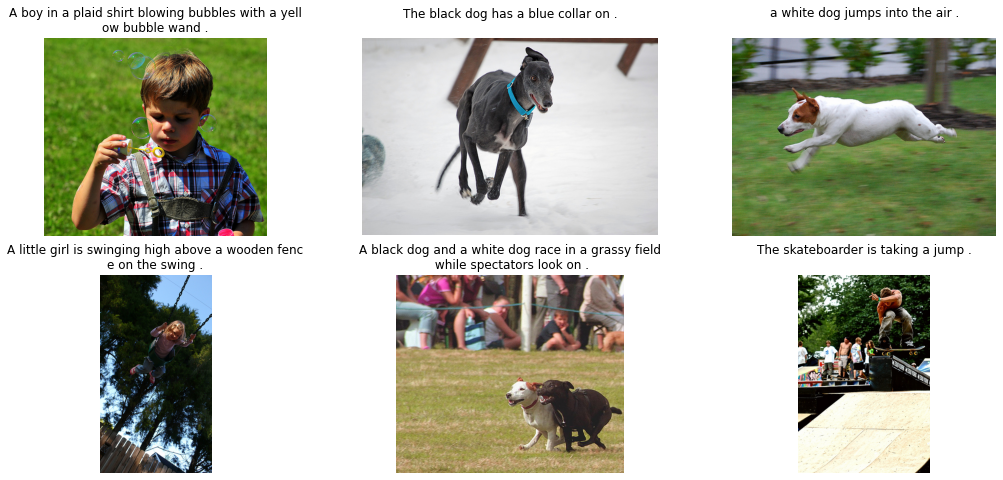

In [ ]:
samples = captions_df.sample(6).reset_index()
figure, axis = plt.subplots(2, 3, figsize=(18, 8))
for index, sample in samples.iterrows():
    image = plt.imread(f'{IMAGES_PATH}/{sample["image"]}')
    title = sample['caption'][:50] + '\n' + sample['caption'][50:]
    row, col = int(index / 3), index % 3
    axis[row, col].imshow(image)
    axis[row, col].set_title(title)
    axis[row, col].axis('off')

We need to clean the text in captions (e.g. removing punctuation) to simplify training, and also adding special tokens `<sos>` (start of sequence) token to be added at the begning of the text, and `<eos>` (end of sequence) token added at the end.



In [ ]:
def clean_caption(caption, start_token='<sos>', end_token='<eos>'):
    def remove_punctuation(word):
        translation = str.maketrans('', '', punctuation)
        return word.translate(translation)
    def is_valid_word(word):
        return len(word) > 1 and word.isalpha()
    caption = caption.lower().split(' ')
    caption = map(remove_punctuation, caption)
    caption = filter(is_valid_word, caption)
    cleaned_caption = f'{start_token} {" ".join(caption)} {end_token}'
    return cleaned_caption

Now we apply the cleaning function and update all captions text

In [ ]:
captions_df['caption'] = captions_df.caption.apply(lambda x: clean_caption(x))

Here we define a helper function that we will use later to get the maximum sequence length

In [ ]:
def get_max_length(tensor):
    return max(len(t) for t in tensor)

## Model

The model that we will be using for caption as illustrated by the diagram below is composed of three smaller models:
- Image feature extraction which is simply a CNN previously trained on image classification but without the classification head. The weights of this model are non-trainable.
- CNN Encoder which takes the image features and produces an embedding that will be learded as the model is trained
- RNN Decoder with Attention which will uses the image embedding as well as the hidden state propagated as the decoder process the caption tokens


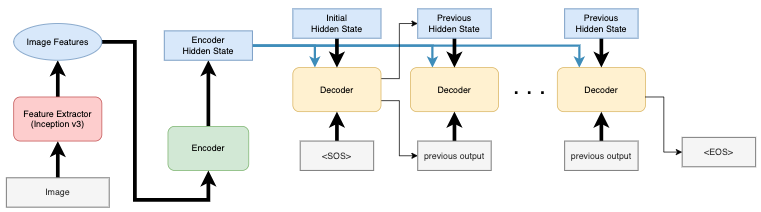

The first part of the model is the CNN Encoder that will train an dense layer as it processes images feature vector and generates what will be used by the Decoder attention layer

In [ ]:
class CNNEncoder(Model):
    def __init__(self, embedding_dim):
        super(CNNEncoder, self).__init__()
        self.fc = Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

The next component of our model is based on Bahdanau's Attention which was a break throught when it was first introduced as an improvemrnt to Encoder-Decoder models. It tries to address the problem that encoder faces as they try to squash information extracted from very long sequences.

To learn more about this algorithm can read the original paper [arxiv.org](https://arxiv.org/abs/1409.0473) or read a detailed explanation on [machinelearningmastery.com](https://machinelearningmastery.com/the-bahdanau-attention-mechanism/)

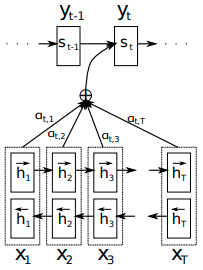

In [ ]:
class BahdanauAttention(Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_w = tf.nn.softmax(self.V(score), axis=1)
        ctx_vector = attention_w * features
        ctx_vector = tf.reduce_sum(ctx_vector, axis=1)
        return ctx_vector, attention_w

Next, we define the decoder whichi is an RNN that uses GRU and attention to learn how to produce captions from the text input sequences and the visual feature vectors extracted from the input images:

In [ ]:
class RNNDecoder(Model):
    def __init__(self, embedding_size, units, vocab_size):
        super(RNNDecoder, self).__init__()
        self.units = units
        self.embedding = Embedding(vocab_size, embedding_size)
        self.gru = GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc1 = Dense(self.units)
        self.fc2 = Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # calcualte the attention
        context_vector, attention_weights = self.attention(features, hidden)
        # calculate the embeddings of the input token
        x = self.embedding(x)
        expanded_context = tf.expand_dims(context_vector, 1)
        x = Concatenate(axis=-1)([expanded_context, x])
        # pass context vector and input embedding through GRU
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

Finally, we put the different pieces of model togher in the `Trainer` Class. It will create the encoder, the decoder, the tokenizer, and the optimizer and loss functions needed to train the whole system. This class also defines a function to perform a single training step as well as the training on many epoches. During the training, the training loss will be recorded which later can be visualized with TensorBoard.

In [ ]:
class Trainer(object):
    def __init__(self, embedding_size, units, vocab_size, tokenizer):
        self.tokenizer = tokenizer
        self.encoder = CNNEncoder(embedding_size)
        self.decoder = RNNDecoder(embedding_size, units, vocab_size)
        self.optimizer = Adam()
        self.loss = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    def loss_function(self, real, predicted):
        """Calculate the loss based on the ground truth caption and the predicted one"""
        mask = tf.math.logical_not(tf.math.equal(real,0))
        _loss = self.loss(real, predicted)
        mask = tf.cast(mask, dtype=_loss.dtype)
        _loss *= mask
        return tf.reduce_mean(_loss)

    @tf.function
    def train_step(self, image_tensor, target):
        """Perform one training step"""
        loss = 0
        hidden = self.decoder.reset_state(target.shape[0])
        start_token_idx = self.tokenizer.word_index['<sos>']
        init_batch = [start_token_idx] * target.shape[0]
        decoder_input = tf.expand_dims(init_batch, 1)

        with tf.GradientTape() as tape:
            features = self.encoder(image_tensor)
            for i in range(1, target.shape[1]):
                preds, hidden, _ = self.decoder(decoder_input, features, hidden)
                loss += self.loss_function(target[:, i], preds)
                decoder_input = tf.expand_dims(target[:, i],1)

        total_loss = loss / int(target.shape[1])
        trainable_vars = (self.encoder.trainable_variables + self.decoder.trainable_variables)
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients,trainable_vars))
        return loss, total_loss

    def train(self, dataset, epochs, num_steps):
        """Train and log metrics"""
        writer = tf.summary.create_file_writer('log_dir')
        for epoch in tqdm(range(epochs)):
            start = time.time()
            total_loss = 0
            for batch, (image_tensor, target) in enumerate(dataset):
                batch_loss, step_loss = self.train_step(image_tensor, target)
                total_loss += step_loss

            epoch_time = time.time() - start
            # write the loss value
            with writer.as_default():
                tf.summary.scalar('training loss', total_loss / num_steps, step=epoch+1)
                tf.summary.scalar('Epoch time (s)', epoch_time, step=epoch+1)


## Training

Before we can start the training, we need to perform some data pre-process. Let's first get an array of image paths and the corresponding captions

In [ ]:
train_images = captions_df.image.apply(lambda image: f'{IMAGES_PATH}/{image}').values
train_captions = captions_df.caption.values

We need to download a pre-trained instance of Inception V3 with the Imagenet dataset and used as the image feature extractor after removing the model classification head

In [ ]:
feature_extractor = InceptionV3(include_top=False, weights='imagenet')
feature_extractor = Model(feature_extractor.input, feature_extractor.layers[-1].output)

87910968/87910968 [==============================] - 0s 0us/step


We need to define a function that will load images based on their path and resize them as expected by the feature extractor model

In [ ]:
def load_image_fn(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = preprocess_input(image)
    return image, image_path

We can use the previous funciton to Create a `tf.data.Dataset` of the images

In [ ]:
BATCH_SIZE = 8
image_dataset = tf.data.Dataset.from_tensor_slices(train_images)\
    .map(load_image_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
    .batch(BATCH_SIZE)

We iteratate over all the images in the dataset and pass them through the feature extractor. As the extracted feature vectors cannot fit in memory we store them under `FEATURES_PATH` folder

In [ ]:
for image, path in tqdm(image_dataset):
    batch_features = feature_extractor.predict(image)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_feature, p in zip(batch_features, path):
        feature_path = Path(p.numpy().decode('UTF-8'))
        image_name = feature_path.stem
        np.save(f'{FEATURES_PATH}/{image_name}', batch_feature.numpy())

  0%|          | 0/5057 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


  0%|          | 1/5057 [00:09<13:29:26,  9.61s/it]

1/1 [==============================] - 0s 48ms/step


  0%|          | 2/5057 [00:09<5:41:14,  4.05s/it] 

1/1 [==============================] - 0s 77ms/step


  0%|          | 3/5057 [00:10<3:14:30,  2.31s/it]

1/1 [==============================] - 0s 36ms/step


  0%|          | 4/5057 [00:10<2:03:23,  1.47s/it]

1/1 [==============================] - 0s 38ms/step


  0%|          | 5/5057 [00:10<1:23:35,  1.01it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 6/5057 [00:10<59:34,  1.41it/s]  

1/1 [==============================] - 0s 38ms/step


  0%|          | 7/5057 [00:10<43:57,  1.91it/s]

1/1 [==============================] - 0s 48ms/step


  0%|          | 8/5057 [00:10<34:04,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 9/5057 [00:10<26:47,  3.14it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 10/5057 [00:11<22:32,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 11/5057 [00:11<19:03,  4.41it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 12/5057 [00:11<17:15,  4.87it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 13/5057 [00:11<15:56,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 14/5057 [00:11<15:00,  5.60it/s]

1/1 [==============================] - 0s 48ms/step


  0%|          | 15/5057 [00:11<13:56,  6.03it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 16/5057 [00:11<13:31,  6.21it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 17/5057 [00:12<13:21,  6.29it/s]

1/1 [==============================] - 0s 107ms/step


  0%|          | 18/5057 [00:12<14:38,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 19/5057 [00:12<14:27,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 20/5057 [00:12<14:03,  5.97it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 21/5057 [00:12<13:28,  6.23it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 22/5057 [00:12<13:10,  6.37it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 23/5057 [00:13<12:49,  6.54it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 24/5057 [00:13<13:18,  6.31it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 25/5057 [00:13<13:12,  6.35it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 26/5057 [00:13<13:11,  6.35it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 27/5057 [00:13<13:07,  6.39it/s]

1/1 [==============================] - 0s 48ms/step


  1%|          | 28/5057 [00:13<13:36,  6.16it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 29/5057 [00:14<13:27,  6.23it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 30/5057 [00:14<13:29,  6.21it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 31/5057 [00:14<13:33,  6.18it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 32/5057 [00:14<13:07,  6.38it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 33/5057 [00:14<13:41,  6.12it/s]

1/1 [==============================] - 0s 56ms/step


  1%|          | 34/5057 [00:14<14:20,  5.84it/s]

1/1 [==============================] - 0s 58ms/step


  1%|          | 35/5057 [00:15<14:22,  5.82it/s]

1/1 [==============================] - 0s 48ms/step


  1%|          | 36/5057 [00:15<14:41,  5.70it/s]

1/1 [==============================] - 0s 55ms/step


  1%|          | 37/5057 [00:15<14:41,  5.69it/s]

1/1 [==============================] - 0s 59ms/step


  1%|          | 38/5057 [00:15<15:17,  5.47it/s]

1/1 [==============================] - 0s 51ms/step


  1%|          | 39/5057 [00:15<15:53,  5.27it/s]

1/1 [==============================] - 0s 53ms/step


  1%|          | 40/5057 [00:16<18:41,  4.47it/s]

1/1 [==============================] - 0s 55ms/step


  1%|          | 41/5057 [00:16<20:31,  4.07it/s]

1/1 [==============================] - 0s 53ms/step


  1%|          | 42/5057 [00:16<21:48,  3.83it/s]

1/1 [==============================] - 0s 68ms/step


  1%|          | 43/5057 [00:16<22:16,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 44/5057 [00:17<19:25,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 45/5057 [00:17<17:35,  4.75it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 46/5057 [00:17<16:19,  5.12it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 47/5057 [00:17<15:51,  5.27it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 48/5057 [00:17<15:07,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 49/5057 [00:17<14:35,  5.72it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 50/5057 [00:18<14:08,  5.90it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 51/5057 [00:18<13:59,  5.96it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 52/5057 [00:18<13:49,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 53/5057 [00:18<13:36,  6.13it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 54/5057 [00:18<14:22,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 55/5057 [00:18<14:13,  5.86it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 56/5057 [00:19<14:00,  5.95it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 57/5057 [00:19<13:51,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 58/5057 [00:19<13:53,  6.00it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 59/5057 [00:19<13:55,  5.98it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 60/5057 [00:19<14:39,  5.68it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 61/5057 [00:19<14:18,  5.82it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 62/5057 [00:20<13:45,  6.05it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 63/5057 [00:20<13:31,  6.15it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 64/5057 [00:20<13:22,  6.22it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 65/5057 [00:20<13:15,  6.28it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 66/5057 [00:20<13:38,  6.10it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 67/5057 [00:20<13:43,  6.06it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 68/5057 [00:21<14:05,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 69/5057 [00:21<13:49,  6.01it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▏         | 70/5057 [00:21<13:32,  6.14it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 71/5057 [00:21<13:02,  6.37it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 72/5057 [00:21<13:13,  6.28it/s]

1/1 [==============================] - 0s 39ms/step


  1%|▏         | 73/5057 [00:21<13:26,  6.18it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▏         | 74/5057 [00:22<13:24,  6.19it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▏         | 75/5057 [00:22<13:02,  6.36it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 76/5057 [00:22<13:09,  6.31it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 77/5057 [00:22<12:59,  6.39it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 78/5057 [00:22<12:39,  6.56it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 79/5057 [00:22<12:42,  6.53it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 80/5057 [00:22<12:28,  6.65it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 81/5057 [00:23<12:48,  6.47it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 82/5057 [00:23<13:04,  6.34it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 83/5057 [00:23<12:54,  6.42it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 84/5057 [00:23<12:53,  6.43it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 85/5057 [00:23<12:48,  6.47it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 86/5057 [00:23<12:53,  6.43it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 87/5057 [00:24<12:54,  6.41it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 88/5057 [00:24<13:07,  6.31it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 89/5057 [00:24<12:38,  6.55it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 90/5057 [00:24<12:38,  6.55it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 91/5057 [00:24<12:49,  6.46it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 92/5057 [00:24<13:27,  6.15it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 93/5057 [00:25<13:04,  6.32it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 94/5057 [00:25<13:09,  6.28it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 95/5057 [00:25<13:05,  6.31it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 96/5057 [00:25<12:56,  6.39it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 97/5057 [00:25<12:41,  6.51it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 98/5057 [00:25<12:42,  6.50it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 99/5057 [00:25<12:39,  6.53it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 100/5057 [00:26<12:38,  6.54it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 101/5057 [00:26<12:36,  6.55it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 102/5057 [00:26<12:54,  6.40it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 103/5057 [00:26<12:50,  6.43it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 104/5057 [00:26<12:45,  6.47it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 105/5057 [00:26<12:54,  6.39it/s]

1/1 [==============================] - 0s 59ms/step


  2%|▏         | 106/5057 [00:27<13:18,  6.20it/s]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 107/5057 [00:27<14:31,  5.68it/s]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 108/5057 [00:27<14:48,  5.57it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 109/5057 [00:27<15:38,  5.27it/s]

1/1 [==============================] - 0s 54ms/step


  2%|▏         | 110/5057 [00:27<15:29,  5.32it/s]

1/1 [==============================] - 0s 54ms/step


  2%|▏         | 111/5057 [00:28<15:55,  5.17it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 112/5057 [00:28<16:46,  4.91it/s]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 113/5057 [00:28<17:18,  4.76it/s]

1/1 [==============================] - 0s 53ms/step


  2%|▏         | 114/5057 [00:28<17:40,  4.66it/s]

1/1 [==============================] - 0s 52ms/step


  2%|▏         | 115/5057 [00:29<19:46,  4.17it/s]

1/1 [==============================] - 0s 73ms/step


  2%|▏         | 116/5057 [00:29<21:11,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 117/5057 [00:29<18:44,  4.39it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 118/5057 [00:29<17:12,  4.79it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 119/5057 [00:29<15:51,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 120/5057 [00:29<15:04,  5.46it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 121/5057 [00:30<14:53,  5.53it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 122/5057 [00:30<14:28,  5.68it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 123/5057 [00:30<13:58,  5.88it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 124/5057 [00:30<13:39,  6.02it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 125/5057 [00:30<13:06,  6.27it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 126/5057 [00:30<13:03,  6.29it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 127/5057 [00:31<12:44,  6.44it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 128/5057 [00:31<12:50,  6.40it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 129/5057 [00:31<12:49,  6.41it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 130/5057 [00:31<12:44,  6.45it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 131/5057 [00:31<12:28,  6.58it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 132/5057 [00:31<12:24,  6.61it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 133/5057 [00:31<12:23,  6.62it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 134/5057 [00:32<12:25,  6.60it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 135/5057 [00:32<12:34,  6.52it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 136/5057 [00:32<12:30,  6.56it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 137/5057 [00:32<13:05,  6.27it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 138/5057 [00:32<13:02,  6.29it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 139/5057 [00:32<12:55,  6.34it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 140/5057 [00:33<12:50,  6.38it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 141/5057 [00:33<12:59,  6.31it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 142/5057 [00:33<12:38,  6.48it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 143/5057 [00:33<12:38,  6.48it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 144/5057 [00:33<12:40,  6.46it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 145/5057 [00:33<12:43,  6.44it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 146/5057 [00:34<12:46,  6.40it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 147/5057 [00:34<12:47,  6.40it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 148/5057 [00:34<12:47,  6.40it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 149/5057 [00:34<12:34,  6.51it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 150/5057 [00:34<12:33,  6.51it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 151/5057 [00:34<12:31,  6.53it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 152/5057 [00:34<12:30,  6.54it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 153/5057 [00:35<12:43,  6.42it/s]

1/1 [==============================] - 0s 172ms/step


  3%|▎         | 154/5057 [00:35<15:49,  5.17it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 155/5057 [00:35<15:02,  5.43it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 156/5057 [00:35<14:31,  5.62it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 157/5057 [00:35<14:08,  5.78it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 158/5057 [00:36<13:36,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 159/5057 [00:36<13:28,  6.05it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 160/5057 [00:36<13:22,  6.10it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 161/5057 [00:36<13:24,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 162/5057 [00:36<13:08,  6.21it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 163/5057 [00:36<13:14,  6.16it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 164/5057 [00:36<12:58,  6.29it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 165/5057 [00:37<13:19,  6.12it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 166/5057 [00:37<12:57,  6.29it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 167/5057 [00:37<13:13,  6.16it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 168/5057 [00:37<13:03,  6.24it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 169/5057 [00:37<13:05,  6.22it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 170/5057 [00:37<12:48,  6.36it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 171/5057 [00:38<12:57,  6.29it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 172/5057 [00:38<12:55,  6.30it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 173/5057 [00:38<12:44,  6.38it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 174/5057 [00:38<12:38,  6.44it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 175/5057 [00:38<12:42,  6.40it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 176/5057 [00:38<12:40,  6.41it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 177/5057 [00:39<12:55,  6.30it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 178/5057 [00:39<12:59,  6.26it/s]

1/1 [==============================] - 0s 65ms/step


  4%|▎         | 179/5057 [00:39<13:41,  5.94it/s]

1/1 [==============================] - 0s 63ms/step


  4%|▎         | 180/5057 [00:39<14:30,  5.60it/s]

1/1 [==============================] - 0s 63ms/step


  4%|▎         | 181/5057 [00:39<15:02,  5.40it/s]

1/1 [==============================] - 0s 50ms/step


  4%|▎         | 182/5057 [00:40<15:59,  5.08it/s]

1/1 [==============================] - 0s 55ms/step


  4%|▎         | 183/5057 [00:40<19:44,  4.12it/s]

1/1 [==============================] - 0s 65ms/step


  4%|▎         | 184/5057 [00:40<19:01,  4.27it/s]

1/1 [==============================] - 0s 52ms/step


  4%|▎         | 185/5057 [00:40<20:49,  3.90it/s]

1/1 [==============================] - 0s 58ms/step


  4%|▎         | 186/5057 [00:41<21:34,  3.76it/s]

1/1 [==============================] - 0s 52ms/step


  4%|▎         | 187/5057 [00:41<19:47,  4.10it/s]

1/1 [==============================] - 0s 50ms/step


  4%|▎         | 188/5057 [00:41<18:07,  4.48it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 189/5057 [00:41<16:46,  4.84it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 190/5057 [00:41<15:34,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 191/5057 [00:42<14:47,  5.48it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 192/5057 [00:42<14:15,  5.69it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 193/5057 [00:42<13:48,  5.87it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 194/5057 [00:42<13:26,  6.03it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 195/5057 [00:42<13:25,  6.04it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 196/5057 [00:42<13:21,  6.07it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 197/5057 [00:42<12:56,  6.26it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 198/5057 [00:43<12:56,  6.25it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 199/5057 [00:43<12:54,  6.27it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 200/5057 [00:43<12:53,  6.28it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 201/5057 [00:43<12:53,  6.28it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 202/5057 [00:43<12:36,  6.42it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 203/5057 [00:43<12:32,  6.45it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 204/5057 [00:44<12:38,  6.40it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 205/5057 [00:44<12:20,  6.56it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 206/5057 [00:44<12:19,  6.56it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 207/5057 [00:44<12:22,  6.53it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 208/5057 [00:44<15:45,  5.13it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 209/5057 [00:44<15:09,  5.33it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 210/5057 [00:45<14:26,  5.59it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 211/5057 [00:45<14:06,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 212/5057 [00:45<13:44,  5.87it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 213/5057 [00:45<13:40,  5.90it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 214/5057 [00:45<13:11,  6.12it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 215/5057 [00:45<12:49,  6.29it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 216/5057 [00:46<12:45,  6.33it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 217/5057 [00:46<12:33,  6.43it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 218/5057 [00:46<12:37,  6.39it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 219/5057 [00:46<13:04,  6.17it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 220/5057 [00:46<13:10,  6.12it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 221/5057 [00:46<12:44,  6.33it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 222/5057 [00:47<12:26,  6.48it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 223/5057 [00:47<12:36,  6.39it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 224/5057 [00:47<12:39,  6.36it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 225/5057 [00:47<12:20,  6.53it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 226/5057 [00:47<12:24,  6.49it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 227/5057 [00:47<12:11,  6.60it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 228/5057 [00:47<12:03,  6.67it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 229/5057 [00:48<12:20,  6.52it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 230/5057 [00:48<12:24,  6.48it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 231/5057 [00:48<12:18,  6.53it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 232/5057 [00:48<12:18,  6.54it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▍         | 233/5057 [00:48<12:22,  6.50it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 234/5057 [00:48<12:24,  6.48it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 235/5057 [00:49<12:33,  6.40it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 236/5057 [00:49<12:56,  6.21it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 237/5057 [00:49<13:08,  6.11it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 238/5057 [00:49<13:17,  6.04it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 239/5057 [00:49<13:16,  6.05it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 240/5057 [00:49<13:14,  6.06it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 241/5057 [00:50<13:10,  6.09it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 242/5057 [00:50<13:10,  6.09it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 243/5057 [00:50<14:55,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 244/5057 [00:50<14:47,  5.42it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 245/5057 [00:50<14:21,  5.58it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▍         | 246/5057 [00:51<15:52,  5.05it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 247/5057 [00:51<15:04,  5.32it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 248/5057 [00:51<14:27,  5.54it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 249/5057 [00:51<13:55,  5.76it/s]

1/1 [==============================] - 0s 54ms/step


  5%|▍         | 250/5057 [00:51<13:47,  5.81it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▍         | 251/5057 [00:51<14:56,  5.36it/s]

1/1 [==============================] - 0s 53ms/step


  5%|▍         | 252/5057 [00:52<15:48,  5.07it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▌         | 253/5057 [00:52<17:54,  4.47it/s]

1/1 [==============================] - 0s 52ms/step


  5%|▌         | 254/5057 [00:52<19:40,  4.07it/s]

1/1 [==============================] - 0s 52ms/step


  5%|▌         | 255/5057 [00:52<19:24,  4.12it/s]

1/1 [==============================] - 0s 57ms/step


  5%|▌         | 256/5057 [00:53<19:17,  4.15it/s]

1/1 [==============================] - 0s 58ms/step


  5%|▌         | 257/5057 [00:53<18:55,  4.23it/s]

1/1 [==============================] - 0s 53ms/step


  5%|▌         | 258/5057 [00:53<18:38,  4.29it/s]

1/1 [==============================] - 0s 54ms/step


  5%|▌         | 259/5057 [00:53<19:12,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 260/5057 [00:54<17:21,  4.60it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 261/5057 [00:54<15:56,  5.01it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 262/5057 [00:54<14:51,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 263/5057 [00:54<14:20,  5.57it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 264/5057 [00:54<14:05,  5.67it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 265/5057 [00:54<15:39,  5.10it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 266/5057 [00:55<14:29,  5.51it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 267/5057 [00:55<14:13,  5.61it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 268/5057 [00:55<14:33,  5.48it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 269/5057 [00:55<14:01,  5.69it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 270/5057 [00:55<13:31,  5.90it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 271/5057 [00:55<13:18,  5.99it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 272/5057 [00:56<13:02,  6.11it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 273/5057 [00:56<12:49,  6.21it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 274/5057 [00:56<12:42,  6.27it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 275/5057 [00:56<12:50,  6.21it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 276/5057 [00:56<12:44,  6.25it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 277/5057 [00:56<12:28,  6.38it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 278/5057 [00:57<12:23,  6.43it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 279/5057 [00:57<12:19,  6.46it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 280/5057 [00:57<12:26,  6.40it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 281/5057 [00:57<12:22,  6.43it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 282/5057 [00:57<12:28,  6.38it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 283/5057 [00:57<12:34,  6.32it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 284/5057 [00:57<12:37,  6.30it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 285/5057 [00:58<12:34,  6.32it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 286/5057 [00:58<12:37,  6.30it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 287/5057 [00:58<12:33,  6.33it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 288/5057 [00:58<12:35,  6.31it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 289/5057 [00:58<12:47,  6.21it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 290/5057 [00:58<12:45,  6.23it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 291/5057 [00:59<12:43,  6.25it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 292/5057 [00:59<12:53,  6.16it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 293/5057 [00:59<12:37,  6.29it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 294/5057 [00:59<12:36,  6.29it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 295/5057 [00:59<12:39,  6.27it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 296/5057 [00:59<12:20,  6.43it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 297/5057 [01:00<12:35,  6.30it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 298/5057 [01:00<12:40,  6.26it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 299/5057 [01:00<12:31,  6.33it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 300/5057 [01:00<16:52,  4.70it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 301/5057 [01:00<15:28,  5.12it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 302/5057 [01:01<14:24,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 303/5057 [01:01<13:49,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 304/5057 [01:01<13:09,  6.02it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 305/5057 [01:01<12:49,  6.17it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 306/5057 [01:01<12:36,  6.28it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 307/5057 [01:01<12:37,  6.27it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 308/5057 [01:01<12:24,  6.38it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 309/5057 [01:02<12:42,  6.22it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 310/5057 [01:02<12:57,  6.11it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 311/5057 [01:02<12:49,  6.17it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 312/5057 [01:02<12:47,  6.18it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 313/5057 [01:02<12:40,  6.24it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 314/5057 [01:02<12:48,  6.17it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 315/5057 [01:03<12:48,  6.17it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 316/5057 [01:03<12:26,  6.35it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 317/5057 [01:03<12:38,  6.25it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 318/5057 [01:03<12:37,  6.25it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 319/5057 [01:03<12:35,  6.27it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 320/5057 [01:03<12:49,  6.15it/s]

1/1 [==============================] - 0s 68ms/step


  6%|▋         | 321/5057 [01:04<14:19,  5.51it/s]

1/1 [==============================] - 0s 51ms/step


  6%|▋         | 322/5057 [01:04<14:44,  5.35it/s]

1/1 [==============================] - 0s 49ms/step


  6%|▋         | 323/5057 [01:04<15:15,  5.17it/s]

1/1 [==============================] - 0s 50ms/step


  6%|▋         | 324/5057 [01:04<15:33,  5.07it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▋         | 325/5057 [01:04<15:45,  5.01it/s]

1/1 [==============================] - 0s 52ms/step


  6%|▋         | 326/5057 [01:05<15:15,  5.17it/s]

1/1 [==============================] - 0s 57ms/step


  6%|▋         | 327/5057 [01:05<15:22,  5.13it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▋         | 328/5057 [01:05<21:55,  3.59it/s]

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 329/5057 [01:05<20:15,  3.89it/s]

1/1 [==============================] - 0s 60ms/step


  7%|▋         | 330/5057 [01:06<18:42,  4.21it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 331/5057 [01:06<17:41,  4.45it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 332/5057 [01:06<15:56,  4.94it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 333/5057 [01:06<14:55,  5.27it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 334/5057 [01:06<14:04,  5.59it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 335/5057 [01:06<13:27,  5.85it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 336/5057 [01:07<12:51,  6.12it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 337/5057 [01:07<12:48,  6.14it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 338/5057 [01:07<12:37,  6.23it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 339/5057 [01:07<12:25,  6.33it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 340/5057 [01:07<12:14,  6.42it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 341/5057 [01:07<12:00,  6.54it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 342/5057 [01:08<12:03,  6.52it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 343/5057 [01:08<12:12,  6.44it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 344/5057 [01:08<12:18,  6.38it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 345/5057 [01:08<12:05,  6.50it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 346/5057 [01:08<12:26,  6.31it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 347/5057 [01:08<12:32,  6.26it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 348/5057 [01:08<12:14,  6.41it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 349/5057 [01:09<12:11,  6.44it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 350/5057 [01:09<12:36,  6.22it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 351/5057 [01:09<12:35,  6.23it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 352/5057 [01:09<12:52,  6.09it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 353/5057 [01:09<12:47,  6.13it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 354/5057 [01:09<12:51,  6.10it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 355/5057 [01:10<13:05,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 356/5057 [01:10<15:43,  4.98it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 357/5057 [01:10<14:46,  5.30it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 358/5057 [01:10<14:04,  5.57it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 359/5057 [01:10<13:20,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 360/5057 [01:11<13:07,  5.97it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 361/5057 [01:11<12:49,  6.10it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 362/5057 [01:11<12:48,  6.11it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 363/5057 [01:11<12:50,  6.09it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 364/5057 [01:11<12:49,  6.10it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 365/5057 [01:11<13:19,  5.87it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 366/5057 [01:12<12:57,  6.03it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 367/5057 [01:12<12:38,  6.18it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 368/5057 [01:12<12:44,  6.13it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 369/5057 [01:12<12:34,  6.22it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 370/5057 [01:12<12:37,  6.19it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 371/5057 [01:12<12:16,  6.36it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 372/5057 [01:12<12:04,  6.46it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 373/5057 [01:13<12:21,  6.32it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 374/5057 [01:13<12:19,  6.33it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 375/5057 [01:13<12:24,  6.29it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 376/5057 [01:13<12:14,  6.37it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 377/5057 [01:13<12:07,  6.43it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 378/5057 [01:13<12:15,  6.37it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 379/5057 [01:14<12:18,  6.33it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 380/5057 [01:14<11:54,  6.55it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 381/5057 [01:14<12:13,  6.38it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 382/5057 [01:14<12:26,  6.26it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 383/5057 [01:14<14:53,  5.23it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 384/5057 [01:14<14:09,  5.50it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 385/5057 [01:15<13:40,  5.69it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 386/5057 [01:15<13:16,  5.87it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 387/5057 [01:15<12:55,  6.02it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 388/5057 [01:15<12:51,  6.05it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 389/5057 [01:15<12:37,  6.16it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 390/5057 [01:15<12:31,  6.21it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 391/5057 [01:16<12:28,  6.23it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 392/5057 [01:16<12:20,  6.30it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 393/5057 [01:16<14:02,  5.54it/s]

1/1 [==============================] - 0s 51ms/step


  8%|▊         | 394/5057 [01:16<14:44,  5.27it/s]

1/1 [==============================] - 0s 53ms/step


  8%|▊         | 395/5057 [01:16<15:23,  5.05it/s]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 396/5057 [01:17<15:30,  5.01it/s]

1/1 [==============================] - 0s 51ms/step


  8%|▊         | 397/5057 [01:17<15:28,  5.02it/s]

1/1 [==============================] - 0s 56ms/step


  8%|▊         | 398/5057 [01:17<16:00,  4.85it/s]

1/1 [==============================] - 0s 50ms/step


  8%|▊         | 399/5057 [01:17<15:13,  5.10it/s]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 400/5057 [01:18<17:38,  4.40it/s]

1/1 [==============================] - 0s 57ms/step


  8%|▊         | 401/5057 [01:18<17:42,  4.38it/s]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 402/5057 [01:18<17:13,  4.50it/s]

1/1 [==============================] - 0s 61ms/step


  8%|▊         | 403/5057 [01:18<18:38,  4.16it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 404/5057 [01:18<17:05,  4.54it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 405/5057 [01:19<15:46,  4.91it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 406/5057 [01:19<14:43,  5.27it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 407/5057 [01:19<13:57,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 408/5057 [01:19<13:52,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 409/5057 [01:19<13:48,  5.61it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 410/5057 [01:19<13:49,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 411/5057 [01:20<13:49,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 412/5057 [01:20<13:50,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 413/5057 [01:20<13:37,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 414/5057 [01:20<15:56,  4.85it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 415/5057 [01:20<14:52,  5.20it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 416/5057 [01:21<13:56,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 417/5057 [01:21<13:39,  5.66it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 418/5057 [01:21<13:13,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 419/5057 [01:21<13:13,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 420/5057 [01:21<12:43,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 421/5057 [01:21<12:45,  6.05it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 422/5057 [01:22<12:37,  6.12it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 423/5057 [01:22<12:41,  6.09it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 424/5057 [01:22<12:38,  6.11it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 425/5057 [01:22<13:12,  5.84it/s]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 426/5057 [01:22<12:54,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 427/5057 [01:22<12:40,  6.09it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 428/5057 [01:22<12:36,  6.12it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 429/5057 [01:23<12:23,  6.22it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▊         | 430/5057 [01:23<12:26,  6.20it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 431/5057 [01:23<12:04,  6.38it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▊         | 432/5057 [01:23<12:12,  6.31it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▊         | 433/5057 [01:23<11:57,  6.45it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 434/5057 [01:23<11:51,  6.49it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 435/5057 [01:24<12:02,  6.40it/s]

1/1 [==============================] - 0s 313ms/step


  9%|▊         | 436/5057 [01:24<25:14,  3.05it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▊         | 437/5057 [01:24<21:38,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 438/5057 [01:25<18:49,  4.09it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▊         | 439/5057 [01:25<16:44,  4.60it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 440/5057 [01:25<15:23,  5.00it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 441/5057 [01:25<14:55,  5.16it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 442/5057 [01:25<14:13,  5.41it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 443/5057 [01:25<13:35,  5.66it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 444/5057 [01:26<13:09,  5.84it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 445/5057 [01:26<12:50,  5.99it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 446/5057 [01:26<12:44,  6.03it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 447/5057 [01:26<12:32,  6.12it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 448/5057 [01:26<12:46,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 449/5057 [01:26<12:20,  6.22it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 450/5057 [01:27<12:05,  6.35it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 451/5057 [01:27<12:00,  6.39it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 452/5057 [01:27<12:04,  6.35it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 453/5057 [01:27<12:01,  6.38it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 454/5057 [01:27<11:58,  6.41it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 455/5057 [01:27<12:12,  6.28it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 456/5057 [01:28<12:11,  6.29it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 457/5057 [01:28<11:56,  6.42it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 458/5057 [01:28<11:58,  6.40it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 459/5057 [01:28<11:45,  6.51it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 460/5057 [01:28<11:43,  6.54it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 461/5057 [01:28<12:15,  6.25it/s]

1/1 [==============================] - 0s 51ms/step


  9%|▉         | 462/5057 [01:29<13:39,  5.61it/s]

1/1 [==============================] - 0s 48ms/step


  9%|▉         | 463/5057 [01:29<14:02,  5.45it/s]

1/1 [==============================] - 0s 53ms/step


  9%|▉         | 464/5057 [01:29<15:11,  5.04it/s]

1/1 [==============================] - 0s 60ms/step


  9%|▉         | 465/5057 [01:29<14:50,  5.16it/s]

1/1 [==============================] - 0s 51ms/step


  9%|▉         | 466/5057 [01:29<14:22,  5.32it/s]

1/1 [==============================] - 0s 67ms/step


  9%|▉         | 467/5057 [01:29<14:23,  5.31it/s]

1/1 [==============================] - 0s 50ms/step


  9%|▉         | 468/5057 [01:30<15:18,  4.99it/s]

1/1 [==============================] - 0s 55ms/step


  9%|▉         | 469/5057 [01:30<15:41,  4.87it/s]

1/1 [==============================] - 0s 50ms/step


  9%|▉         | 470/5057 [01:30<18:50,  4.06it/s]

1/1 [==============================] - 0s 52ms/step


  9%|▉         | 471/5057 [01:31<20:05,  3.80it/s]

1/1 [==============================] - 0s 55ms/step


  9%|▉         | 472/5057 [01:31<18:57,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 473/5057 [01:31<17:01,  4.49it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 474/5057 [01:31<15:47,  4.84it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 475/5057 [01:31<14:49,  5.15it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 476/5057 [01:31<14:05,  5.42it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 477/5057 [01:32<13:34,  5.62it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 478/5057 [01:32<13:13,  5.77it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 479/5057 [01:32<12:51,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 480/5057 [01:32<12:28,  6.12it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 481/5057 [01:32<12:59,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 482/5057 [01:32<13:07,  5.81it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 483/5057 [01:33<13:02,  5.84it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 484/5057 [01:33<12:55,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 485/5057 [01:33<12:37,  6.04it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 486/5057 [01:33<12:30,  6.09it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 487/5057 [01:33<12:15,  6.21it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 488/5057 [01:33<12:20,  6.17it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 489/5057 [01:34<12:12,  6.23it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 490/5057 [01:34<12:05,  6.30it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 491/5057 [01:34<12:27,  6.11it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 492/5057 [01:34<12:15,  6.21it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 493/5057 [01:34<12:17,  6.19it/s]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 494/5057 [01:34<12:27,  6.11it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 495/5057 [01:35<12:27,  6.10it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 496/5057 [01:35<12:29,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 497/5057 [01:35<12:09,  6.25it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 498/5057 [01:35<12:16,  6.19it/s]

1/1 [==============================] - 0s 48ms/step


 10%|▉         | 499/5057 [01:35<12:12,  6.23it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 500/5057 [01:35<12:24,  6.12it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 501/5057 [01:36<12:11,  6.23it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 502/5057 [01:36<12:12,  6.21it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 503/5057 [01:36<12:08,  6.25it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 504/5057 [01:36<12:14,  6.20it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 505/5057 [01:36<12:24,  6.12it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 506/5057 [01:36<12:12,  6.21it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 507/5057 [01:36<12:15,  6.18it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 508/5057 [01:37<12:12,  6.21it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 509/5057 [01:37<12:24,  6.11it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 510/5057 [01:37<12:19,  6.15it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 511/5057 [01:37<12:18,  6.16it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 512/5057 [01:37<12:22,  6.12it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 513/5057 [01:37<12:22,  6.12it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 514/5057 [01:38<12:23,  6.11it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 515/5057 [01:38<12:04,  6.27it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 516/5057 [01:38<12:10,  6.22it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 517/5057 [01:38<12:22,  6.12it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 518/5057 [01:38<12:12,  6.20it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 519/5057 [01:38<12:39,  5.97it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 520/5057 [01:39<12:33,  6.02it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 521/5057 [01:39<12:22,  6.11it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 522/5057 [01:39<12:20,  6.12it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 523/5057 [01:39<12:21,  6.11it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 524/5057 [01:39<12:00,  6.30it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 525/5057 [01:39<12:07,  6.23it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 526/5057 [01:40<12:19,  6.13it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 527/5057 [01:40<12:25,  6.08it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 528/5057 [01:40<12:37,  5.98it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 529/5057 [01:40<12:29,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 530/5057 [01:40<12:22,  6.09it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 531/5057 [01:40<12:36,  5.98it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 532/5057 [01:41<12:35,  5.99it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 533/5057 [01:41<12:23,  6.09it/s]

1/1 [==============================] - 0s 63ms/step


 11%|█         | 534/5057 [01:41<13:43,  5.49it/s]

1/1 [==============================] - 0s 52ms/step


 11%|█         | 535/5057 [01:41<14:41,  5.13it/s]

1/1 [==============================] - 0s 53ms/step


 11%|█         | 536/5057 [01:41<14:51,  5.07it/s]

1/1 [==============================] - 0s 55ms/step


 11%|█         | 537/5057 [01:42<17:01,  4.42it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 538/5057 [01:42<17:52,  4.21it/s]

1/1 [==============================] - 0s 64ms/step


 11%|█         | 539/5057 [01:42<17:13,  4.37it/s]

1/1 [==============================] - 0s 50ms/step


 11%|█         | 540/5057 [01:42<16:51,  4.46it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 541/5057 [01:43<16:19,  4.61it/s]

1/1 [==============================] - 0s 54ms/step


 11%|█         | 542/5057 [01:43<15:41,  4.80it/s]

1/1 [==============================] - 0s 67ms/step


 11%|█         | 543/5057 [01:43<17:04,  4.41it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 544/5057 [01:43<18:12,  4.13it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 545/5057 [01:43<16:42,  4.50it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 546/5057 [01:44<17:21,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 547/5057 [01:44<15:51,  4.74it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 548/5057 [01:44<18:01,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 549/5057 [01:44<16:15,  4.62it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 550/5057 [01:45<15:04,  4.98it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 551/5057 [01:45<14:12,  5.29it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 552/5057 [01:45<13:27,  5.58it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 553/5057 [01:45<12:54,  5.82it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 554/5057 [01:45<12:29,  6.01it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 555/5057 [01:45<12:30,  6.00it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 556/5057 [01:46<12:55,  5.80it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 557/5057 [01:46<12:18,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 558/5057 [01:46<12:08,  6.17it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 559/5057 [01:46<11:51,  6.32it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 560/5057 [01:46<11:51,  6.32it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 561/5057 [01:46<11:48,  6.34it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 562/5057 [01:46<11:50,  6.32it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 563/5057 [01:47<11:55,  6.28it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 564/5057 [01:47<12:21,  6.06it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 565/5057 [01:47<12:08,  6.17it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 566/5057 [01:47<12:14,  6.11it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 567/5057 [01:47<12:19,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 568/5057 [01:47<12:06,  6.18it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 569/5057 [01:48<12:10,  6.14it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 570/5057 [01:48<11:53,  6.29it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 571/5057 [01:48<11:51,  6.31it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 572/5057 [01:48<11:45,  6.35it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 573/5057 [01:48<11:52,  6.29it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 574/5057 [01:49<17:24,  4.29it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 575/5057 [01:49<15:53,  4.70it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 576/5057 [01:49<14:45,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 577/5057 [01:49<13:58,  5.34it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 578/5057 [01:49<13:22,  5.58it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 579/5057 [01:49<12:53,  5.79it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█▏        | 580/5057 [01:50<12:42,  5.87it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█▏        | 581/5057 [01:50<12:25,  6.00it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 582/5057 [01:50<12:43,  5.86it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 583/5057 [01:50<12:45,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 584/5057 [01:50<12:59,  5.74it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 585/5057 [01:50<13:04,  5.70it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 586/5057 [01:51<13:06,  5.68it/s]

1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 587/5057 [01:51<13:14,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 588/5057 [01:51<13:00,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 589/5057 [01:51<12:41,  5.87it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 590/5057 [01:51<12:42,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 591/5057 [01:52<12:45,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 592/5057 [01:52<12:38,  5.89it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 593/5057 [01:52<12:36,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 594/5057 [01:52<12:33,  5.92it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 595/5057 [01:52<14:14,  5.22it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 596/5057 [01:52<13:37,  5.46it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 597/5057 [01:53<13:11,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 598/5057 [01:53<12:43,  5.84it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 599/5057 [01:53<12:35,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 600/5057 [01:53<12:38,  5.87it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 601/5057 [01:53<12:39,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 602/5057 [01:53<12:34,  5.91it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 603/5057 [01:54<12:55,  5.74it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 604/5057 [01:54<13:09,  5.64it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 605/5057 [01:54<14:09,  5.24it/s]

1/1 [==============================] - 0s 59ms/step


 12%|█▏        | 606/5057 [01:54<15:42,  4.72it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 607/5057 [01:54<16:10,  4.58it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 608/5057 [01:55<16:27,  4.51it/s]

1/1 [==============================] - 0s 73ms/step


 12%|█▏        | 609/5057 [01:55<16:09,  4.59it/s]

1/1 [==============================] - 0s 63ms/step


 12%|█▏        | 610/5057 [01:55<17:25,  4.25it/s]

1/1 [==============================] - 0s 63ms/step


 12%|█▏        | 611/5057 [01:55<17:00,  4.36it/s]

1/1 [==============================] - 0s 59ms/step


 12%|█▏        | 612/5057 [01:56<18:35,  3.98it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 613/5057 [01:56<17:40,  4.19it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 614/5057 [01:56<16:00,  4.63it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 615/5057 [01:56<14:54,  4.97it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 616/5057 [01:56<14:06,  5.25it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 617/5057 [01:57<13:29,  5.48it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 618/5057 [01:57<13:20,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 619/5057 [01:57<13:07,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 620/5057 [01:57<12:45,  5.79it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 621/5057 [01:57<12:32,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 622/5057 [01:57<12:27,  5.93it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 623/5057 [01:58<12:20,  5.99it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 624/5057 [01:58<12:12,  6.06it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 625/5057 [01:58<11:58,  6.17it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 626/5057 [01:58<11:53,  6.21it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 627/5057 [01:58<11:53,  6.21it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 628/5057 [01:58<12:10,  6.06it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 629/5057 [01:59<12:18,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 630/5057 [01:59<11:49,  6.24it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 631/5057 [01:59<11:50,  6.23it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 632/5057 [01:59<11:42,  6.30it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 633/5057 [01:59<11:55,  6.18it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 634/5057 [01:59<11:39,  6.32it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 635/5057 [02:00<11:41,  6.31it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 636/5057 [02:00<12:07,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 637/5057 [02:00<12:10,  6.05it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 638/5057 [02:00<11:48,  6.24it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 639/5057 [02:00<11:43,  6.28it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 640/5057 [02:00<11:35,  6.35it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 641/5057 [02:00<11:44,  6.27it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 642/5057 [02:01<11:25,  6.44it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 643/5057 [02:01<13:01,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 644/5057 [02:01<12:47,  5.75it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 645/5057 [02:01<12:47,  5.75it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 646/5057 [02:01<12:31,  5.87it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 647/5057 [02:02<12:28,  5.89it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 648/5057 [02:02<12:07,  6.06it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 649/5057 [02:02<12:10,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 650/5057 [02:02<11:42,  6.28it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 651/5057 [02:02<12:02,  6.09it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 652/5057 [02:02<11:58,  6.13it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 653/5057 [02:02<11:58,  6.13it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 654/5057 [02:03<11:57,  6.14it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 655/5057 [02:03<12:02,  6.09it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 656/5057 [02:03<12:03,  6.08it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 657/5057 [02:03<12:06,  6.05it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 658/5057 [02:03<11:46,  6.23it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 659/5057 [02:03<11:49,  6.20it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 660/5057 [02:04<11:55,  6.15it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 661/5057 [02:04<11:28,  6.39it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 662/5057 [02:04<11:24,  6.42it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 663/5057 [02:04<11:27,  6.39it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 664/5057 [02:04<11:25,  6.41it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 665/5057 [02:04<11:35,  6.32it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 666/5057 [02:05<11:31,  6.35it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 667/5057 [02:05<11:22,  6.43it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 668/5057 [02:05<11:26,  6.39it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 669/5057 [02:05<11:31,  6.34it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 670/5057 [02:05<11:38,  6.28it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 671/5057 [02:05<11:44,  6.22it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 672/5057 [02:06<11:32,  6.33it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 673/5057 [02:06<11:41,  6.25it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 674/5057 [02:06<12:17,  5.94it/s]

1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 675/5057 [02:06<13:03,  5.59it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 676/5057 [02:06<13:40,  5.34it/s]

1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 677/5057 [02:06<14:25,  5.06it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 678/5057 [02:07<16:41,  4.37it/s]

1/1 [==============================] - 0s 54ms/step


 13%|█▎        | 679/5057 [02:07<16:49,  4.33it/s]

1/1 [==============================] - 0s 64ms/step


 13%|█▎        | 680/5057 [02:07<18:26,  3.96it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 681/5057 [02:08<19:02,  3.83it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 682/5057 [02:08<18:40,  3.90it/s]

1/1 [==============================] - 0s 53ms/step


 14%|█▎        | 683/5057 [02:08<17:36,  4.14it/s]

1/1 [==============================] - 0s 61ms/step


 14%|█▎        | 684/5057 [02:08<18:54,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 685/5057 [02:09<16:45,  4.35it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 686/5057 [02:09<15:20,  4.75it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 687/5057 [02:09<14:14,  5.11it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 688/5057 [02:09<13:24,  5.43it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 689/5057 [02:09<12:56,  5.63it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▎        | 690/5057 [02:09<12:42,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 691/5057 [02:10<12:37,  5.76it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 692/5057 [02:10<15:41,  4.63it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 693/5057 [02:10<14:14,  5.11it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 694/5057 [02:10<13:47,  5.27it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▎        | 695/5057 [02:10<12:57,  5.61it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 696/5057 [02:10<12:24,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 697/5057 [02:11<12:03,  6.03it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 698/5057 [02:11<11:53,  6.11it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 699/5057 [02:11<13:26,  5.40it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 700/5057 [02:11<13:00,  5.58it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 701/5057 [02:11<12:42,  5.71it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 702/5057 [02:12<12:28,  5.82it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 703/5057 [02:12<12:01,  6.03it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 704/5057 [02:12<11:54,  6.09it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 705/5057 [02:12<12:05,  6.00it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 706/5057 [02:12<12:00,  6.04it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 707/5057 [02:12<11:48,  6.14it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 708/5057 [02:12<11:47,  6.15it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 709/5057 [02:13<11:49,  6.13it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 710/5057 [02:13<11:58,  6.05it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 711/5057 [02:13<12:06,  5.98it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 712/5057 [02:13<11:55,  6.08it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 713/5057 [02:13<11:47,  6.14it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 714/5057 [02:13<11:44,  6.16it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 715/5057 [02:14<11:39,  6.21it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 716/5057 [02:14<11:49,  6.12it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 717/5057 [02:14<12:02,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 718/5057 [02:14<14:43,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 719/5057 [02:14<13:54,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 720/5057 [02:15<13:07,  5.51it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 721/5057 [02:15<12:25,  5.82it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 722/5057 [02:15<12:10,  5.94it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 723/5057 [02:15<12:05,  5.97it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 724/5057 [02:15<11:48,  6.11it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 725/5057 [02:15<11:43,  6.16it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 726/5057 [02:16<12:02,  6.00it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 727/5057 [02:16<11:56,  6.05it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 728/5057 [02:16<11:44,  6.14it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 729/5057 [02:16<14:01,  5.14it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 730/5057 [02:16<13:13,  5.45it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 731/5057 [02:16<12:47,  5.64it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 732/5057 [02:17<12:34,  5.73it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 733/5057 [02:17<12:01,  5.99it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 734/5057 [02:17<12:00,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 735/5057 [02:17<11:48,  6.10it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 736/5057 [02:17<11:58,  6.01it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 737/5057 [02:17<11:59,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 738/5057 [02:18<11:55,  6.04it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 739/5057 [02:18<11:49,  6.08it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 740/5057 [02:18<11:34,  6.22it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 741/5057 [02:18<11:41,  6.15it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 742/5057 [02:18<11:36,  6.20it/s]

1/1 [==============================] - 0s 60ms/step


 15%|█▍        | 743/5057 [02:19<14:24,  4.99it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▍        | 744/5057 [02:19<14:45,  4.87it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▍        | 745/5057 [02:19<14:12,  5.06it/s]

1/1 [==============================] - 0s 65ms/step


 15%|█▍        | 746/5057 [02:19<13:51,  5.19it/s]

1/1 [==============================] - 0s 58ms/step


 15%|█▍        | 747/5057 [02:19<13:34,  5.29it/s]

1/1 [==============================] - 0s 71ms/step


 15%|█▍        | 748/5057 [02:20<15:00,  4.78it/s]

1/1 [==============================] - 0s 64ms/step


 15%|█▍        | 749/5057 [02:20<15:20,  4.68it/s]

1/1 [==============================] - 0s 54ms/step


 15%|█▍        | 750/5057 [02:20<15:29,  4.63it/s]

1/1 [==============================] - 0s 52ms/step


 15%|█▍        | 751/5057 [02:20<14:52,  4.82it/s]

1/1 [==============================] - 0s 52ms/step


 15%|█▍        | 752/5057 [02:20<15:11,  4.72it/s]

1/1 [==============================] - 0s 66ms/step


 15%|█▍        | 753/5057 [02:21<17:08,  4.19it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▍        | 754/5057 [02:21<17:09,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 755/5057 [02:21<16:48,  4.26it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 756/5057 [02:21<15:40,  4.58it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 757/5057 [02:21<14:23,  4.98it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 758/5057 [02:22<13:52,  5.17it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 759/5057 [02:22<13:17,  5.39it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 760/5057 [02:22<12:42,  5.64it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▌        | 761/5057 [02:22<12:22,  5.78it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 762/5057 [02:22<12:01,  5.95it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 763/5057 [02:22<11:51,  6.03it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 764/5057 [02:23<11:39,  6.14it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 765/5057 [02:23<11:22,  6.29it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 766/5057 [02:23<11:22,  6.29it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 767/5057 [02:23<11:25,  6.26it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 768/5057 [02:23<11:26,  6.24it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 769/5057 [02:23<11:33,  6.18it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 770/5057 [02:24<11:44,  6.08it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 771/5057 [02:24<11:35,  6.16it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 772/5057 [02:24<11:34,  6.17it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 773/5057 [02:24<11:42,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 774/5057 [02:24<11:41,  6.10it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▌        | 775/5057 [02:24<11:54,  6.00it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 776/5057 [02:25<11:41,  6.11it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 777/5057 [02:25<11:50,  6.02it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 778/5057 [02:25<11:50,  6.02it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 779/5057 [02:25<12:05,  5.90it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 780/5057 [02:25<12:04,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 781/5057 [02:25<12:11,  5.85it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 782/5057 [02:26<12:10,  5.86it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 783/5057 [02:26<12:08,  5.87it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 784/5057 [02:26<11:55,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 785/5057 [02:26<12:01,  5.92it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 786/5057 [02:26<12:04,  5.89it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 787/5057 [02:26<11:57,  5.95it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 788/5057 [02:27<12:16,  5.79it/s]

1/1 [==============================] - 0s 57ms/step


 16%|█▌        | 789/5057 [02:27<14:48,  4.80it/s]

1/1 [==============================] - 0s 57ms/step


 16%|█▌        | 790/5057 [02:27<14:29,  4.91it/s]

1/1 [==============================] - 0s 67ms/step


 16%|█▌        | 791/5057 [02:27<14:48,  4.80it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 792/5057 [02:28<16:54,  4.21it/s]

1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 793/5057 [02:28<16:06,  4.41it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 794/5057 [02:28<15:36,  4.55it/s]

1/1 [==============================] - 0s 50ms/step


 16%|█▌        | 795/5057 [02:28<14:54,  4.76it/s]

1/1 [==============================] - 0s 51ms/step


 16%|█▌        | 796/5057 [02:28<14:12,  5.00it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 797/5057 [02:29<14:24,  4.93it/s]

1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 798/5057 [02:29<15:48,  4.49it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 799/5057 [02:29<15:47,  4.49it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 800/5057 [02:29<15:47,  4.49it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 801/5057 [02:29<14:33,  4.87it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 802/5057 [02:30<13:48,  5.14it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 803/5057 [02:30<13:16,  5.34it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 804/5057 [02:30<12:46,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 805/5057 [02:30<12:15,  5.78it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 806/5057 [02:30<11:50,  5.98it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 807/5057 [02:30<11:46,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 808/5057 [02:31<11:49,  5.98it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 809/5057 [02:31<11:40,  6.07it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 810/5057 [02:31<11:55,  5.93it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 811/5057 [02:31<12:59,  5.45it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 812/5057 [02:31<13:18,  5.31it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 813/5057 [02:32<13:58,  5.06it/s]

1/1 [==============================] - 0s 62ms/step


 16%|█▌        | 814/5057 [02:32<13:39,  5.18it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 815/5057 [02:32<13:37,  5.19it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 816/5057 [02:32<13:55,  5.07it/s]

1/1 [==============================] - 0s 57ms/step


 16%|█▌        | 817/5057 [02:32<13:41,  5.16it/s]

1/1 [==============================] - 0s 51ms/step


 16%|█▌        | 818/5057 [02:33<14:27,  4.89it/s]

1/1 [==============================] - 0s 60ms/step


 16%|█▌        | 819/5057 [02:33<14:35,  4.84it/s]

1/1 [==============================] - 0s 60ms/step


 16%|█▌        | 820/5057 [02:33<15:15,  4.63it/s]

1/1 [==============================] - 0s 49ms/step


 16%|█▌        | 821/5057 [02:33<15:00,  4.71it/s]

1/1 [==============================] - 0s 62ms/step


 16%|█▋        | 822/5057 [02:34<16:26,  4.29it/s]

1/1 [==============================] - 0s 55ms/step


 16%|█▋        | 823/5057 [02:34<17:41,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 824/5057 [02:34<15:49,  4.46it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▋        | 825/5057 [02:34<14:35,  4.84it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 826/5057 [02:34<13:49,  5.10it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 827/5057 [02:35<13:17,  5.30it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 828/5057 [02:35<13:02,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 829/5057 [02:35<12:48,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 830/5057 [02:35<12:36,  5.59it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▋        | 831/5057 [02:35<12:21,  5.70it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 832/5057 [02:35<11:57,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 833/5057 [02:36<11:56,  5.89it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 834/5057 [02:36<12:00,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 835/5057 [02:36<12:18,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 836/5057 [02:36<12:17,  5.72it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 837/5057 [02:36<12:31,  5.62it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 838/5057 [02:36<12:06,  5.81it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 839/5057 [02:37<11:55,  5.89it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 840/5057 [02:37<11:41,  6.01it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 841/5057 [02:37<11:31,  6.10it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 842/5057 [02:37<11:12,  6.27it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 843/5057 [02:37<11:21,  6.19it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 844/5057 [02:37<11:36,  6.05it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 845/5057 [02:38<11:33,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 846/5057 [02:38<11:30,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 847/5057 [02:38<11:30,  6.10it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 848/5057 [02:38<11:17,  6.21it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 849/5057 [02:38<11:24,  6.15it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 850/5057 [02:38<11:26,  6.13it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 851/5057 [02:39<11:24,  6.14it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 852/5057 [02:39<11:24,  6.14it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 853/5057 [02:39<11:18,  6.19it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 854/5057 [02:39<11:18,  6.19it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 855/5057 [02:39<11:40,  6.00it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 856/5057 [02:39<11:38,  6.02it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 857/5057 [02:39<11:29,  6.09it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 858/5057 [02:40<15:50,  4.42it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 859/5057 [02:40<14:28,  4.83it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 860/5057 [02:40<13:51,  5.05it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 861/5057 [02:40<13:10,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 862/5057 [02:41<12:35,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 863/5057 [02:41<12:14,  5.71it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 864/5057 [02:41<11:59,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 865/5057 [02:41<11:28,  6.09it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 866/5057 [02:41<11:28,  6.09it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 867/5057 [02:41<11:27,  6.10it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 868/5057 [02:41<11:07,  6.27it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 869/5057 [02:42<10:57,  6.37it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 870/5057 [02:42<11:06,  6.28it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 871/5057 [02:42<11:24,  6.11it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 872/5057 [02:42<11:06,  6.28it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 873/5057 [02:42<11:27,  6.08it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 874/5057 [02:42<11:13,  6.21it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 875/5057 [02:43<10:59,  6.34it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 876/5057 [02:43<11:03,  6.30it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 877/5057 [02:43<11:25,  6.10it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 878/5057 [02:43<11:22,  6.12it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 879/5057 [02:43<11:27,  6.08it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 880/5057 [02:43<11:25,  6.09it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 881/5057 [02:44<11:11,  6.22it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 882/5057 [02:44<11:13,  6.20it/s]

1/1 [==============================] - 0s 61ms/step


 17%|█▋        | 883/5057 [02:44<12:22,  5.62it/s]

1/1 [==============================] - 0s 60ms/step


 17%|█▋        | 884/5057 [02:44<14:04,  4.94it/s]

1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 885/5057 [02:44<14:15,  4.87it/s]

1/1 [==============================] - 0s 54ms/step


 18%|█▊        | 886/5057 [02:45<15:07,  4.59it/s]

1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 887/5057 [02:45<15:45,  4.41it/s]

1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 888/5057 [02:45<15:04,  4.61it/s]

1/1 [==============================] - 0s 58ms/step


 18%|█▊        | 889/5057 [02:45<15:59,  4.35it/s]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 890/5057 [02:46<15:14,  4.56it/s]

1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 891/5057 [02:46<15:08,  4.59it/s]

1/1 [==============================] - 0s 57ms/step


 18%|█▊        | 892/5057 [02:46<15:28,  4.49it/s]

1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 893/5057 [02:46<15:53,  4.37it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 894/5057 [02:46<15:16,  4.54it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 895/5057 [02:47<14:12,  4.88it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 896/5057 [02:47<13:29,  5.14it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 897/5057 [02:47<12:49,  5.41it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 898/5057 [02:47<12:20,  5.62it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 899/5057 [02:47<11:57,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 900/5057 [02:47<11:59,  5.78it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 901/5057 [02:48<12:03,  5.74it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 902/5057 [02:48<11:50,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 903/5057 [02:48<11:36,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 904/5057 [02:48<11:26,  6.05it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 905/5057 [02:48<11:16,  6.14it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 906/5057 [02:48<11:03,  6.26it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 907/5057 [02:49<11:12,  6.17it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 908/5057 [02:49<11:05,  6.23it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 909/5057 [02:49<11:07,  6.22it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 910/5057 [02:49<10:57,  6.30it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 911/5057 [02:49<11:11,  6.18it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 912/5057 [02:49<11:09,  6.19it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 913/5057 [02:50<11:08,  6.20it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 914/5057 [02:50<10:52,  6.35it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 915/5057 [02:50<10:43,  6.43it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 916/5057 [02:50<11:17,  6.11it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 917/5057 [02:50<11:28,  6.01it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 918/5057 [02:50<11:30,  6.00it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 919/5057 [02:51<11:42,  5.89it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 920/5057 [02:51<12:00,  5.74it/s]

1/1 [==============================] - 0s 49ms/step


 18%|█▊        | 921/5057 [02:51<11:51,  5.81it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 922/5057 [02:51<11:53,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 923/5057 [02:51<11:54,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 924/5057 [02:51<11:57,  5.76it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 925/5057 [02:52<12:02,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 926/5057 [02:52<11:49,  5.82it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 927/5057 [02:52<11:39,  5.90it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 928/5057 [02:52<11:25,  6.02it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 929/5057 [02:52<11:16,  6.11it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 930/5057 [02:52<11:12,  6.14it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 931/5057 [02:53<11:20,  6.06it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 932/5057 [02:53<11:13,  6.12it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 933/5057 [02:53<11:14,  6.12it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 934/5057 [02:53<11:10,  6.15it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 935/5057 [02:53<11:19,  6.07it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▊        | 936/5057 [02:53<11:21,  6.04it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 937/5057 [02:54<11:32,  5.95it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 938/5057 [02:54<11:34,  5.93it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▊        | 939/5057 [02:54<11:27,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 940/5057 [02:54<11:19,  6.05it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 941/5057 [02:54<11:10,  6.14it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 942/5057 [02:54<11:14,  6.10it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 943/5057 [02:55<11:30,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 944/5057 [02:55<11:25,  6.00it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▊        | 945/5057 [02:55<11:22,  6.03it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▊        | 946/5057 [02:55<11:09,  6.14it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 947/5057 [02:55<10:53,  6.29it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▊        | 948/5057 [02:55<10:47,  6.35it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 949/5057 [02:56<11:04,  6.18it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 950/5057 [02:56<11:07,  6.16it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 951/5057 [02:56<11:32,  5.93it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 952/5057 [02:56<11:27,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 953/5057 [02:56<11:33,  5.92it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 954/5057 [02:56<11:30,  5.94it/s]

1/1 [==============================] - 0s 59ms/step


 19%|█▉        | 955/5057 [02:57<12:11,  5.61it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 956/5057 [02:57<12:53,  5.30it/s]

1/1 [==============================] - 0s 54ms/step


 19%|█▉        | 957/5057 [02:57<13:40,  5.00it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 958/5057 [02:57<15:21,  4.45it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 959/5057 [02:58<17:27,  3.91it/s]

1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 960/5057 [02:58<16:01,  4.26it/s]

1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 961/5057 [02:58<17:16,  3.95it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 962/5057 [02:58<18:39,  3.66it/s]

1/1 [==============================] - 0s 59ms/step


 19%|█▉        | 963/5057 [02:59<17:38,  3.87it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 964/5057 [02:59<18:02,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 965/5057 [02:59<15:50,  4.30it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 966/5057 [02:59<14:45,  4.62it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 967/5057 [02:59<13:32,  5.04it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 968/5057 [03:00<12:54,  5.28it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 969/5057 [03:00<12:32,  5.43it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 970/5057 [03:00<12:11,  5.59it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 971/5057 [03:00<12:10,  5.59it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 972/5057 [03:00<11:52,  5.73it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 973/5057 [03:00<11:48,  5.77it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 974/5057 [03:01<11:35,  5.87it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 975/5057 [03:01<11:50,  5.74it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 976/5057 [03:01<12:01,  5.66it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 977/5057 [03:01<11:35,  5.87it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 978/5057 [03:01<11:38,  5.84it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 979/5057 [03:01<11:22,  5.98it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 980/5057 [03:02<11:32,  5.89it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 981/5057 [03:02<12:26,  5.46it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 982/5057 [03:02<12:09,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 983/5057 [03:02<11:55,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 984/5057 [03:02<11:42,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 985/5057 [03:03<11:28,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 986/5057 [03:03<11:26,  5.93it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 987/5057 [03:03<11:39,  5.82it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 988/5057 [03:03<11:27,  5.92it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 989/5057 [03:03<11:28,  5.91it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 990/5057 [03:03<11:22,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 991/5057 [03:04<11:28,  5.90it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 992/5057 [03:04<11:28,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 993/5057 [03:04<11:32,  5.87it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 994/5057 [03:04<11:33,  5.86it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 995/5057 [03:04<11:27,  5.91it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 996/5057 [03:04<11:28,  5.90it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 997/5057 [03:05<11:23,  5.94it/s]

1/1 [==============================] - 0s 38ms/step


 20%|█▉        | 998/5057 [03:05<11:38,  5.81it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 999/5057 [03:05<11:42,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 1000/5057 [03:05<11:45,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 1001/5057 [03:05<11:51,  5.70it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 1002/5057 [03:05<11:35,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 1003/5057 [03:06<11:29,  5.88it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 1004/5057 [03:06<11:18,  5.97it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 1005/5057 [03:06<11:42,  5.77it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 1006/5057 [03:06<11:26,  5.90it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 1007/5057 [03:06<11:48,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 20%|█▉        | 1008/5057 [03:06<11:44,  5.75it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 1009/5057 [03:07<11:30,  5.86it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 1010/5057 [03:07<11:18,  5.96it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 1011/5057 [03:07<12:35,  5.36it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 1012/5057 [03:07<12:04,  5.58it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1013/5057 [03:07<11:33,  5.83it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 1014/5057 [03:08<11:20,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 1015/5057 [03:08<11:14,  5.99it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1016/5057 [03:08<11:16,  5.98it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1017/5057 [03:08<11:36,  5.80it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 1018/5057 [03:08<11:26,  5.88it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1019/5057 [03:08<11:19,  5.94it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 1020/5057 [03:09<11:14,  5.99it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 1021/5057 [03:09<11:07,  6.04it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 1022/5057 [03:09<11:16,  5.97it/s]

1/1 [==============================] - 0s 62ms/step


 20%|██        | 1023/5057 [03:09<12:44,  5.27it/s]

1/1 [==============================] - 0s 55ms/step


 20%|██        | 1024/5057 [03:09<12:34,  5.34it/s]

1/1 [==============================] - 0s 57ms/step


 20%|██        | 1025/5057 [03:10<13:35,  4.94it/s]

1/1 [==============================] - 0s 57ms/step


 20%|██        | 1026/5057 [03:10<15:17,  4.39it/s]

1/1 [==============================] - 0s 54ms/step


 20%|██        | 1027/5057 [03:10<14:55,  4.50it/s]

1/1 [==============================] - 0s 59ms/step


 20%|██        | 1028/5057 [03:10<15:06,  4.45it/s]

1/1 [==============================] - 0s 59ms/step


 20%|██        | 1029/5057 [03:10<15:04,  4.46it/s]

1/1 [==============================] - 0s 46ms/step


 20%|██        | 1030/5057 [03:11<14:05,  4.76it/s]

1/1 [==============================] - 0s 47ms/step


 20%|██        | 1031/5057 [03:11<14:02,  4.78it/s]

1/1 [==============================] - 0s 76ms/step


 20%|██        | 1032/5057 [03:11<16:37,  4.03it/s]

1/1 [==============================] - 0s 50ms/step


 20%|██        | 1033/5057 [03:11<16:10,  4.15it/s]

1/1 [==============================] - 0s 55ms/step


 20%|██        | 1034/5057 [03:12<15:25,  4.35it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1035/5057 [03:12<14:22,  4.67it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 1036/5057 [03:12<13:24,  5.00it/s]

1/1 [==============================] - 0s 45ms/step


 21%|██        | 1037/5057 [03:12<12:42,  5.27it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1038/5057 [03:12<12:10,  5.50it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1039/5057 [03:12<11:42,  5.72it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1040/5057 [03:13<11:25,  5.86it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1041/5057 [03:13<11:02,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1042/5057 [03:13<11:01,  6.07it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1043/5057 [03:13<11:04,  6.04it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1044/5057 [03:13<10:57,  6.10it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1045/5057 [03:13<10:51,  6.16it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1046/5057 [03:14<10:49,  6.18it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1047/5057 [03:14<10:59,  6.08it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1048/5057 [03:14<10:58,  6.09it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1049/5057 [03:14<10:59,  6.08it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1050/5057 [03:14<10:53,  6.13it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1051/5057 [03:14<10:53,  6.13it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1052/5057 [03:15<10:50,  6.16it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1053/5057 [03:15<11:08,  5.99it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1054/5057 [03:15<11:22,  5.86it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1055/5057 [03:15<11:20,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1056/5057 [03:15<11:18,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1057/5057 [03:15<10:58,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1058/5057 [03:16<10:49,  6.16it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1059/5057 [03:16<10:36,  6.28it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1060/5057 [03:16<10:38,  6.26it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1061/5057 [03:16<10:57,  6.08it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 1062/5057 [03:16<11:05,  6.00it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1063/5057 [03:16<11:10,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1064/5057 [03:17<11:02,  6.02it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1065/5057 [03:17<11:20,  5.86it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1066/5057 [03:17<11:31,  5.77it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1067/5057 [03:17<11:29,  5.79it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1068/5057 [03:17<11:15,  5.91it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1069/5057 [03:17<11:08,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1070/5057 [03:18<10:53,  6.10it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1071/5057 [03:18<11:12,  5.93it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1072/5057 [03:18<10:57,  6.06it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1073/5057 [03:18<10:52,  6.11it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1074/5057 [03:18<11:02,  6.02it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 1075/5057 [03:18<10:56,  6.06it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 1076/5057 [03:19<10:46,  6.16it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 1077/5057 [03:19<10:47,  6.15it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 1078/5057 [03:19<10:49,  6.13it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 1079/5057 [03:19<10:49,  6.13it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 1080/5057 [03:19<11:21,  5.83it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 1081/5057 [03:19<11:27,  5.78it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 1082/5057 [03:20<11:36,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 1083/5057 [03:20<11:21,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██▏       | 1084/5057 [03:20<11:18,  5.85it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██▏       | 1085/5057 [03:20<11:12,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██▏       | 1086/5057 [03:20<11:22,  5.82it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 1087/5057 [03:20<11:09,  5.93it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1088/5057 [03:21<11:01,  6.00it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1089/5057 [03:21<10:54,  6.06it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 1090/5057 [03:21<11:05,  5.96it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1091/5057 [03:21<11:04,  5.97it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 1092/5057 [03:21<11:10,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1093/5057 [03:21<11:25,  5.78it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1094/5057 [03:22<11:23,  5.80it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 1095/5057 [03:22<12:30,  5.28it/s]

1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1096/5057 [03:22<14:10,  4.66it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 1097/5057 [03:22<14:10,  4.66it/s]

1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 1098/5057 [03:23<14:26,  4.57it/s]

1/1 [==============================] - 0s 70ms/step


 22%|██▏       | 1099/5057 [03:23<15:27,  4.27it/s]

1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1100/5057 [03:23<15:12,  4.33it/s]

1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 1101/5057 [03:23<15:35,  4.23it/s]

1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1102/5057 [03:24<16:04,  4.10it/s]

1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 1103/5057 [03:24<15:59,  4.12it/s]

1/1 [==============================] - 0s 57ms/step


 22%|██▏       | 1104/5057 [03:24<16:06,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1105/5057 [03:24<15:02,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1106/5057 [03:24<13:41,  4.81it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1107/5057 [03:25<12:53,  5.11it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1108/5057 [03:25<12:15,  5.37it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1109/5057 [03:25<11:37,  5.66it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1110/5057 [03:25<11:17,  5.83it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1111/5057 [03:25<11:17,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1112/5057 [03:25<11:05,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1113/5057 [03:26<11:19,  5.81it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1114/5057 [03:26<10:57,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1115/5057 [03:26<10:38,  6.17it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1116/5057 [03:26<10:50,  6.06it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1117/5057 [03:26<11:03,  5.94it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1118/5057 [03:26<10:58,  5.98it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1119/5057 [03:27<11:00,  5.96it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1120/5057 [03:27<10:46,  6.09it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1121/5057 [03:27<10:36,  6.18it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1122/5057 [03:27<10:25,  6.29it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1123/5057 [03:27<10:46,  6.08it/s]

1/1 [==============================] - 0s 53ms/step


 22%|██▏       | 1124/5057 [03:27<11:01,  5.94it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1125/5057 [03:28<11:19,  5.79it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1126/5057 [03:28<11:16,  5.81it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 1127/5057 [03:28<10:59,  5.96it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1128/5057 [03:28<10:57,  5.98it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1129/5057 [03:28<10:46,  6.07it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1130/5057 [03:28<10:50,  6.04it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1131/5057 [03:29<10:46,  6.08it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1132/5057 [03:29<10:41,  6.12it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1133/5057 [03:29<10:34,  6.19it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1134/5057 [03:29<10:55,  5.99it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1135/5057 [03:29<11:17,  5.79it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1136/5057 [03:29<11:13,  5.82it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1137/5057 [03:30<11:07,  5.87it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1138/5057 [03:30<11:08,  5.86it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1139/5057 [03:30<10:50,  6.02it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 1140/5057 [03:30<11:01,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1141/5057 [03:30<10:36,  6.15it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1142/5057 [03:30<10:35,  6.16it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1143/5057 [03:31<10:52,  6.00it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1144/5057 [03:31<10:49,  6.03it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1145/5057 [03:31<10:50,  6.01it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1146/5057 [03:31<10:57,  5.95it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1147/5057 [03:31<11:02,  5.91it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1148/5057 [03:31<10:56,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1149/5057 [03:32<10:58,  5.93it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1150/5057 [03:32<10:50,  6.01it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1151/5057 [03:32<10:51,  6.00it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1152/5057 [03:32<11:05,  5.87it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1153/5057 [03:32<12:22,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1154/5057 [03:32<11:59,  5.42it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1155/5057 [03:33<11:35,  5.61it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1156/5057 [03:33<11:22,  5.71it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1157/5057 [03:33<11:23,  5.71it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1158/5057 [03:33<11:10,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1159/5057 [03:33<11:03,  5.88it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1160/5057 [03:33<10:51,  5.98it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 1161/5057 [03:34<11:09,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1162/5057 [03:34<11:07,  5.83it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1163/5057 [03:34<11:12,  5.79it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1164/5057 [03:34<11:09,  5.82it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 1165/5057 [03:34<11:47,  5.50it/s]

1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 1166/5057 [03:35<12:28,  5.20it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 1167/5057 [03:35<13:00,  4.99it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██▎       | 1168/5057 [03:35<13:40,  4.74it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1169/5057 [03:35<14:09,  4.58it/s]

1/1 [==============================] - 0s 66ms/step


 23%|██▎       | 1170/5057 [03:35<13:51,  4.67it/s]

1/1 [==============================] - 0s 52ms/step


 23%|██▎       | 1171/5057 [03:36<13:41,  4.73it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1172/5057 [03:36<14:08,  4.58it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1173/5057 [03:36<13:36,  4.76it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1174/5057 [03:36<13:07,  4.93it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 1175/5057 [03:37<14:49,  4.36it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 1176/5057 [03:37<14:41,  4.40it/s]

1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 1177/5057 [03:37<14:57,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1178/5057 [03:37<13:43,  4.71it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1179/5057 [03:37<12:55,  5.00it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 1180/5057 [03:38<12:08,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1181/5057 [03:38<11:39,  5.54it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1182/5057 [03:38<11:52,  5.44it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1183/5057 [03:38<11:22,  5.68it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 1184/5057 [03:38<11:02,  5.85it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1185/5057 [03:38<10:57,  5.89it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1186/5057 [03:39<11:18,  5.71it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1187/5057 [03:39<11:01,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1188/5057 [03:39<11:07,  5.80it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 1189/5057 [03:39<10:58,  5.88it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▎       | 1190/5057 [03:39<10:49,  5.96it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 1191/5057 [03:39<10:37,  6.07it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 1192/5057 [03:40<10:46,  5.98it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▎       | 1193/5057 [03:40<11:31,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 1194/5057 [03:40<11:27,  5.62it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▎       | 1195/5057 [03:40<11:20,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 1196/5057 [03:40<11:02,  5.83it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▎       | 1197/5057 [03:40<11:18,  5.69it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 1198/5057 [03:41<11:03,  5.81it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 1199/5057 [03:41<11:01,  5.83it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 1200/5057 [03:41<11:07,  5.78it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 1201/5057 [03:41<11:08,  5.77it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1202/5057 [03:41<10:57,  5.86it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1203/5057 [03:41<10:55,  5.88it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1204/5057 [03:42<10:57,  5.86it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1205/5057 [03:42<10:52,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1206/5057 [03:42<11:11,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1207/5057 [03:42<11:19,  5.66it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1208/5057 [03:42<11:36,  5.53it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1209/5057 [03:43<11:26,  5.60it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1210/5057 [03:43<11:16,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1211/5057 [03:43<11:08,  5.75it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1212/5057 [03:43<11:09,  5.74it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1213/5057 [03:43<10:53,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1214/5057 [03:43<10:45,  5.95it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 1215/5057 [03:44<11:00,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1216/5057 [03:44<10:53,  5.87it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1217/5057 [03:44<10:52,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1218/5057 [03:44<11:38,  5.49it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1219/5057 [03:44<11:16,  5.68it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1220/5057 [03:44<10:56,  5.85it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1221/5057 [03:45<10:48,  5.92it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1222/5057 [03:45<10:35,  6.03it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1223/5057 [03:45<10:47,  5.92it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1224/5057 [03:45<10:53,  5.86it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1225/5057 [03:45<10:54,  5.86it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1226/5057 [03:45<10:52,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1227/5057 [03:46<10:43,  5.95it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1228/5057 [03:46<10:27,  6.10it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1229/5057 [03:46<10:28,  6.10it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1230/5057 [03:46<10:26,  6.11it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1231/5057 [03:46<10:26,  6.11it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1232/5057 [03:46<10:11,  6.25it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1233/5057 [03:47<10:25,  6.11it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1234/5057 [03:47<10:22,  6.15it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1235/5057 [03:47<10:15,  6.21it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1236/5057 [03:47<10:52,  5.86it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 1237/5057 [03:47<11:14,  5.66it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 1238/5057 [03:48<17:22,  3.66it/s]

1/1 [==============================] - 0s 55ms/step


 25%|██▍       | 1239/5057 [03:48<16:30,  3.86it/s]

1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 1240/5057 [03:48<16:00,  3.98it/s]

1/1 [==============================] - 0s 50ms/step


 25%|██▍       | 1241/5057 [03:49<16:11,  3.93it/s]

1/1 [==============================] - 0s 60ms/step


 25%|██▍       | 1242/5057 [03:49<15:07,  4.20it/s]

1/1 [==============================] - 0s 64ms/step


 25%|██▍       | 1243/5057 [03:49<15:12,  4.18it/s]

1/1 [==============================] - 0s 67ms/step


 25%|██▍       | 1244/5057 [03:49<15:59,  3.97it/s]

1/1 [==============================] - 0s 57ms/step


 25%|██▍       | 1245/5057 [03:50<16:37,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 1246/5057 [03:50<14:43,  4.31it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1247/5057 [03:50<13:35,  4.67it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 1248/5057 [03:50<12:48,  4.96it/s]

1/1 [==============================] - 0s 44ms/step


 25%|██▍       | 1249/5057 [03:50<12:05,  5.25it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 1250/5057 [03:50<11:31,  5.50it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1251/5057 [03:51<11:04,  5.73it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1252/5057 [03:51<11:16,  5.62it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 1253/5057 [03:51<10:58,  5.77it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1254/5057 [03:51<11:09,  5.68it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 1255/5057 [03:51<10:55,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1256/5057 [03:51<11:01,  5.75it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 1257/5057 [03:52<11:13,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1258/5057 [03:52<11:06,  5.70it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 1259/5057 [03:52<10:52,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1260/5057 [03:52<10:55,  5.80it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1261/5057 [03:52<11:15,  5.62it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1262/5057 [03:52<11:14,  5.63it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1263/5057 [03:53<11:20,  5.58it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 1264/5057 [03:53<11:04,  5.71it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 1265/5057 [03:53<11:04,  5.71it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 1266/5057 [03:53<10:59,  5.75it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1267/5057 [03:53<10:55,  5.78it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 1268/5057 [03:53<10:49,  5.84it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1269/5057 [03:54<10:45,  5.86it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▌       | 1270/5057 [03:54<11:03,  5.71it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 1271/5057 [03:54<10:54,  5.79it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 1272/5057 [03:54<10:41,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 1273/5057 [03:54<10:41,  5.90it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1274/5057 [03:54<10:34,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 1275/5057 [03:55<10:30,  6.00it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 1276/5057 [03:55<10:20,  6.09it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 1277/5057 [03:55<10:25,  6.04it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 1278/5057 [03:55<10:23,  6.06it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▌       | 1279/5057 [03:55<10:41,  5.89it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 1280/5057 [03:56<10:51,  5.80it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 1281/5057 [03:56<10:39,  5.90it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 1282/5057 [03:56<10:25,  6.04it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1283/5057 [03:56<10:18,  6.10it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 1284/5057 [03:56<10:14,  6.14it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 1285/5057 [03:56<10:22,  6.06it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 1286/5057 [03:56<10:37,  5.91it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 1287/5057 [03:57<10:35,  5.93it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 1288/5057 [03:57<10:36,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 1289/5057 [03:57<10:44,  5.85it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1290/5057 [03:57<10:34,  5.94it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 1291/5057 [03:57<10:32,  5.95it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 1292/5057 [03:58<10:26,  6.01it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1293/5057 [03:58<10:53,  5.76it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 1294/5057 [03:58<10:42,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1295/5057 [03:58<10:53,  5.75it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 1296/5057 [03:58<10:54,  5.75it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 1297/5057 [03:58<10:51,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 1298/5057 [03:59<12:14,  5.12it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 1299/5057 [03:59<11:43,  5.35it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 1300/5057 [03:59<11:56,  5.24it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 1301/5057 [03:59<11:26,  5.47it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1302/5057 [03:59<11:23,  5.49it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 1303/5057 [04:00<11:32,  5.42it/s]

1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 1304/5057 [04:00<11:50,  5.28it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 1305/5057 [04:00<12:18,  5.08it/s]

1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 1306/5057 [04:00<12:10,  5.13it/s]

1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 1307/5057 [04:00<13:25,  4.65it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 1308/5057 [04:01<13:15,  4.71it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 1309/5057 [04:01<12:40,  4.93it/s]

1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 1310/5057 [04:01<12:20,  5.06it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 1311/5057 [04:01<12:06,  5.16it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 1312/5057 [04:01<11:55,  5.23it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 1313/5057 [04:02<11:42,  5.33it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 1314/5057 [04:02<13:01,  4.79it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 1315/5057 [04:02<15:53,  3.92it/s]

1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 1316/5057 [04:02<14:57,  4.17it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 1317/5057 [04:03<15:59,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1318/5057 [04:03<14:13,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 1319/5057 [04:03<13:12,  4.71it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1320/5057 [04:03<12:27,  5.00it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 1321/5057 [04:03<11:59,  5.19it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 1322/5057 [04:03<11:38,  5.35it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 1323/5057 [04:04<11:14,  5.54it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 1324/5057 [04:04<11:16,  5.52it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 1325/5057 [04:04<11:04,  5.61it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1326/5057 [04:04<10:54,  5.70it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1327/5057 [04:04<10:42,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 1328/5057 [04:05<10:30,  5.91it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 1329/5057 [04:05<10:35,  5.86it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 1330/5057 [04:05<10:21,  6.00it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 1331/5057 [04:05<10:32,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 1332/5057 [04:05<10:23,  5.97it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 1333/5057 [04:05<10:33,  5.88it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 1334/5057 [04:06<10:18,  6.02it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 1335/5057 [04:06<10:25,  5.95it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 1336/5057 [04:06<10:13,  6.07it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 1337/5057 [04:06<10:08,  6.12it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 1338/5057 [04:06<10:11,  6.09it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 1339/5057 [04:06<10:05,  6.14it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▋       | 1340/5057 [04:07<10:16,  6.03it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 1341/5057 [04:07<10:35,  5.85it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1342/5057 [04:07<10:35,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1343/5057 [04:07<10:35,  5.84it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1344/5057 [04:07<10:34,  5.85it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1345/5057 [04:07<10:26,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1346/5057 [04:08<10:20,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1347/5057 [04:08<10:33,  5.86it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1348/5057 [04:08<11:44,  5.27it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1349/5057 [04:08<11:25,  5.41it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1350/5057 [04:08<11:03,  5.58it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1351/5057 [04:08<10:55,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1352/5057 [04:09<12:19,  5.01it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1353/5057 [04:09<11:47,  5.23it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1354/5057 [04:09<11:26,  5.40it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1355/5057 [04:09<11:09,  5.53it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 1356/5057 [04:09<11:01,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1357/5057 [04:10<11:00,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 1358/5057 [04:10<11:08,  5.54it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1359/5057 [04:10<11:00,  5.60it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1360/5057 [04:10<11:02,  5.58it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1361/5057 [04:10<10:56,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1362/5057 [04:10<10:49,  5.69it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1363/5057 [04:11<10:41,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1364/5057 [04:11<10:50,  5.68it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1365/5057 [04:11<10:38,  5.78it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1366/5057 [04:11<10:31,  5.84it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 1367/5057 [04:11<10:28,  5.87it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1368/5057 [04:11<10:27,  5.88it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1369/5057 [04:12<10:27,  5.87it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1370/5057 [04:12<10:32,  5.83it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1371/5057 [04:12<10:32,  5.83it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1372/5057 [04:12<10:24,  5.90it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1373/5057 [04:12<10:34,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1374/5057 [04:13<10:31,  5.83it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1375/5057 [04:13<10:40,  5.75it/s]

1/1 [==============================] - 0s 70ms/step


 27%|██▋       | 1376/5057 [04:13<12:19,  4.98it/s]

1/1 [==============================] - 0s 49ms/step


 27%|██▋       | 1377/5057 [04:13<12:45,  4.81it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 1378/5057 [04:13<13:46,  4.45it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 1379/5057 [04:14<14:33,  4.21it/s]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 1380/5057 [04:14<14:58,  4.09it/s]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 1381/5057 [04:14<15:16,  4.01it/s]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 1382/5057 [04:15<17:14,  3.55it/s]

1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 1383/5057 [04:15<16:18,  3.75it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 1384/5057 [04:15<16:56,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1385/5057 [04:15<15:12,  4.02it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1386/5057 [04:15<13:46,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1387/5057 [04:16<12:40,  4.83it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1388/5057 [04:16<12:10,  5.02it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1389/5057 [04:16<11:54,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1390/5057 [04:16<11:35,  5.27it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 1391/5057 [04:16<11:08,  5.49it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 1392/5057 [04:17<10:48,  5.65it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1393/5057 [04:17<10:39,  5.73it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1394/5057 [04:17<10:48,  5.65it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1395/5057 [04:17<10:55,  5.59it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1396/5057 [04:17<10:36,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1397/5057 [04:17<10:37,  5.74it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 1398/5057 [04:18<10:42,  5.69it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1399/5057 [04:18<10:44,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 1400/5057 [04:18<10:40,  5.71it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1401/5057 [04:18<10:51,  5.61it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 1402/5057 [04:18<10:47,  5.65it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1403/5057 [04:18<10:38,  5.72it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1404/5057 [04:19<10:44,  5.67it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 1405/5057 [04:19<10:38,  5.72it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1406/5057 [04:19<10:41,  5.69it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 1407/5057 [04:19<10:40,  5.70it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1408/5057 [04:19<10:34,  5.75it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 1409/5057 [04:19<10:45,  5.65it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1410/5057 [04:20<10:23,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1411/5057 [04:20<10:29,  5.79it/s]

1/1 [==============================] - 0s 63ms/step


 28%|██▊       | 1412/5057 [04:20<11:53,  5.11it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1413/5057 [04:20<11:20,  5.36it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1414/5057 [04:20<11:00,  5.51it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1415/5057 [04:21<10:49,  5.60it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1416/5057 [04:21<10:45,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 1417/5057 [04:21<10:32,  5.75it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1418/5057 [04:21<10:46,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 1419/5057 [04:21<10:37,  5.71it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1420/5057 [04:21<10:31,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 1421/5057 [04:22<10:21,  5.85it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1422/5057 [04:22<10:21,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1423/5057 [04:22<10:14,  5.91it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 1424/5057 [04:22<10:42,  5.65it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1425/5057 [04:22<10:37,  5.70it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 1426/5057 [04:23<12:13,  4.95it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1427/5057 [04:23<11:35,  5.22it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1428/5057 [04:23<11:08,  5.43it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 1429/5057 [04:23<10:44,  5.63it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1430/5057 [04:23<10:47,  5.60it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1431/5057 [04:23<10:37,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1432/5057 [04:24<10:26,  5.78it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1433/5057 [04:24<10:23,  5.81it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 1434/5057 [04:24<10:23,  5.81it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 1435/5057 [04:24<10:23,  5.81it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 1436/5057 [04:24<10:24,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 1437/5057 [04:24<10:18,  5.86it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 1438/5057 [04:25<10:27,  5.77it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1439/5057 [04:25<10:21,  5.82it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1440/5057 [04:25<10:16,  5.87it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 1441/5057 [04:25<10:44,  5.61it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▊       | 1442/5057 [04:25<11:46,  5.12it/s]

1/1 [==============================] - 0s 67ms/step


 29%|██▊       | 1443/5057 [04:26<12:19,  4.89it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▊       | 1444/5057 [04:26<13:00,  4.63it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▊       | 1445/5057 [04:26<13:11,  4.56it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▊       | 1446/5057 [04:26<15:20,  3.92it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▊       | 1447/5057 [04:27<15:22,  3.91it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▊       | 1448/5057 [04:27<15:47,  3.81it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▊       | 1449/5057 [04:27<15:11,  3.96it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▊       | 1450/5057 [04:27<14:46,  4.07it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▊       | 1451/5057 [04:28<14:07,  4.25it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 1452/5057 [04:28<13:38,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 1453/5057 [04:28<12:35,  4.77it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1454/5057 [04:28<12:02,  4.99it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 1455/5057 [04:28<11:25,  5.26it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1456/5057 [04:29<11:15,  5.33it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1457/5057 [04:29<10:54,  5.50it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1458/5057 [04:29<12:01,  4.99it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1459/5057 [04:29<11:23,  5.26it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1460/5057 [04:29<11:10,  5.37it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 1461/5057 [04:29<10:58,  5.46it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1462/5057 [04:30<10:34,  5.67it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1463/5057 [04:30<10:36,  5.64it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1464/5057 [04:30<10:27,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1465/5057 [04:30<10:37,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1466/5057 [04:30<10:29,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 1467/5057 [04:31<10:47,  5.54it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1468/5057 [04:31<10:32,  5.67it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1469/5057 [04:31<10:29,  5.70it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1470/5057 [04:31<10:23,  5.75it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1471/5057 [04:31<10:14,  5.83it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1472/5057 [04:31<10:11,  5.86it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1473/5057 [04:32<10:06,  5.90it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 1474/5057 [04:32<10:11,  5.86it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1475/5057 [04:32<10:10,  5.86it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1476/5057 [04:32<10:08,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 1477/5057 [04:32<10:26,  5.71it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 1478/5057 [04:32<10:43,  5.56it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1479/5057 [04:33<10:40,  5.59it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1480/5057 [04:33<10:36,  5.62it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1481/5057 [04:33<10:30,  5.67it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1482/5057 [04:33<10:28,  5.69it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1483/5057 [04:33<11:03,  5.39it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 1484/5057 [04:34<10:45,  5.53it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1485/5057 [04:34<10:32,  5.65it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 1486/5057 [04:34<10:23,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1487/5057 [04:34<10:26,  5.70it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1488/5057 [04:34<10:16,  5.79it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 1489/5057 [04:34<10:15,  5.80it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 1490/5057 [04:35<10:18,  5.77it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1491/5057 [04:35<10:01,  5.92it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 1492/5057 [04:35<09:51,  6.03it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 1493/5057 [04:35<09:45,  6.09it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 1494/5057 [04:35<09:50,  6.04it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 1495/5057 [04:35<09:54,  6.00it/s]

1/1 [==============================] - 0s 48ms/step


 30%|██▉       | 1496/5057 [04:36<10:14,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 1497/5057 [04:36<14:57,  3.97it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 1498/5057 [04:36<13:36,  4.36it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 1499/5057 [04:36<12:41,  4.68it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 1500/5057 [04:37<12:05,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 1501/5057 [04:37<11:36,  5.10it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 1502/5057 [04:37<11:16,  5.25it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 1503/5057 [04:37<10:58,  5.39it/s]

1/1 [==============================] - 0s 49ms/step


 30%|██▉       | 1504/5057 [04:37<10:59,  5.39it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 1505/5057 [04:37<10:52,  5.45it/s]

1/1 [==============================] - 0s 48ms/step


 30%|██▉       | 1506/5057 [04:38<11:07,  5.32it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 1507/5057 [04:38<11:09,  5.30it/s]

1/1 [==============================] - 0s 70ms/step


 30%|██▉       | 1508/5057 [04:38<12:06,  4.89it/s]

1/1 [==============================] - 0s 58ms/step


 30%|██▉       | 1509/5057 [04:38<14:02,  4.21it/s]

1/1 [==============================] - 0s 55ms/step


 30%|██▉       | 1510/5057 [04:39<13:38,  4.33it/s]

1/1 [==============================] - 0s 67ms/step


 30%|██▉       | 1511/5057 [04:39<13:13,  4.47it/s]

1/1 [==============================] - 0s 54ms/step


 30%|██▉       | 1512/5057 [04:39<15:19,  3.85it/s]

1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 1513/5057 [04:39<14:09,  4.17it/s]

1/1 [==============================] - 0s 57ms/step


 30%|██▉       | 1514/5057 [04:40<14:51,  3.98it/s]

1/1 [==============================] - 0s 59ms/step


 30%|██▉       | 1515/5057 [04:40<15:55,  3.71it/s]

1/1 [==============================] - 0s 76ms/step


 30%|██▉       | 1516/5057 [04:40<15:32,  3.80it/s]

1/1 [==============================] - 0s 56ms/step


 30%|██▉       | 1517/5057 [04:40<16:35,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 1518/5057 [04:41<14:45,  4.00it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 1519/5057 [04:41<13:38,  4.32it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 1520/5057 [04:41<12:48,  4.60it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 1521/5057 [04:41<12:09,  4.85it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 1522/5057 [04:41<11:35,  5.08it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 1523/5057 [04:42<11:25,  5.15it/s]

1/1 [==============================] - 0s 45ms/step


 30%|███       | 1524/5057 [04:42<11:05,  5.31it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 1525/5057 [04:42<10:56,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 1526/5057 [04:42<10:48,  5.44it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 1527/5057 [04:42<10:37,  5.53it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 1528/5057 [04:42<10:23,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 1529/5057 [04:43<10:29,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 1530/5057 [04:43<10:46,  5.46it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 1531/5057 [04:43<10:34,  5.56it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 1532/5057 [04:43<10:30,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 1533/5057 [04:43<12:20,  4.76it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 1534/5057 [04:44<11:43,  5.01it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 1535/5057 [04:44<11:26,  5.13it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 1536/5057 [04:44<11:11,  5.25it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 1537/5057 [04:44<11:04,  5.30it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 1538/5057 [04:44<11:02,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 1539/5057 [04:45<11:01,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███       | 1540/5057 [04:45<11:07,  5.27it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 1541/5057 [04:45<10:49,  5.41it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 1542/5057 [04:45<10:49,  5.41it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 1543/5057 [04:45<10:44,  5.45it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 1544/5057 [04:45<10:27,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 1545/5057 [04:46<10:25,  5.61it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 1546/5057 [04:46<10:27,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 1547/5057 [04:46<10:27,  5.60it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 1548/5057 [04:46<10:43,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 1549/5057 [04:46<10:44,  5.44it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 1550/5057 [04:47<10:40,  5.48it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 1551/5057 [04:47<10:32,  5.54it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 1552/5057 [04:47<10:39,  5.48it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 1553/5057 [04:47<10:36,  5.51it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 1554/5057 [04:47<10:30,  5.56it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 1555/5057 [04:47<10:32,  5.54it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 1556/5057 [04:48<10:10,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 1557/5057 [04:48<10:03,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 1558/5057 [04:48<10:26,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 1559/5057 [04:48<10:18,  5.65it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 1560/5057 [04:48<10:09,  5.73it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 1561/5057 [04:48<09:52,  5.90it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 1562/5057 [04:49<09:47,  5.95it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 1563/5057 [04:49<10:01,  5.81it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 1564/5057 [04:49<10:16,  5.67it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 1565/5057 [04:49<11:31,  5.05it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 1566/5057 [04:49<10:56,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 1567/5057 [04:50<10:41,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 1568/5057 [04:50<10:29,  5.54it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 1569/5057 [04:50<10:31,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 1570/5057 [04:50<10:25,  5.57it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 1571/5057 [04:50<10:21,  5.61it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 1572/5057 [04:50<10:41,  5.44it/s]

1/1 [==============================] - 0s 62ms/step


 31%|███       | 1573/5057 [04:51<11:29,  5.05it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 1574/5057 [04:51<13:04,  4.44it/s]

1/1 [==============================] - 0s 52ms/step


 31%|███       | 1575/5057 [04:51<13:44,  4.22it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 1576/5057 [04:52<14:25,  4.02it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 1577/5057 [04:52<14:43,  3.94it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███       | 1578/5057 [04:52<15:00,  3.86it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███       | 1579/5057 [04:52<15:19,  3.78it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███       | 1580/5057 [04:53<15:41,  3.69it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███▏      | 1581/5057 [04:53<16:09,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 1582/5057 [04:53<15:01,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 1583/5057 [04:53<13:34,  4.27it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 1584/5057 [04:54<14:11,  4.08it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 1585/5057 [04:54<13:05,  4.42it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 1586/5057 [04:54<12:04,  4.79it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 1587/5057 [04:54<11:38,  4.97it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 1588/5057 [04:54<11:09,  5.18it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███▏      | 1589/5057 [04:54<10:52,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███▏      | 1590/5057 [04:55<10:35,  5.46it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 1591/5057 [04:55<10:21,  5.58it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 1592/5057 [04:55<10:11,  5.67it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1593/5057 [04:55<10:04,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1594/5057 [04:55<10:13,  5.65it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 1595/5057 [04:56<10:03,  5.73it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1596/5057 [04:56<10:06,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 1597/5057 [04:56<10:04,  5.73it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1598/5057 [04:56<09:55,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1599/5057 [04:56<10:07,  5.70it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1600/5057 [04:56<10:05,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1601/5057 [04:57<10:06,  5.70it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 1602/5057 [04:57<09:54,  5.81it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 1603/5057 [04:57<10:08,  5.68it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 1604/5057 [04:57<10:00,  5.75it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 1605/5057 [04:57<10:02,  5.73it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 1606/5057 [04:57<10:01,  5.74it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1607/5057 [04:58<09:58,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1608/5057 [04:58<09:49,  5.86it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1609/5057 [04:58<09:53,  5.81it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1610/5057 [04:58<09:54,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 1611/5057 [04:58<09:59,  5.75it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 1612/5057 [04:59<10:28,  5.48it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 1613/5057 [04:59<10:54,  5.26it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1614/5057 [04:59<10:36,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1615/5057 [04:59<10:13,  5.61it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 1616/5057 [04:59<10:19,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1617/5057 [04:59<10:06,  5.68it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1618/5057 [05:00<10:06,  5.67it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1619/5057 [05:00<09:57,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1620/5057 [05:00<10:03,  5.69it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 1621/5057 [05:00<10:00,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1622/5057 [05:00<10:13,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 1623/5057 [05:00<10:06,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1624/5057 [05:01<09:57,  5.74it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1625/5057 [05:01<09:59,  5.73it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 1626/5057 [05:01<09:58,  5.73it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1627/5057 [05:01<10:03,  5.69it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 1628/5057 [05:01<10:04,  5.67it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1629/5057 [05:01<09:59,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 1630/5057 [05:02<10:18,  5.54it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1631/5057 [05:02<10:22,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 1632/5057 [05:02<10:06,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 1633/5057 [05:02<10:00,  5.70it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 1634/5057 [05:02<09:57,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1635/5057 [05:03<10:00,  5.70it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 1636/5057 [05:03<09:52,  5.77it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1637/5057 [05:03<09:41,  5.88it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 1638/5057 [05:03<09:53,  5.76it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 1639/5057 [05:03<10:45,  5.30it/s]

1/1 [==============================] - 0s 60ms/step


 32%|███▏      | 1640/5057 [05:04<11:58,  4.76it/s]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 1641/5057 [05:04<12:44,  4.47it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 1642/5057 [05:04<12:20,  4.61it/s]

1/1 [==============================] - 0s 54ms/step


 32%|███▏      | 1643/5057 [05:04<13:06,  4.34it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 1644/5057 [05:05<13:23,  4.25it/s]

1/1 [==============================] - 0s 60ms/step


 33%|███▎      | 1645/5057 [05:05<13:46,  4.13it/s]

1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 1646/5057 [05:05<14:14,  3.99it/s]

1/1 [==============================] - 0s 69ms/step


 33%|███▎      | 1647/5057 [05:05<16:02,  3.54it/s]

1/1 [==============================] - 0s 72ms/step


 33%|███▎      | 1648/5057 [05:06<17:07,  3.32it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 1649/5057 [05:06<16:56,  3.35it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 1650/5057 [05:06<16:15,  3.49it/s]

1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 1651/5057 [05:07<15:53,  3.57it/s]

1/1 [==============================] - 0s 71ms/step


 33%|███▎      | 1652/5057 [05:07<14:32,  3.90it/s]

1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 1653/5057 [05:07<13:18,  4.26it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 1654/5057 [05:07<13:22,  4.24it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 1655/5057 [05:07<12:27,  4.55it/s]

1/1 [==============================] - 0s 77ms/step


 33%|███▎      | 1656/5057 [05:08<12:42,  4.46it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 1657/5057 [05:08<12:58,  4.37it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 1658/5057 [05:08<15:24,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 1659/5057 [05:08<14:00,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1660/5057 [05:09<12:37,  4.48it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1661/5057 [05:09<13:46,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1662/5057 [05:09<12:42,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1663/5057 [05:09<11:38,  4.86it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1664/5057 [05:09<11:10,  5.06it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 1665/5057 [05:10<12:07,  4.66it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1666/5057 [05:10<11:46,  4.80it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 1667/5057 [05:10<11:16,  5.01it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 1668/5057 [05:10<10:48,  5.22it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 1669/5057 [05:10<11:46,  4.79it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 1670/5057 [05:11<11:12,  5.04it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 1671/5057 [05:11<10:47,  5.23it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 1672/5057 [05:11<10:24,  5.42it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1673/5057 [05:11<10:21,  5.45it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 1674/5057 [05:11<10:15,  5.49it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 1675/5057 [05:11<10:09,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 1676/5057 [05:12<10:02,  5.61it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1677/5057 [05:12<10:00,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 1678/5057 [05:12<09:59,  5.63it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1679/5057 [05:12<09:52,  5.70it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 1680/5057 [05:12<09:59,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 1681/5057 [05:13<09:55,  5.67it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 1682/5057 [05:13<09:48,  5.74it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1683/5057 [05:13<09:48,  5.73it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1684/5057 [05:13<09:33,  5.88it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1685/5057 [05:13<09:47,  5.74it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1686/5057 [05:13<09:46,  5.74it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 1687/5057 [05:14<09:47,  5.73it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 1688/5057 [05:14<09:37,  5.84it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 1689/5057 [05:14<09:42,  5.78it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 1690/5057 [05:14<09:38,  5.82it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 1691/5057 [05:14<09:28,  5.92it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1692/5057 [05:14<09:19,  6.01it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 1693/5057 [05:15<09:14,  6.07it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 1694/5057 [05:15<09:40,  5.79it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 1695/5057 [05:15<09:41,  5.78it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▎      | 1696/5057 [05:15<09:44,  5.75it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 1697/5057 [05:15<09:33,  5.86it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 1698/5057 [05:15<09:28,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▎      | 1699/5057 [05:16<09:30,  5.89it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 1700/5057 [05:16<09:16,  6.03it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▎      | 1701/5057 [05:16<09:20,  5.98it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▎      | 1702/5057 [05:16<11:26,  4.89it/s]

1/1 [==============================] - 0s 54ms/step


 34%|███▎      | 1703/5057 [05:16<11:41,  4.78it/s]

1/1 [==============================] - 0s 59ms/step


 34%|███▎      | 1704/5057 [05:17<11:33,  4.84it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▎      | 1705/5057 [05:17<13:41,  4.08it/s]

1/1 [==============================] - 0s 52ms/step


 34%|███▎      | 1706/5057 [05:17<14:29,  3.85it/s]

1/1 [==============================] - 0s 61ms/step


 34%|███▍      | 1707/5057 [05:18<14:01,  3.98it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 1708/5057 [05:18<14:16,  3.91it/s]

1/1 [==============================] - 0s 64ms/step


 34%|███▍      | 1709/5057 [05:18<15:22,  3.63it/s]

1/1 [==============================] - 0s 65ms/step


 34%|███▍      | 1710/5057 [05:18<14:43,  3.79it/s]

1/1 [==============================] - 0s 59ms/step


 34%|███▍      | 1711/5057 [05:19<15:09,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1712/5057 [05:19<13:40,  4.08it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 1713/5057 [05:19<14:27,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 1714/5057 [05:19<13:10,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 1715/5057 [05:19<12:04,  4.61it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1716/5057 [05:20<11:34,  4.81it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 1717/5057 [05:20<10:59,  5.07it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 1718/5057 [05:20<10:34,  5.26it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 1719/5057 [05:20<10:26,  5.33it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 1720/5057 [05:20<11:25,  4.87it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 1721/5057 [05:21<10:45,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 1722/5057 [05:21<10:28,  5.30it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 1723/5057 [05:21<10:09,  5.47it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 1724/5057 [05:21<10:16,  5.40it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 1725/5057 [05:21<09:59,  5.56it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 1726/5057 [05:21<10:02,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 1727/5057 [05:22<09:50,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 1728/5057 [05:22<09:37,  5.76it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1729/5057 [05:22<09:42,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1730/5057 [05:22<09:46,  5.68it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 1731/5057 [05:22<10:03,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 1732/5057 [05:23<09:57,  5.57it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 1733/5057 [05:23<09:54,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1734/5057 [05:23<11:03,  5.01it/s]

1/1 [==============================] - 0s 50ms/step


 34%|███▍      | 1735/5057 [05:23<11:54,  4.65it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 1736/5057 [05:23<11:18,  4.90it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 1737/5057 [05:24<10:53,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 1738/5057 [05:24<10:39,  5.19it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 1739/5057 [05:24<10:24,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 1740/5057 [05:24<10:28,  5.28it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 1741/5057 [05:24<10:15,  5.39it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 1742/5057 [05:24<10:07,  5.46it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 1743/5057 [05:25<09:49,  5.62it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 1744/5057 [05:25<09:42,  5.69it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 1745/5057 [05:25<09:34,  5.77it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 1746/5057 [05:25<09:37,  5.73it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 1747/5057 [05:25<09:52,  5.59it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 1748/5057 [05:26<09:49,  5.62it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 1749/5057 [05:26<09:48,  5.62it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 1750/5057 [05:26<09:42,  5.68it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 1751/5057 [05:26<09:34,  5.76it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 1752/5057 [05:26<09:35,  5.74it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 1753/5057 [05:26<09:32,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 1754/5057 [05:27<09:20,  5.89it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 1755/5057 [05:27<09:29,  5.80it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 1756/5057 [05:27<09:23,  5.85it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 1757/5057 [05:27<09:20,  5.89it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 1758/5057 [05:27<10:46,  5.11it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 1759/5057 [05:27<10:26,  5.27it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 1760/5057 [05:28<10:04,  5.45it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 1761/5057 [05:28<09:49,  5.59it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 1762/5057 [05:28<09:37,  5.70it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 1763/5057 [05:28<10:52,  5.05it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 1764/5057 [05:28<10:23,  5.28it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 1765/5057 [05:29<10:13,  5.36it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▍      | 1766/5057 [05:29<12:00,  4.57it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▍      | 1767/5057 [05:29<12:48,  4.28it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███▍      | 1768/5057 [05:29<12:40,  4.33it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 1769/5057 [05:30<14:17,  3.83it/s]

1/1 [==============================] - 0s 54ms/step


 35%|███▌      | 1770/5057 [05:30<14:58,  3.66it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▌      | 1771/5057 [05:30<15:21,  3.57it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 1772/5057 [05:31<13:49,  3.96it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███▌      | 1773/5057 [05:31<14:03,  3.89it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███▌      | 1774/5057 [05:31<14:43,  3.72it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 1775/5057 [05:31<13:40,  4.00it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 1776/5057 [05:31<12:36,  4.34it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 1777/5057 [05:32<11:30,  4.75it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1778/5057 [05:32<10:56,  5.00it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 1779/5057 [05:32<11:46,  4.64it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 1780/5057 [05:32<11:07,  4.91it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 1781/5057 [05:32<10:37,  5.14it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1782/5057 [05:33<10:20,  5.27it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 1783/5057 [05:33<09:57,  5.48it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 1784/5057 [05:33<09:45,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1785/5057 [05:33<09:41,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 1786/5057 [05:33<09:39,  5.64it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 1787/5057 [05:33<09:51,  5.53it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▌      | 1788/5057 [05:34<09:43,  5.60it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1789/5057 [05:34<09:52,  5.51it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 1790/5057 [05:34<09:50,  5.53it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1791/5057 [05:34<09:57,  5.47it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 1792/5057 [05:34<09:53,  5.51it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 1793/5057 [05:35<09:40,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 1794/5057 [05:35<09:43,  5.59it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 1795/5057 [05:35<09:40,  5.62it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1796/5057 [05:35<09:36,  5.65it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 1797/5057 [05:35<09:36,  5.65it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 1798/5057 [05:35<09:43,  5.58it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 1799/5057 [05:36<09:42,  5.59it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 1800/5057 [05:36<09:31,  5.70it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1801/5057 [05:36<09:27,  5.74it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1802/5057 [05:36<10:34,  5.13it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 1803/5057 [05:36<10:12,  5.31it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1804/5057 [05:37<11:30,  4.71it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 1805/5057 [05:37<10:53,  4.97it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 1806/5057 [05:37<10:33,  5.13it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1807/5057 [05:37<10:06,  5.36it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 1808/5057 [05:37<09:49,  5.51it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 1809/5057 [05:37<09:47,  5.53it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 1810/5057 [05:38<09:47,  5.53it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 1811/5057 [05:38<09:40,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 1812/5057 [05:38<09:46,  5.53it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 1813/5057 [05:38<09:44,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 1814/5057 [05:38<09:36,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 1815/5057 [05:39<09:52,  5.47it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 1816/5057 [05:39<09:32,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 1817/5057 [05:39<09:23,  5.75it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 1818/5057 [05:39<09:12,  5.86it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1819/5057 [05:39<09:46,  5.52it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1820/5057 [05:39<09:36,  5.62it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 1821/5057 [05:40<09:48,  5.50it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1822/5057 [05:40<09:41,  5.57it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1823/5057 [05:40<09:41,  5.56it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 1824/5057 [05:40<09:40,  5.57it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1825/5057 [05:40<09:37,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 1826/5057 [05:41<09:39,  5.57it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1827/5057 [05:41<10:49,  4.97it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 1828/5057 [05:41<10:28,  5.14it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 1829/5057 [05:41<10:10,  5.29it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 1830/5057 [05:41<11:47,  4.56it/s]

1/1 [==============================] - 0s 54ms/step


 36%|███▌      | 1831/5057 [05:42<13:36,  3.95it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 1832/5057 [05:42<13:59,  3.84it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 1833/5057 [05:42<15:00,  3.58it/s]

1/1 [==============================] - 0s 54ms/step


 36%|███▋      | 1834/5057 [05:43<14:37,  3.67it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▋      | 1835/5057 [05:43<14:31,  3.70it/s]

1/1 [==============================] - 0s 54ms/step


 36%|███▋      | 1836/5057 [05:43<13:34,  3.95it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███▋      | 1837/5057 [05:43<13:09,  4.08it/s]

1/1 [==============================] - 0s 65ms/step


 36%|███▋      | 1838/5057 [05:44<14:05,  3.81it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▋      | 1839/5057 [05:44<13:49,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 1840/5057 [05:44<12:34,  4.26it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▋      | 1841/5057 [05:44<11:37,  4.61it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 1842/5057 [05:44<11:08,  4.81it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▋      | 1843/5057 [05:45<10:33,  5.07it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 1844/5057 [05:45<10:13,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 1845/5057 [05:45<09:56,  5.38it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1846/5057 [05:45<09:43,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1847/5057 [05:45<09:43,  5.50it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1848/5057 [05:45<09:42,  5.51it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1849/5057 [05:46<09:35,  5.58it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1850/5057 [05:46<09:43,  5.49it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1851/5057 [05:46<09:48,  5.45it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 1852/5057 [05:46<09:36,  5.56it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1853/5057 [05:46<09:27,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1854/5057 [05:47<09:38,  5.54it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1855/5057 [05:47<09:34,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 1856/5057 [05:47<09:39,  5.52it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1857/5057 [05:47<09:36,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 1858/5057 [05:47<09:37,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1859/5057 [05:47<09:42,  5.49it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1860/5057 [05:48<09:36,  5.54it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 1861/5057 [05:48<09:38,  5.53it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 1862/5057 [05:48<09:34,  5.56it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1863/5057 [05:48<09:24,  5.66it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1864/5057 [05:48<09:21,  5.68it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1865/5057 [05:49<09:20,  5.69it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1866/5057 [05:49<09:25,  5.64it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1867/5057 [05:49<09:35,  5.54it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1868/5057 [05:49<09:29,  5.60it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1869/5057 [05:49<09:31,  5.57it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1870/5057 [05:50<12:08,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1871/5057 [05:50<11:07,  4.78it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 1872/5057 [05:50<10:45,  4.93it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 1873/5057 [05:50<10:32,  5.04it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1874/5057 [05:50<10:01,  5.29it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1875/5057 [05:50<09:38,  5.50it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1876/5057 [05:51<09:37,  5.51it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1877/5057 [05:51<09:26,  5.62it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1878/5057 [05:51<09:23,  5.64it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1879/5057 [05:51<10:26,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1880/5057 [05:51<11:15,  4.71it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1881/5057 [05:52<10:31,  5.03it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1882/5057 [05:52<10:17,  5.14it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1883/5057 [05:52<10:12,  5.18it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1884/5057 [05:52<10:02,  5.27it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1885/5057 [05:52<09:59,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 1886/5057 [05:53<09:47,  5.39it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1887/5057 [05:53<09:34,  5.51it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1888/5057 [05:53<09:23,  5.62it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1889/5057 [05:53<09:28,  5.57it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 1890/5057 [05:53<10:44,  4.91it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 1891/5057 [05:54<10:22,  5.08it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1892/5057 [05:54<10:04,  5.24it/s]

1/1 [==============================] - 0s 60ms/step


 37%|███▋      | 1893/5057 [05:54<10:07,  5.20it/s]

1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 1894/5057 [05:54<11:55,  4.42it/s]

1/1 [==============================] - 0s 63ms/step


 37%|███▋      | 1895/5057 [05:55<13:09,  4.01it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 1896/5057 [05:55<13:10,  4.00it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 1897/5057 [05:55<12:22,  4.26it/s]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 1898/5057 [05:55<13:48,  3.81it/s]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 1899/5057 [05:56<13:42,  3.84it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 1900/5057 [05:56<13:46,  3.82it/s]

1/1 [==============================] - 0s 70ms/step


 38%|███▊      | 1901/5057 [05:56<13:41,  3.84it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 1902/5057 [05:56<14:19,  3.67it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 1903/5057 [05:57<13:12,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1904/5057 [05:57<11:46,  4.46it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1905/5057 [05:57<11:05,  4.74it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 1906/5057 [05:57<10:30,  5.00it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1907/5057 [05:57<11:22,  4.62it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 1908/5057 [05:58<11:58,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1909/5057 [05:58<11:18,  4.64it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1910/5057 [05:58<10:37,  4.93it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 1911/5057 [05:58<10:18,  5.09it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1912/5057 [05:58<09:59,  5.25it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1913/5057 [05:58<09:42,  5.39it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1914/5057 [05:59<09:29,  5.52it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1915/5057 [05:59<09:27,  5.54it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1916/5057 [05:59<09:24,  5.56it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1917/5057 [05:59<09:39,  5.42it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1918/5057 [05:59<09:30,  5.50it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1919/5057 [06:00<09:19,  5.61it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1920/5057 [06:00<09:14,  5.65it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1921/5057 [06:00<09:07,  5.73it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 1922/5057 [06:00<09:06,  5.73it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1923/5057 [06:00<09:14,  5.66it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1924/5057 [06:00<09:17,  5.62it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1925/5057 [06:01<09:08,  5.71it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1926/5057 [06:01<09:03,  5.76it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 1927/5057 [06:01<09:01,  5.78it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1928/5057 [06:01<08:55,  5.84it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1929/5057 [06:01<09:02,  5.76it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1930/5057 [06:01<09:12,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1931/5057 [06:02<09:02,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 1932/5057 [06:02<08:52,  5.87it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1933/5057 [06:02<08:58,  5.80it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1934/5057 [06:02<09:05,  5.73it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 1935/5057 [06:02<09:04,  5.73it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1936/5057 [06:03<09:03,  5.74it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1937/5057 [06:03<08:58,  5.79it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1938/5057 [06:03<08:59,  5.79it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1939/5057 [06:03<09:20,  5.57it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1940/5057 [06:03<10:37,  4.89it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 1941/5057 [06:03<10:15,  5.07it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1942/5057 [06:04<09:48,  5.29it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 1943/5057 [06:04<09:36,  5.40it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1944/5057 [06:04<09:16,  5.59it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1945/5057 [06:04<09:20,  5.56it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 1946/5057 [06:04<09:09,  5.66it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 1947/5057 [06:05<09:09,  5.66it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▊      | 1948/5057 [06:05<09:24,  5.51it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 1949/5057 [06:05<09:32,  5.43it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 1950/5057 [06:05<09:25,  5.50it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 1951/5057 [06:05<10:28,  4.94it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 1952/5057 [06:06<10:04,  5.14it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 1953/5057 [06:06<09:49,  5.26it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 1954/5057 [06:06<09:32,  5.42it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 1955/5057 [06:06<09:17,  5.56it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▊      | 1956/5057 [06:06<10:19,  5.01it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 1957/5057 [06:06<09:54,  5.22it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▊      | 1958/5057 [06:07<11:12,  4.61it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▊      | 1959/5057 [06:07<12:40,  4.08it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▉      | 1960/5057 [06:07<12:54,  4.00it/s]

1/1 [==============================] - 0s 77ms/step


 39%|███▉      | 1961/5057 [06:08<12:32,  4.11it/s]

1/1 [==============================] - 0s 61ms/step


 39%|███▉      | 1962/5057 [06:08<13:35,  3.80it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▉      | 1963/5057 [06:08<14:06,  3.65it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▉      | 1964/5057 [06:08<13:57,  3.69it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▉      | 1965/5057 [06:09<14:31,  3.55it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 1966/5057 [06:09<14:27,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 1967/5057 [06:09<12:49,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 1968/5057 [06:09<11:43,  4.39it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 1969/5057 [06:10<10:55,  4.71it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 1970/5057 [06:10<11:31,  4.47it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 1971/5057 [06:10<10:48,  4.76it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 1972/5057 [06:10<10:13,  5.03it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 1973/5057 [06:10<09:51,  5.21it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 1974/5057 [06:10<09:31,  5.40it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 1975/5057 [06:11<09:22,  5.48it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 1976/5057 [06:11<09:23,  5.47it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1977/5057 [06:11<09:17,  5.53it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 1978/5057 [06:11<09:15,  5.54it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 1979/5057 [06:11<09:06,  5.63it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 1980/5057 [06:12<09:07,  5.62it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 1981/5057 [06:12<09:01,  5.68it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 1982/5057 [06:12<08:55,  5.74it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 1983/5057 [06:12<08:59,  5.70it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 1984/5057 [06:12<10:07,  5.06it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 1985/5057 [06:12<09:53,  5.18it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 1986/5057 [06:13<09:45,  5.25it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 1987/5057 [06:13<09:28,  5.40it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 1988/5057 [06:13<09:23,  5.44it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 1989/5057 [06:13<09:14,  5.54it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 1990/5057 [06:13<09:03,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 1991/5057 [06:14<09:04,  5.64it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 1992/5057 [06:14<09:11,  5.56it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 1993/5057 [06:14<09:08,  5.59it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1994/5057 [06:14<09:16,  5.50it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1995/5057 [06:14<09:17,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 1996/5057 [06:15<10:19,  4.94it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 1997/5057 [06:15<10:00,  5.10it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 1998/5057 [06:15<09:52,  5.17it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 1999/5057 [06:15<09:33,  5.33it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 2000/5057 [06:15<09:24,  5.42it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 2001/5057 [06:15<09:33,  5.33it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 2002/5057 [06:16<09:28,  5.38it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 2003/5057 [06:16<09:21,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 2004/5057 [06:16<10:27,  4.87it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 2005/5057 [06:16<09:56,  5.12it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 2006/5057 [06:16<09:40,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 2007/5057 [06:17<09:29,  5.36it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 2008/5057 [06:17<09:23,  5.41it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 2009/5057 [06:17<09:17,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 2010/5057 [06:17<09:10,  5.54it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 2011/5057 [06:17<08:58,  5.66it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 2012/5057 [06:17<08:52,  5.72it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 2013/5057 [06:18<08:48,  5.76it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 2014/5057 [06:18<09:05,  5.58it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 2015/5057 [06:18<09:03,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 2016/5057 [06:18<09:09,  5.53it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 2017/5057 [06:18<09:14,  5.48it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 2018/5057 [06:19<09:08,  5.55it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 2019/5057 [06:19<09:18,  5.44it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 2020/5057 [06:19<09:18,  5.44it/s]

1/1 [==============================] - 0s 52ms/step


 40%|███▉      | 2021/5057 [06:19<11:00,  4.60it/s]

1/1 [==============================] - 0s 63ms/step


 40%|███▉      | 2022/5057 [06:19<11:46,  4.30it/s]

1/1 [==============================] - 0s 55ms/step


 40%|████      | 2023/5057 [06:20<12:27,  4.06it/s]

1/1 [==============================] - 0s 90ms/step


 40%|████      | 2024/5057 [06:20<14:45,  3.43it/s]

1/1 [==============================] - 0s 56ms/step


 40%|████      | 2025/5057 [06:20<14:11,  3.56it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 2026/5057 [06:21<13:18,  3.80it/s]

1/1 [==============================] - 0s 65ms/step


 40%|████      | 2027/5057 [06:21<13:20,  3.78it/s]

1/1 [==============================] - 0s 62ms/step


 40%|████      | 2028/5057 [06:21<13:27,  3.75it/s]

1/1 [==============================] - 0s 59ms/step


 40%|████      | 2029/5057 [06:21<12:36,  4.00it/s]

1/1 [==============================] - 0s 57ms/step


 40%|████      | 2030/5057 [06:22<12:48,  3.94it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 2031/5057 [06:22<12:02,  4.19it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 2032/5057 [06:22<11:12,  4.50it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 2033/5057 [06:22<10:23,  4.85it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 2034/5057 [06:22<10:06,  4.99it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 2035/5057 [06:23<09:46,  5.15it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 2036/5057 [06:23<09:36,  5.24it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 2037/5057 [06:23<09:30,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 2038/5057 [06:23<09:23,  5.35it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 2039/5057 [06:23<09:24,  5.35it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 2040/5057 [06:23<09:19,  5.40it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 2041/5057 [06:24<09:13,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 2042/5057 [06:24<10:14,  4.90it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 2043/5057 [06:24<10:02,  5.01it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 2044/5057 [06:24<09:34,  5.25it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 2045/5057 [06:24<09:17,  5.41it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 2046/5057 [06:25<09:16,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 2047/5057 [06:25<09:12,  5.45it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 2048/5057 [06:25<09:17,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 2049/5057 [06:25<09:20,  5.37it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2050/5057 [06:25<09:16,  5.40it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2051/5057 [06:26<09:08,  5.48it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2052/5057 [06:26<09:14,  5.42it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2053/5057 [06:26<09:17,  5.38it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2054/5057 [06:26<09:11,  5.44it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 2055/5057 [06:26<09:17,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 2056/5057 [06:27<10:18,  4.85it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2057/5057 [06:27<10:08,  4.93it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 2058/5057 [06:27<09:51,  5.07it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 2059/5057 [06:27<09:45,  5.12it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2060/5057 [06:27<09:33,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 2061/5057 [06:27<09:25,  5.30it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2062/5057 [06:28<09:12,  5.43it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2063/5057 [06:28<09:00,  5.54it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 2064/5057 [06:28<09:01,  5.53it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2065/5057 [06:28<08:59,  5.55it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 2066/5057 [06:28<09:13,  5.41it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 2067/5057 [06:29<09:03,  5.50it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2068/5057 [06:29<08:56,  5.57it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2069/5057 [06:29<08:54,  5.59it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2070/5057 [06:29<09:01,  5.52it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2071/5057 [06:29<09:02,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 2072/5057 [06:29<09:02,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 2073/5057 [06:30<08:51,  5.61it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 2074/5057 [06:30<10:01,  4.96it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 2075/5057 [06:30<09:52,  5.03it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2076/5057 [06:30<09:52,  5.03it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 2077/5057 [06:31<10:44,  4.62it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2078/5057 [06:31<10:10,  4.88it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2079/5057 [06:31<09:43,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 2080/5057 [06:31<09:22,  5.29it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2081/5057 [06:31<09:05,  5.46it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2082/5057 [06:31<08:55,  5.56it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2083/5057 [06:32<08:45,  5.66it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 2084/5057 [06:32<09:10,  5.40it/s]

1/1 [==============================] - 0s 62ms/step


 41%|████      | 2085/5057 [06:32<09:51,  5.03it/s]

1/1 [==============================] - 0s 68ms/step


 41%|████      | 2086/5057 [06:32<10:41,  4.63it/s]

1/1 [==============================] - 0s 75ms/step


 41%|████▏     | 2087/5057 [06:33<11:21,  4.36it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████▏     | 2088/5057 [06:33<11:14,  4.40it/s]

1/1 [==============================] - 0s 72ms/step


 41%|████▏     | 2089/5057 [06:33<11:47,  4.19it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████▏     | 2090/5057 [06:33<12:16,  4.03it/s]

1/1 [==============================] - 0s 81ms/step


 41%|████▏     | 2091/5057 [06:34<12:50,  3.85it/s]

1/1 [==============================] - 0s 65ms/step


 41%|████▏     | 2092/5057 [06:34<14:22,  3.44it/s]

1/1 [==============================] - 0s 61ms/step


 41%|████▏     | 2093/5057 [06:34<13:42,  3.60it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████▏     | 2094/5057 [06:34<12:55,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 2095/5057 [06:35<12:09,  4.06it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 2096/5057 [06:35<11:05,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 2097/5057 [06:35<10:19,  4.78it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 2098/5057 [06:35<09:54,  4.98it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 2099/5057 [06:35<09:43,  5.07it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 2100/5057 [06:36<09:27,  5.21it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2101/5057 [06:36<09:10,  5.37it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2102/5057 [06:36<09:05,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 2103/5057 [06:36<08:53,  5.53it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 2104/5057 [06:36<09:11,  5.36it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 2105/5057 [06:36<09:10,  5.36it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2106/5057 [06:37<09:07,  5.39it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2107/5057 [06:37<08:57,  5.49it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2108/5057 [06:37<08:49,  5.57it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 2109/5057 [06:37<08:55,  5.51it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2110/5057 [06:37<08:51,  5.55it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2111/5057 [06:38<08:53,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 2112/5057 [06:38<08:42,  5.64it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2113/5057 [06:38<08:50,  5.55it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2114/5057 [06:38<08:45,  5.60it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2115/5057 [06:38<08:33,  5.73it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 2116/5057 [06:38<08:31,  5.75it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2117/5057 [06:39<08:35,  5.71it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2118/5057 [06:39<09:36,  5.09it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2119/5057 [06:39<09:21,  5.23it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2120/5057 [06:39<09:21,  5.23it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2121/5057 [06:39<09:15,  5.29it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2122/5057 [06:40<10:25,  4.69it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 2123/5057 [06:40<09:49,  4.98it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2124/5057 [06:40<09:27,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2125/5057 [06:40<09:10,  5.32it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 2126/5057 [06:40<08:53,  5.49it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 2127/5057 [06:41<09:02,  5.40it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2128/5057 [06:41<08:50,  5.53it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2129/5057 [06:41<08:52,  5.50it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 2130/5057 [06:41<08:44,  5.58it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2131/5057 [06:41<08:33,  5.69it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 2132/5057 [06:41<09:40,  5.04it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2133/5057 [06:42<09:13,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2134/5057 [06:42<08:56,  5.45it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2135/5057 [06:42<08:59,  5.42it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2136/5057 [06:42<08:53,  5.48it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2137/5057 [06:42<09:58,  4.88it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2138/5057 [06:43<09:45,  4.98it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2139/5057 [06:43<10:34,  4.60it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2140/5057 [06:43<10:04,  4.83it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 2141/5057 [06:43<09:41,  5.01it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2142/5057 [06:43<09:23,  5.17it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 2143/5057 [06:44<09:19,  5.21it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2144/5057 [06:44<09:05,  5.34it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2145/5057 [06:44<08:58,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2146/5057 [06:44<10:31,  4.61it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2147/5057 [06:44<09:48,  4.94it/s]

1/1 [==============================] - 0s 68ms/step


 42%|████▏     | 2148/5057 [06:45<10:19,  4.70it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 2149/5057 [06:45<10:35,  4.58it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 2150/5057 [06:45<11:08,  4.35it/s]

1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 2151/5057 [06:45<11:36,  4.17it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 2152/5057 [06:46<11:58,  4.04it/s]

1/1 [==============================] - 0s 63ms/step


 43%|████▎     | 2153/5057 [06:46<12:29,  3.87it/s]

1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 2154/5057 [06:46<12:33,  3.85it/s]

1/1 [==============================] - 0s 72ms/step


 43%|████▎     | 2155/5057 [06:46<12:34,  3.84it/s]

1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 2156/5057 [06:47<12:41,  3.81it/s]

1/1 [==============================] - 0s 71ms/step


 43%|████▎     | 2157/5057 [06:47<13:56,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 2158/5057 [06:47<12:47,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 2159/5057 [06:47<11:30,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2160/5057 [06:48<10:42,  4.51it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 2161/5057 [06:48<10:07,  4.76it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2162/5057 [06:48<09:39,  4.99it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2163/5057 [06:48<09:16,  5.20it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 2164/5057 [06:48<08:50,  5.45it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2165/5057 [06:49<09:53,  4.87it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2166/5057 [06:49<09:42,  4.96it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2167/5057 [06:49<09:21,  5.14it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2168/5057 [06:49<09:04,  5.30it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2169/5057 [06:49<08:55,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 2170/5057 [06:50<08:50,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 2171/5057 [06:50<09:43,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 2172/5057 [06:50<09:22,  5.13it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 2173/5057 [06:50<09:30,  5.05it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2174/5057 [06:50<09:11,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 2175/5057 [06:51<09:18,  5.16it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2176/5057 [06:51<09:04,  5.29it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2177/5057 [06:51<09:01,  5.32it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2178/5057 [06:51<08:48,  5.45it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2179/5057 [06:51<08:35,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 2180/5057 [06:51<09:41,  4.95it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2181/5057 [06:52<09:23,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 2182/5057 [06:52<09:10,  5.22it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2183/5057 [06:52<09:05,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 2184/5057 [06:52<09:05,  5.26it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2185/5057 [06:52<08:56,  5.35it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2186/5057 [06:53<08:53,  5.38it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 2187/5057 [06:53<08:42,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 2188/5057 [06:53<08:39,  5.52it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2189/5057 [06:53<08:39,  5.52it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2190/5057 [06:53<08:33,  5.58it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2191/5057 [06:53<08:28,  5.63it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2192/5057 [06:54<08:30,  5.61it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 2193/5057 [06:54<08:44,  5.46it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 2194/5057 [06:54<08:43,  5.46it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2195/5057 [06:54<08:39,  5.51it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2196/5057 [06:54<08:33,  5.57it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 2197/5057 [06:55<09:39,  4.94it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2198/5057 [06:55<09:25,  5.05it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2199/5057 [06:55<09:13,  5.16it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 2200/5057 [06:55<08:59,  5.29it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 2201/5057 [06:55<08:52,  5.36it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 2202/5057 [06:56<09:14,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 2203/5057 [06:56<09:00,  5.28it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 2204/5057 [06:56<08:54,  5.34it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 2205/5057 [06:56<09:51,  4.82it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 2206/5057 [06:56<09:30,  4.99it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 2207/5057 [06:57<10:18,  4.60it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 2208/5057 [06:57<09:48,  4.84it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▎     | 2209/5057 [06:57<09:36,  4.94it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▎     | 2210/5057 [06:57<10:29,  4.53it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▎     | 2211/5057 [06:57<10:22,  4.57it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▎     | 2212/5057 [06:58<12:10,  3.89it/s]

1/1 [==============================] - 0s 74ms/step


 44%|████▍     | 2213/5057 [06:58<13:34,  3.49it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▍     | 2214/5057 [06:58<12:21,  3.83it/s]

1/1 [==============================] - 0s 63ms/step


 44%|████▍     | 2215/5057 [06:59<12:19,  3.84it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 2216/5057 [06:59<12:20,  3.84it/s]

1/1 [==============================] - 0s 72ms/step


 44%|████▍     | 2217/5057 [06:59<13:00,  3.64it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 2218/5057 [06:59<12:48,  3.69it/s]

1/1 [==============================] - 0s 57ms/step


 44%|████▍     | 2219/5057 [07:00<12:49,  3.69it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 2220/5057 [07:00<12:22,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 2221/5057 [07:00<11:20,  4.17it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2222/5057 [07:00<10:28,  4.51it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 2223/5057 [07:01<09:49,  4.81it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 2224/5057 [07:01<09:24,  5.02it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2225/5057 [07:01<09:05,  5.19it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2226/5057 [07:01<09:56,  4.75it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2227/5057 [07:01<09:30,  4.96it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2228/5057 [07:02<09:20,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 2229/5057 [07:02<08:53,  5.30it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 2230/5057 [07:02<08:53,  5.30it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 2231/5057 [07:02<08:53,  5.30it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2232/5057 [07:02<08:48,  5.35it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2233/5057 [07:02<08:36,  5.47it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 2234/5057 [07:03<08:35,  5.47it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2235/5057 [07:03<08:31,  5.51it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 2236/5057 [07:03<08:34,  5.48it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 2237/5057 [07:03<08:44,  5.38it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2238/5057 [07:03<08:39,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 2239/5057 [07:04<08:44,  5.37it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2240/5057 [07:04<08:40,  5.41it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 2241/5057 [07:04<08:34,  5.47it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 2242/5057 [07:04<09:32,  4.92it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2243/5057 [07:04<09:17,  5.05it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 2244/5057 [07:04<08:57,  5.23it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2245/5057 [07:05<08:42,  5.38it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 2246/5057 [07:05<08:43,  5.37it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 2247/5057 [07:05<08:41,  5.38it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2248/5057 [07:05<08:37,  5.42it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2249/5057 [07:05<08:39,  5.41it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2250/5057 [07:06<08:33,  5.46it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 2251/5057 [07:06<08:41,  5.38it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 2252/5057 [07:06<08:35,  5.45it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 2253/5057 [07:06<08:27,  5.52it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 2254/5057 [07:06<08:37,  5.42it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 2255/5057 [07:07<09:36,  4.86it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 2256/5057 [07:07<09:11,  5.08it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 2257/5057 [07:07<08:58,  5.20it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 2258/5057 [07:07<08:52,  5.26it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 2259/5057 [07:07<08:43,  5.35it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 2260/5057 [07:07<08:44,  5.33it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 2261/5057 [07:08<08:47,  5.30it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 2262/5057 [07:08<08:31,  5.46it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 2263/5057 [07:08<08:27,  5.50it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 2264/5057 [07:08<08:24,  5.53it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 2265/5057 [07:08<08:37,  5.39it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 2266/5057 [07:09<08:37,  5.40it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 2267/5057 [07:09<08:34,  5.42it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 2268/5057 [07:09<08:34,  5.42it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 2269/5057 [07:09<08:29,  5.47it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 2270/5057 [07:09<09:30,  4.89it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 2271/5057 [07:10<09:03,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 2272/5057 [07:10<10:39,  4.36it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▍     | 2273/5057 [07:10<10:21,  4.48it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▍     | 2274/5057 [07:10<10:36,  4.37it/s]

1/1 [==============================] - 0s 70ms/step


 45%|████▍     | 2275/5057 [07:11<12:15,  3.78it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 2276/5057 [07:11<12:09,  3.81it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 2277/5057 [07:11<13:17,  3.49it/s]

1/1 [==============================] - 0s 60ms/step


 45%|████▌     | 2278/5057 [07:12<13:48,  3.35it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 2279/5057 [07:12<12:35,  3.68it/s]

1/1 [==============================] - 0s 61ms/step


 45%|████▌     | 2280/5057 [07:12<12:32,  3.69it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▌     | 2281/5057 [07:12<13:29,  3.43it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 2282/5057 [07:13<12:28,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 2283/5057 [07:13<11:12,  4.13it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 2284/5057 [07:13<10:17,  4.49it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 2285/5057 [07:13<09:46,  4.73it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 2286/5057 [07:13<09:14,  4.99it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 2287/5057 [07:14<09:53,  4.67it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 2288/5057 [07:14<09:12,  5.01it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 2289/5057 [07:14<09:03,  5.10it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 2290/5057 [07:14<09:28,  4.87it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 2291/5057 [07:14<09:00,  5.12it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 2292/5057 [07:15<08:49,  5.22it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 2293/5057 [07:15<08:27,  5.45it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 2294/5057 [07:15<08:25,  5.47it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 2295/5057 [07:15<08:20,  5.52it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 2296/5057 [07:15<08:14,  5.59it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 2297/5057 [07:15<08:10,  5.63it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 2298/5057 [07:16<08:13,  5.59it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 2299/5057 [07:16<08:02,  5.71it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 2300/5057 [07:16<08:42,  5.28it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 2301/5057 [07:16<08:30,  5.40it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 2302/5057 [07:16<08:33,  5.37it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 2303/5057 [07:17<08:31,  5.38it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 2304/5057 [07:17<08:36,  5.33it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 2305/5057 [07:17<08:36,  5.33it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 2306/5057 [07:17<08:30,  5.39it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 2307/5057 [07:17<08:23,  5.46it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2308/5057 [07:17<08:13,  5.57it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2309/5057 [07:18<08:12,  5.58it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 2310/5057 [07:18<09:17,  4.93it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2311/5057 [07:18<09:00,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 2312/5057 [07:18<09:05,  5.04it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2313/5057 [07:18<09:01,  5.07it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2314/5057 [07:19<08:42,  5.25it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 2315/5057 [07:19<08:35,  5.32it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 2316/5057 [07:19<08:29,  5.38it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 2317/5057 [07:19<08:26,  5.41it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2318/5057 [07:19<08:36,  5.31it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 2319/5057 [07:20<08:23,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 2320/5057 [07:20<08:17,  5.50it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 2321/5057 [07:20<08:28,  5.38it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 2322/5057 [07:20<08:35,  5.31it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 2323/5057 [07:20<08:32,  5.33it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 2324/5057 [07:20<08:15,  5.52it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 2325/5057 [07:21<08:17,  5.49it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 2326/5057 [07:21<08:08,  5.59it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2327/5057 [07:21<08:23,  5.42it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 2328/5057 [07:21<08:09,  5.58it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 2329/5057 [07:21<08:11,  5.55it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 2330/5057 [07:22<08:10,  5.56it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2331/5057 [07:22<08:20,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 2332/5057 [07:22<08:19,  5.45it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2333/5057 [07:22<08:08,  5.58it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 2334/5057 [07:22<08:13,  5.52it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2335/5057 [07:22<08:17,  5.47it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 2336/5057 [07:23<09:12,  4.92it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 2337/5057 [07:23<10:00,  4.53it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 2338/5057 [07:23<10:25,  4.34it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▋     | 2339/5057 [07:24<11:52,  3.82it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▋     | 2340/5057 [07:24<11:33,  3.92it/s]

1/1 [==============================] - 0s 78ms/step


 46%|████▋     | 2341/5057 [07:24<11:18,  4.00it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▋     | 2342/5057 [07:24<12:58,  3.49it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▋     | 2343/5057 [07:25<11:54,  3.80it/s]

1/1 [==============================] - 0s 89ms/step


 46%|████▋     | 2344/5057 [07:25<11:56,  3.79it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▋     | 2345/5057 [07:25<10:48,  4.18it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▋     | 2346/5057 [07:25<11:08,  4.05it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 2347/5057 [07:26<10:46,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 2348/5057 [07:26<11:05,  4.07it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 2349/5057 [07:26<11:14,  4.01it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 2350/5057 [07:26<10:09,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 2351/5057 [07:26<10:36,  4.25it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2352/5057 [07:27<09:48,  4.59it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2353/5057 [07:27<10:16,  4.39it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2354/5057 [07:27<09:52,  4.56it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2355/5057 [07:27<09:26,  4.77it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2356/5057 [07:27<09:04,  4.96it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2357/5057 [07:28<08:56,  5.03it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2358/5057 [07:28<08:49,  5.10it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 2359/5057 [07:28<08:47,  5.11it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2360/5057 [07:28<08:35,  5.23it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 2361/5057 [07:28<08:29,  5.30it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2362/5057 [07:29<08:26,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2363/5057 [07:29<08:31,  5.27it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2364/5057 [07:29<08:22,  5.36it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2365/5057 [07:29<08:19,  5.39it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 2366/5057 [07:29<08:33,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 2367/5057 [07:30<08:19,  5.38it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2368/5057 [07:30<08:14,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2369/5057 [07:30<09:10,  4.88it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2370/5057 [07:30<08:52,  5.04it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2371/5057 [07:30<09:37,  4.65it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2372/5057 [07:31<10:08,  4.41it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2373/5057 [07:31<09:19,  4.80it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2374/5057 [07:31<08:52,  5.03it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2375/5057 [07:31<08:51,  5.05it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2376/5057 [07:31<08:30,  5.25it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 2377/5057 [07:32<08:20,  5.36it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2378/5057 [07:32<08:08,  5.48it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2379/5057 [07:32<07:59,  5.59it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2380/5057 [07:32<07:55,  5.63it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2381/5057 [07:32<08:03,  5.53it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2382/5057 [07:32<07:49,  5.70it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2383/5057 [07:33<07:53,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2384/5057 [07:33<07:54,  5.64it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2385/5057 [07:33<07:53,  5.65it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2386/5057 [07:33<07:43,  5.76it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 2387/5057 [07:33<07:54,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 2388/5057 [07:34<07:59,  5.57it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2389/5057 [07:34<08:02,  5.53it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 2390/5057 [07:34<07:53,  5.63it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 2391/5057 [07:34<07:47,  5.71it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2392/5057 [07:34<07:53,  5.63it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2393/5057 [07:34<08:06,  5.47it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2394/5057 [07:35<08:01,  5.53it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2395/5057 [07:35<08:00,  5.54it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 2396/5057 [07:35<08:11,  5.41it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2397/5057 [07:35<08:39,  5.12it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 2398/5057 [07:35<08:26,  5.25it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████▋     | 2399/5057 [07:36<08:48,  5.03it/s]

1/1 [==============================] - 0s 62ms/step


 47%|████▋     | 2400/5057 [07:36<09:07,  4.85it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 2401/5057 [07:36<10:53,  4.06it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 2402/5057 [07:36<10:25,  4.25it/s]

1/1 [==============================] - 0s 78ms/step


 48%|████▊     | 2403/5057 [07:37<12:06,  3.65it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 2404/5057 [07:37<11:11,  3.95it/s]

1/1 [==============================] - 0s 68ms/step


 48%|████▊     | 2405/5057 [07:37<11:45,  3.76it/s]

1/1 [==============================] - 0s 60ms/step


 48%|████▊     | 2406/5057 [07:37<11:00,  4.01it/s]

1/1 [==============================] - 0s 63ms/step


 48%|████▊     | 2407/5057 [07:38<10:28,  4.22it/s]

1/1 [==============================] - 0s 66ms/step


 48%|████▊     | 2408/5057 [07:38<10:56,  4.03it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 2409/5057 [07:38<10:38,  4.15it/s]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 2410/5057 [07:38<10:40,  4.13it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 2411/5057 [07:39<10:27,  4.21it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 2412/5057 [07:39<09:37,  4.58it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 2413/5057 [07:39<10:09,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 2414/5057 [07:39<09:24,  4.68it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 2415/5057 [07:39<09:28,  4.65it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 2416/5057 [07:40<09:06,  4.83it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 2417/5057 [07:40<09:01,  4.88it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 2418/5057 [07:40<08:39,  5.08it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 2419/5057 [07:40<08:27,  5.20it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 2420/5057 [07:40<09:29,  4.63it/s]

1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 2421/5057 [07:41<14:01,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 2422/5057 [07:41<12:23,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 2423/5057 [07:41<11:04,  3.96it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 2424/5057 [07:42<10:21,  4.24it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 2425/5057 [07:42<09:53,  4.44it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 2426/5057 [07:42<09:21,  4.68it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 2427/5057 [07:42<09:11,  4.77it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 2428/5057 [07:42<08:49,  4.96it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 2429/5057 [07:43<08:52,  4.93it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 2430/5057 [07:43<08:43,  5.02it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 2431/5057 [07:43<08:38,  5.07it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 2432/5057 [07:43<08:31,  5.13it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 2433/5057 [07:43<08:34,  5.10it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 2434/5057 [07:44<08:33,  5.11it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 2435/5057 [07:44<09:33,  4.57it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 2436/5057 [07:44<11:38,  3.75it/s]

1/1 [==============================] - 0s 63ms/step


 48%|████▊     | 2437/5057 [07:44<10:50,  4.03it/s]

1/1 [==============================] - 0s 73ms/step


 48%|████▊     | 2438/5057 [07:45<11:27,  3.81it/s]

1/1 [==============================] - 0s 79ms/step


 48%|████▊     | 2439/5057 [07:45<12:03,  3.62it/s]

1/1 [==============================] - 0s 76ms/step


 48%|████▊     | 2440/5057 [07:45<12:18,  3.54it/s]

1/1 [==============================] - 0s 71ms/step


 48%|████▊     | 2441/5057 [07:46<12:35,  3.46it/s]

1/1 [==============================] - 0s 89ms/step


 48%|████▊     | 2442/5057 [07:46<12:59,  3.35it/s]

1/1 [==============================] - 0s 93ms/step


 48%|████▊     | 2443/5057 [07:46<11:54,  3.66it/s]

1/1 [==============================] - 0s 71ms/step


 48%|████▊     | 2444/5057 [07:46<12:38,  3.45it/s]

1/1 [==============================] - 0s 61ms/step


 48%|████▊     | 2445/5057 [07:47<13:09,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 2446/5057 [07:47<11:41,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 2447/5057 [07:47<10:56,  3.97it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 2448/5057 [07:47<10:06,  4.30it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 2449/5057 [07:48<09:34,  4.54it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 2450/5057 [07:48<09:15,  4.69it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 2451/5057 [07:48<08:57,  4.85it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 2452/5057 [07:48<08:49,  4.92it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 2453/5057 [07:48<08:36,  5.04it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▊     | 2454/5057 [07:49<09:39,  4.49it/s]

1/1 [==============================] - 0s 63ms/step


 49%|████▊     | 2455/5057 [07:49<09:44,  4.45it/s]

1/1 [==============================] - 0s 66ms/step


 49%|████▊     | 2456/5057 [07:49<10:53,  3.98it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▊     | 2457/5057 [07:49<11:03,  3.92it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▊     | 2458/5057 [07:50<11:52,  3.65it/s]

1/1 [==============================] - 0s 59ms/step


 49%|████▊     | 2459/5057 [07:50<11:23,  3.80it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▊     | 2460/5057 [07:50<11:55,  3.63it/s]

1/1 [==============================] - 0s 65ms/step


 49%|████▊     | 2461/5057 [07:51<11:59,  3.61it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▊     | 2462/5057 [07:51<11:45,  3.68it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▊     | 2463/5057 [07:51<11:25,  3.79it/s]

1/1 [==============================] - 0s 66ms/step


 49%|████▊     | 2464/5057 [07:51<10:28,  4.12it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▊     | 2465/5057 [07:52<12:11,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 2466/5057 [07:52<10:57,  3.94it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 2467/5057 [07:52<10:19,  4.18it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 2468/5057 [07:52<09:38,  4.47it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 2469/5057 [07:52<09:13,  4.68it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 2470/5057 [07:53<08:50,  4.88it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 2471/5057 [07:53<08:35,  5.02it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 2472/5057 [07:53<09:14,  4.67it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 2473/5057 [07:53<08:49,  4.88it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 2474/5057 [07:53<08:42,  4.94it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 2475/5057 [07:54<08:32,  5.04it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 2476/5057 [07:54<09:17,  4.63it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 2477/5057 [07:54<08:57,  4.80it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 2478/5057 [07:54<08:37,  4.98it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 2479/5057 [07:54<08:25,  5.10it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 2480/5057 [07:55<08:19,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 2481/5057 [07:55<08:09,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 2482/5057 [07:55<08:11,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 2483/5057 [07:55<08:14,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 2484/5057 [07:55<08:09,  5.25it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 2485/5057 [07:56<08:08,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 2486/5057 [07:56<07:59,  5.36it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 2487/5057 [07:56<08:05,  5.30it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 2488/5057 [07:56<08:10,  5.23it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 2489/5057 [07:56<08:05,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 2490/5057 [07:56<08:03,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 2491/5057 [07:57<08:12,  5.21it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 2492/5057 [07:57<08:07,  5.26it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 2493/5057 [07:57<07:59,  5.34it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 2494/5057 [07:57<08:06,  5.26it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 2495/5057 [07:58<09:06,  4.68it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 2496/5057 [07:58<09:39,  4.42it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 2497/5057 [07:58<09:03,  4.71it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 2498/5057 [07:58<08:51,  4.82it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 2499/5057 [07:58<08:34,  4.97it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 2500/5057 [07:59<08:30,  5.01it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 2501/5057 [07:59<08:17,  5.14it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 2502/5057 [07:59<08:01,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 2503/5057 [07:59<08:02,  5.30it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 2504/5057 [07:59<07:56,  5.36it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 2505/5057 [07:59<07:54,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 2506/5057 [08:00<07:43,  5.50it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 2507/5057 [08:00<07:39,  5.55it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 2508/5057 [08:00<07:36,  5.59it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 2509/5057 [08:00<07:38,  5.56it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 2510/5057 [08:00<07:54,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 2511/5057 [08:01<08:02,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 2512/5057 [08:01<08:07,  5.23it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 2513/5057 [08:01<08:54,  4.76it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 2514/5057 [08:01<08:37,  4.92it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 2515/5057 [08:01<08:24,  5.04it/s]

1/1 [==============================] - 0s 59ms/step


 50%|████▉     | 2516/5057 [08:02<08:46,  4.83it/s]

1/1 [==============================] - 0s 57ms/step


 50%|████▉     | 2517/5057 [08:02<09:23,  4.51it/s]

1/1 [==============================] - 0s 70ms/step


 50%|████▉     | 2518/5057 [08:02<09:53,  4.27it/s]

1/1 [==============================] - 0s 72ms/step


 50%|████▉     | 2519/5057 [08:02<10:08,  4.17it/s]

1/1 [==============================] - 0s 70ms/step


 50%|████▉     | 2520/5057 [08:03<11:40,  3.62it/s]

1/1 [==============================] - 0s 54ms/step


 50%|████▉     | 2521/5057 [08:03<11:21,  3.72it/s]

1/1 [==============================] - 0s 63ms/step


 50%|████▉     | 2522/5057 [08:03<11:27,  3.69it/s]

1/1 [==============================] - 0s 52ms/step


 50%|████▉     | 2523/5057 [08:03<10:52,  3.89it/s]

1/1 [==============================] - 0s 53ms/step


 50%|████▉     | 2524/5057 [08:04<10:43,  3.94it/s]

1/1 [==============================] - 0s 70ms/step


 50%|████▉     | 2525/5057 [08:04<10:32,  4.00it/s]

1/1 [==============================] - 0s 54ms/step


 50%|████▉     | 2526/5057 [08:04<10:42,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 2527/5057 [08:04<09:47,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 2528/5057 [08:05<09:15,  4.55it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 2529/5057 [08:05<08:41,  4.85it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 2530/5057 [08:05<08:28,  4.97it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 2531/5057 [08:05<08:10,  5.15it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 2532/5057 [08:05<08:58,  4.69it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 2533/5057 [08:06<09:35,  4.39it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 2534/5057 [08:06<09:02,  4.65it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 2535/5057 [08:06<09:35,  4.38it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 2536/5057 [08:06<09:59,  4.21it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 2537/5057 [08:07<10:13,  4.11it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 2538/5057 [08:07<09:28,  4.43it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 2539/5057 [08:07<08:55,  4.71it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 2540/5057 [08:07<08:37,  4.86it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 2541/5057 [08:07<08:25,  4.98it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 2542/5057 [08:08<08:11,  5.11it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 2543/5057 [08:08<08:08,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 2544/5057 [08:08<07:57,  5.26it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 2545/5057 [08:08<07:53,  5.30it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 2546/5057 [08:08<07:49,  5.35it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 2547/5057 [08:08<08:00,  5.23it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 2548/5057 [08:09<07:52,  5.31it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 2549/5057 [08:09<07:42,  5.43it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 2550/5057 [08:09<07:50,  5.33it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 2551/5057 [08:09<07:39,  5.45it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 2552/5057 [08:09<08:32,  4.89it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 2553/5057 [08:10<09:44,  4.28it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 2554/5057 [08:10<10:16,  4.06it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 2555/5057 [08:10<09:28,  4.40it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 2556/5057 [08:10<09:54,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 2557/5057 [08:11<09:13,  4.52it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 2558/5057 [08:11<08:49,  4.72it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 2559/5057 [08:11<08:32,  4.88it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 2560/5057 [08:11<08:17,  5.01it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 2561/5057 [08:11<07:59,  5.20it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 2562/5057 [08:12<07:49,  5.32it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 2563/5057 [08:12<07:39,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 2564/5057 [08:12<08:42,  4.77it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 2565/5057 [08:12<08:27,  4.91it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 2566/5057 [08:12<08:08,  5.10it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 2567/5057 [08:13<08:01,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 2568/5057 [08:13<07:43,  5.37it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 2569/5057 [08:13<07:42,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 2570/5057 [08:13<07:34,  5.48it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 2571/5057 [08:13<08:26,  4.91it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 2572/5057 [08:14<08:15,  5.01it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 2573/5057 [08:14<08:10,  5.06it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 2574/5057 [08:14<08:55,  4.64it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 2575/5057 [08:14<08:39,  4.78it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████     | 2576/5057 [08:14<08:36,  4.80it/s]

1/1 [==============================] - 0s 73ms/step


 51%|█████     | 2577/5057 [08:15<08:51,  4.66it/s]

1/1 [==============================] - 0s 55ms/step


 51%|█████     | 2578/5057 [08:15<09:32,  4.33it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 2579/5057 [08:15<09:14,  4.47it/s]

1/1 [==============================] - 0s 61ms/step


 51%|█████     | 2580/5057 [08:15<10:29,  3.94it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 2581/5057 [08:16<10:35,  3.90it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 2582/5057 [08:16<10:27,  3.95it/s]

1/1 [==============================] - 0s 65ms/step


 51%|█████     | 2583/5057 [08:16<10:10,  4.05it/s]

1/1 [==============================] - 0s 90ms/step


 51%|█████     | 2584/5057 [08:16<10:53,  3.78it/s]

1/1 [==============================] - 0s 70ms/step


 51%|█████     | 2585/5057 [08:17<12:03,  3.41it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 2586/5057 [08:17<12:43,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 2587/5057 [08:17<11:09,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 2588/5057 [08:18<11:04,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 2589/5057 [08:18<09:59,  4.12it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 2590/5057 [08:18<09:20,  4.40it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 2591/5057 [08:18<09:01,  4.56it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 2592/5057 [08:18<08:34,  4.79it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 2593/5057 [08:19<08:16,  4.96it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████▏    | 2594/5057 [08:19<08:06,  5.06it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████▏    | 2595/5057 [08:19<07:56,  5.17it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████▏    | 2596/5057 [08:19<07:57,  5.16it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████▏    | 2597/5057 [08:19<07:50,  5.23it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 2598/5057 [08:20<07:50,  5.22it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████▏    | 2599/5057 [08:20<07:48,  5.25it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████▏    | 2600/5057 [08:20<07:53,  5.19it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████▏    | 2601/5057 [08:20<07:56,  5.16it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████▏    | 2602/5057 [08:20<07:49,  5.23it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 2603/5057 [08:20<07:41,  5.32it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 2604/5057 [08:21<07:47,  5.25it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2605/5057 [08:21<07:46,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 2606/5057 [08:21<07:46,  5.25it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2607/5057 [08:21<07:48,  5.23it/s]

1/1 [==============================] - 0s 52ms/step


 52%|█████▏    | 2608/5057 [08:21<08:05,  5.05it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2609/5057 [08:22<08:03,  5.07it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 2610/5057 [08:22<08:05,  5.04it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 2611/5057 [08:22<07:51,  5.19it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2612/5057 [08:22<07:57,  5.12it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 2613/5057 [08:22<07:44,  5.26it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2614/5057 [08:23<07:43,  5.27it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2615/5057 [08:23<07:33,  5.38it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 2616/5057 [08:23<07:33,  5.39it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2617/5057 [08:23<07:34,  5.37it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 2618/5057 [08:23<07:43,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 2619/5057 [08:24<07:41,  5.28it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 2620/5057 [08:24<07:42,  5.27it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 2621/5057 [08:24<08:38,  4.70it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2622/5057 [08:24<08:17,  4.89it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 2623/5057 [08:24<08:04,  5.03it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2624/5057 [08:25<07:54,  5.13it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2625/5057 [08:25<07:33,  5.36it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 2626/5057 [08:25<08:29,  4.78it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2627/5057 [08:25<08:22,  4.84it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2628/5057 [08:25<08:07,  4.99it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████▏    | 2629/5057 [08:26<08:46,  4.61it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2630/5057 [08:26<08:18,  4.87it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 2631/5057 [08:26<08:04,  5.00it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 2632/5057 [08:26<07:47,  5.19it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 2633/5057 [08:26<07:39,  5.28it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 2634/5057 [08:27<07:40,  5.26it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2635/5057 [08:27<07:37,  5.30it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 2636/5057 [08:27<07:39,  5.26it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2637/5057 [08:27<07:40,  5.26it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████▏    | 2638/5057 [08:27<08:58,  4.49it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 2639/5057 [08:28<09:39,  4.18it/s]

1/1 [==============================] - 0s 63ms/step


 52%|█████▏    | 2640/5057 [08:28<10:42,  3.76it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 2641/5057 [08:28<10:20,  3.89it/s]

1/1 [==============================] - 0s 72ms/step


 52%|█████▏    | 2642/5057 [08:28<09:32,  4.22it/s]

1/1 [==============================] - 0s 64ms/step


 52%|█████▏    | 2643/5057 [08:29<09:18,  4.32it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 2644/5057 [08:29<08:50,  4.55it/s]

1/1 [==============================] - 0s 75ms/step


 52%|█████▏    | 2645/5057 [08:29<09:34,  4.20it/s]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 2646/5057 [08:29<10:10,  3.95it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 2647/5057 [08:30<11:12,  3.59it/s]

1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 2648/5057 [08:30<10:50,  3.70it/s]

1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 2649/5057 [08:30<10:45,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2650/5057 [08:30<09:53,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 2651/5057 [08:31<09:07,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 2652/5057 [08:31<08:30,  4.71it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 2653/5057 [08:31<07:59,  5.01it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 2654/5057 [08:31<07:55,  5.05it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2655/5057 [08:31<07:48,  5.13it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2656/5057 [08:32<07:37,  5.24it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 2657/5057 [08:32<07:26,  5.37it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 2658/5057 [08:32<07:33,  5.29it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 2659/5057 [08:32<07:30,  5.33it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2660/5057 [08:32<07:29,  5.33it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 2661/5057 [08:33<08:30,  4.69it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2662/5057 [08:33<08:06,  4.93it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 2663/5057 [08:33<07:48,  5.11it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2664/5057 [08:33<07:40,  5.20it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 2665/5057 [08:33<07:50,  5.08it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 2666/5057 [08:34<07:31,  5.29it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2667/5057 [08:34<07:27,  5.34it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 2668/5057 [08:34<07:22,  5.40it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2669/5057 [08:34<07:16,  5.47it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 2670/5057 [08:34<07:14,  5.50it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 2671/5057 [08:34<07:16,  5.47it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 2672/5057 [08:35<07:08,  5.56it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 2673/5057 [08:35<08:00,  4.96it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2674/5057 [08:35<07:47,  5.10it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 2675/5057 [08:35<07:34,  5.24it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 2676/5057 [08:35<07:32,  5.26it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 2677/5057 [08:36<07:26,  5.33it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 2678/5057 [08:36<07:22,  5.38it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 2679/5057 [08:36<08:10,  4.85it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2680/5057 [08:36<07:53,  5.02it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2681/5057 [08:36<07:46,  5.09it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 2682/5057 [08:37<08:38,  4.58it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 2683/5057 [08:37<09:04,  4.36it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 2684/5057 [08:37<08:22,  4.72it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 2685/5057 [08:37<08:08,  4.86it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2686/5057 [08:37<07:59,  4.95it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 2687/5057 [08:38<07:40,  5.15it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2688/5057 [08:38<08:23,  4.71it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2689/5057 [08:38<07:55,  4.98it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 2690/5057 [08:38<07:37,  5.17it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 2691/5057 [08:38<07:39,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 2692/5057 [08:39<07:40,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 2693/5057 [08:39<07:35,  5.19it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2694/5057 [08:39<07:22,  5.34it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 2695/5057 [08:39<07:17,  5.40it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 2696/5057 [08:39<07:13,  5.44it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2697/5057 [08:40<08:06,  4.85it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 2698/5057 [08:40<07:53,  4.98it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 2699/5057 [08:40<07:48,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 2700/5057 [08:40<07:34,  5.19it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 2701/5057 [08:40<07:48,  5.03it/s]

1/1 [==============================] - 0s 75ms/step


 53%|█████▎    | 2702/5057 [08:41<07:58,  4.92it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 2703/5057 [08:41<09:13,  4.25it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 2704/5057 [08:41<09:38,  4.07it/s]

1/1 [==============================] - 0s 71ms/step


 53%|█████▎    | 2705/5057 [08:42<10:56,  3.58it/s]

1/1 [==============================] - 0s 73ms/step


 54%|█████▎    | 2706/5057 [08:42<10:56,  3.58it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▎    | 2707/5057 [08:42<10:43,  3.65it/s]

1/1 [==============================] - 0s 82ms/step


 54%|█████▎    | 2708/5057 [08:42<11:37,  3.37it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▎    | 2709/5057 [08:43<10:53,  3.59it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▎    | 2710/5057 [08:43<10:00,  3.91it/s]

1/1 [==============================] - 0s 75ms/step


 54%|█████▎    | 2711/5057 [08:43<09:31,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 2712/5057 [08:43<08:57,  4.37it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 2713/5057 [08:43<08:28,  4.61it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 2714/5057 [08:44<08:06,  4.81it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 2715/5057 [08:44<07:44,  5.04it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 2716/5057 [08:44<07:31,  5.18it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 2717/5057 [08:44<07:26,  5.24it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 2718/5057 [08:44<08:16,  4.71it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 2719/5057 [08:45<08:44,  4.46it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 2720/5057 [08:45<08:16,  4.71it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 2721/5057 [08:45<07:57,  4.89it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 2722/5057 [08:45<07:38,  5.09it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 2723/5057 [08:45<07:20,  5.30it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 2724/5057 [08:46<07:59,  4.87it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 2725/5057 [08:46<08:27,  4.59it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 2726/5057 [08:46<08:07,  4.78it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 2727/5057 [08:46<07:45,  5.01it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 2728/5057 [08:46<07:32,  5.15it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 2729/5057 [08:47<07:24,  5.24it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 2730/5057 [08:47<07:19,  5.29it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 2731/5057 [08:47<07:09,  5.41it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 2732/5057 [08:47<07:12,  5.37it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 2733/5057 [08:47<07:13,  5.36it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 2734/5057 [08:48<07:08,  5.42it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 2735/5057 [08:48<09:06,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 2736/5057 [08:48<08:36,  4.49it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 2737/5057 [08:48<08:08,  4.75it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 2738/5057 [08:48<07:46,  4.97it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 2739/5057 [08:49<07:32,  5.12it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 2740/5057 [08:49<07:26,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 2741/5057 [08:49<07:12,  5.35it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 2742/5057 [08:49<07:04,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 2743/5057 [08:49<06:57,  5.54it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 2744/5057 [08:50<07:53,  4.89it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 2745/5057 [08:50<07:52,  4.89it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 2746/5057 [08:50<07:39,  5.03it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 2747/5057 [08:50<07:31,  5.12it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 2748/5057 [08:50<07:21,  5.23it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 2749/5057 [08:51<07:18,  5.27it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 2750/5057 [08:51<07:07,  5.39it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 2751/5057 [08:51<07:13,  5.32it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 2752/5057 [08:51<08:06,  4.73it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 2753/5057 [08:51<07:46,  4.93it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 2754/5057 [08:52<08:32,  4.50it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 2755/5057 [08:52<08:15,  4.64it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 2756/5057 [08:52<07:58,  4.81it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 2757/5057 [08:52<07:43,  4.96it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 2758/5057 [08:52<07:32,  5.08it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 2759/5057 [08:53<08:11,  4.68it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 2760/5057 [08:53<08:17,  4.61it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 2761/5057 [08:53<08:03,  4.75it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▍    | 2762/5057 [08:53<08:25,  4.54it/s]

1/1 [==============================] - 0s 63ms/step


 55%|█████▍    | 2763/5057 [08:54<08:51,  4.32it/s]

1/1 [==============================] - 0s 87ms/step


 55%|█████▍    | 2764/5057 [08:54<09:25,  4.05it/s]

1/1 [==============================] - 0s 119ms/step


 55%|█████▍    | 2765/5057 [08:54<09:22,  4.08it/s]

1/1 [==============================] - 0s 77ms/step


 55%|█████▍    | 2766/5057 [08:54<09:47,  3.90it/s]

1/1 [==============================] - 0s 76ms/step


 55%|█████▍    | 2767/5057 [08:55<10:32,  3.62it/s]

1/1 [==============================] - 0s 65ms/step


 55%|█████▍    | 2768/5057 [08:55<09:46,  3.91it/s]

1/1 [==============================] - 0s 59ms/step


 55%|█████▍    | 2769/5057 [08:55<09:49,  3.88it/s]

1/1 [==============================] - 0s 74ms/step


 55%|█████▍    | 2770/5057 [08:55<10:15,  3.71it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▍    | 2771/5057 [08:56<09:48,  3.89it/s]

1/1 [==============================] - 0s 73ms/step


 55%|█████▍    | 2772/5057 [08:56<09:54,  3.85it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▍    | 2773/5057 [08:56<09:11,  4.14it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 2774/5057 [08:56<08:29,  4.48it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 2775/5057 [08:57<07:59,  4.76it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 2776/5057 [08:57<07:37,  4.99it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 2777/5057 [08:57<07:24,  5.13it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 2778/5057 [08:57<08:05,  4.70it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 2779/5057 [08:57<07:46,  4.88it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 2780/5057 [08:58<07:34,  5.00it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 2781/5057 [08:58<07:27,  5.09it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 2782/5057 [08:58<09:27,  4.01it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 2783/5057 [08:58<08:39,  4.37it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▌    | 2784/5057 [08:58<08:11,  4.63it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 2785/5057 [08:59<07:55,  4.78it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 2786/5057 [08:59<07:42,  4.91it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▌    | 2787/5057 [08:59<07:39,  4.94it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 2788/5057 [08:59<07:29,  5.05it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 2789/5057 [08:59<07:25,  5.09it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 2790/5057 [09:00<07:21,  5.13it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 2791/5057 [09:00<07:23,  5.10it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 2792/5057 [09:00<07:15,  5.20it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 2793/5057 [09:00<07:02,  5.36it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 2794/5057 [09:00<07:49,  4.82it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 2795/5057 [09:01<07:35,  4.97it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 2796/5057 [09:01<07:18,  5.16it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 2797/5057 [09:01<08:01,  4.70it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 2798/5057 [09:01<07:40,  4.91it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 2799/5057 [09:01<08:20,  4.52it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 2800/5057 [09:02<08:04,  4.66it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 2801/5057 [09:02<07:47,  4.83it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 2802/5057 [09:02<07:28,  5.03it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 2803/5057 [09:02<07:21,  5.11it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 2804/5057 [09:02<07:17,  5.15it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 2805/5057 [09:03<07:15,  5.18it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 2806/5057 [09:03<07:06,  5.28it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 2807/5057 [09:03<07:14,  5.18it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 2808/5057 [09:03<07:12,  5.20it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 2809/5057 [09:03<07:24,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 2810/5057 [09:04<07:15,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 2811/5057 [09:04<07:05,  5.28it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 2812/5057 [09:04<06:56,  5.39it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 2813/5057 [09:04<07:38,  4.89it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 2814/5057 [09:04<07:20,  5.09it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 2815/5057 [09:05<07:08,  5.23it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 2816/5057 [09:05<07:09,  5.22it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 2817/5057 [09:05<07:47,  4.80it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 2818/5057 [09:05<07:36,  4.91it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 2819/5057 [09:05<08:09,  4.57it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 2820/5057 [09:06<07:45,  4.81it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 2821/5057 [09:06<07:27,  5.00it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 2822/5057 [09:06<07:24,  5.03it/s]

1/1 [==============================] - 0s 84ms/step


 56%|█████▌    | 2823/5057 [09:06<07:33,  4.93it/s]

1/1 [==============================] - 0s 79ms/step


 56%|█████▌    | 2824/5057 [09:06<07:42,  4.83it/s]

1/1 [==============================] - 0s 67ms/step


 56%|█████▌    | 2825/5057 [09:07<08:26,  4.41it/s]

1/1 [==============================] - 0s 76ms/step


 56%|█████▌    | 2826/5057 [09:07<08:23,  4.43it/s]

1/1 [==============================] - 0s 63ms/step


 56%|█████▌    | 2827/5057 [09:07<08:09,  4.55it/s]

1/1 [==============================] - 0s 79ms/step


 56%|█████▌    | 2828/5057 [09:07<08:34,  4.33it/s]

1/1 [==============================] - 0s 85ms/step


 56%|█████▌    | 2829/5057 [09:08<09:03,  4.10it/s]

1/1 [==============================] - 0s 86ms/step


 56%|█████▌    | 2830/5057 [09:08<09:46,  3.79it/s]

1/1 [==============================] - 0s 80ms/step


 56%|█████▌    | 2831/5057 [09:08<10:18,  3.60it/s]

1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 2832/5057 [09:09<10:46,  3.44it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 2833/5057 [09:09<10:06,  3.67it/s]

1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 2834/5057 [09:09<09:20,  3.97it/s]

1/1 [==============================] - 0s 71ms/step


 56%|█████▌    | 2835/5057 [09:09<09:47,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 2836/5057 [09:10<08:49,  4.19it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 2837/5057 [09:10<08:14,  4.49it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 2838/5057 [09:10<07:55,  4.67it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 2839/5057 [09:10<08:32,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 2840/5057 [09:10<07:57,  4.64it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 2841/5057 [09:11<07:35,  4.86it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 2842/5057 [09:11<08:08,  4.53it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 2843/5057 [09:11<07:44,  4.76it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 2844/5057 [09:11<07:36,  4.85it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 2845/5057 [09:11<07:30,  4.91it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 2846/5057 [09:12<07:17,  5.05it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 2847/5057 [09:12<07:11,  5.13it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 2848/5057 [09:12<06:53,  5.34it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 2849/5057 [09:12<06:51,  5.36it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 2850/5057 [09:12<06:45,  5.44it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▋    | 2851/5057 [09:12<06:37,  5.54it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 2852/5057 [09:13<06:42,  5.48it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 2853/5057 [09:13<06:45,  5.44it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 2854/5057 [09:13<06:55,  5.30it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▋    | 2855/5057 [09:13<06:50,  5.36it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 2856/5057 [09:13<07:15,  5.05it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 2857/5057 [09:14<06:59,  5.24it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 2858/5057 [09:14<07:04,  5.18it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 2859/5057 [09:14<07:05,  5.16it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 2860/5057 [09:14<07:03,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 2861/5057 [09:14<06:51,  5.34it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 2862/5057 [09:15<06:52,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 2863/5057 [09:15<06:52,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 2864/5057 [09:15<07:36,  4.81it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2865/5057 [09:15<07:16,  5.02it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 2866/5057 [09:15<07:03,  5.17it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 2867/5057 [09:16<06:52,  5.30it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 2868/5057 [09:16<06:50,  5.34it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 2869/5057 [09:16<06:55,  5.27it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 2870/5057 [09:16<06:47,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 2871/5057 [09:16<06:48,  5.35it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 2872/5057 [09:17<07:37,  4.77it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 2873/5057 [09:17<07:13,  5.04it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 2874/5057 [09:17<07:02,  5.17it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 2875/5057 [09:17<07:00,  5.19it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 2876/5057 [09:17<06:49,  5.33it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2877/5057 [09:17<06:56,  5.24it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 2878/5057 [09:18<06:53,  5.27it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 2879/5057 [09:18<06:52,  5.29it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 2880/5057 [09:18<06:56,  5.23it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 2881/5057 [09:18<07:03,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 2882/5057 [09:18<07:25,  4.88it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 2883/5057 [09:19<07:58,  4.55it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 2884/5057 [09:19<07:34,  4.78it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 2885/5057 [09:19<07:26,  4.86it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 2886/5057 [09:19<07:12,  5.02it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 2887/5057 [09:19<07:25,  4.87it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 2888/5057 [09:20<07:57,  4.54it/s]

1/1 [==============================] - 0s 73ms/step


 57%|█████▋    | 2889/5057 [09:20<08:58,  4.03it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 2890/5057 [09:20<08:54,  4.05it/s]

1/1 [==============================] - 0s 90ms/step


 57%|█████▋    | 2891/5057 [09:21<09:20,  3.86it/s]

1/1 [==============================] - 0s 75ms/step


 57%|█████▋    | 2892/5057 [09:21<09:13,  3.91it/s]

1/1 [==============================] - 0s 70ms/step


 57%|█████▋    | 2893/5057 [09:21<09:16,  3.89it/s]

1/1 [==============================] - 0s 69ms/step


 57%|█████▋    | 2894/5057 [09:21<09:16,  3.89it/s]

1/1 [==============================] - 0s 70ms/step


 57%|█████▋    | 2895/5057 [09:22<10:19,  3.49it/s]

1/1 [==============================] - 0s 76ms/step


 57%|█████▋    | 2896/5057 [09:22<09:59,  3.60it/s]

1/1 [==============================] - 0s 63ms/step


 57%|█████▋    | 2897/5057 [09:22<09:43,  3.70it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 2898/5057 [09:22<09:13,  3.90it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 2899/5057 [09:23<08:34,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 2900/5057 [09:23<08:50,  4.06it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 2901/5057 [09:23<08:11,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 2902/5057 [09:23<07:48,  4.60it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 2903/5057 [09:24<09:39,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 2904/5057 [09:24<08:50,  4.06it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 2905/5057 [09:24<08:16,  4.33it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 2906/5057 [09:24<07:59,  4.49it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 2907/5057 [09:24<07:34,  4.73it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 2908/5057 [09:25<07:28,  4.79it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 2909/5057 [09:25<07:14,  4.95it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 2910/5057 [09:25<07:02,  5.08it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 2911/5057 [09:25<06:49,  5.24it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2912/5057 [09:25<06:58,  5.13it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 2913/5057 [09:26<06:49,  5.24it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2914/5057 [09:26<06:39,  5.37it/s]

1/1 [==============================] - 0s 64ms/step


 58%|█████▊    | 2915/5057 [09:26<06:38,  5.37it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 2916/5057 [09:26<07:19,  4.88it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 2917/5057 [09:26<07:16,  4.91it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 2918/5057 [09:27<07:04,  5.04it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 2919/5057 [09:27<06:53,  5.17it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 2920/5057 [09:27<06:56,  5.13it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 2921/5057 [09:27<07:00,  5.08it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 2922/5057 [09:27<06:47,  5.24it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 2923/5057 [09:28<06:42,  5.30it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 2924/5057 [09:28<06:38,  5.35it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 2925/5057 [09:28<06:38,  5.35it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 2926/5057 [09:28<06:38,  5.34it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 2927/5057 [09:28<06:38,  5.35it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 2928/5057 [09:28<06:43,  5.28it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 2929/5057 [09:29<06:41,  5.30it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 2930/5057 [09:29<06:44,  5.25it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 2931/5057 [09:29<06:41,  5.30it/s]

1/1 [==============================] - 0s 63ms/step


 58%|█████▊    | 2932/5057 [09:29<06:40,  5.30it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 2933/5057 [09:29<06:31,  5.42it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 2934/5057 [09:30<07:24,  4.77it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 2935/5057 [09:30<07:11,  4.92it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 2936/5057 [09:30<07:06,  4.97it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 2937/5057 [09:30<06:54,  5.12it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 2938/5057 [09:30<06:40,  5.29it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 2939/5057 [09:31<06:34,  5.37it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2940/5057 [09:31<06:33,  5.37it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 2941/5057 [09:31<06:32,  5.39it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 2942/5057 [09:31<06:40,  5.29it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 2943/5057 [09:31<07:18,  4.82it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 2944/5057 [09:32<07:09,  4.92it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 2945/5057 [09:32<06:56,  5.07it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 2946/5057 [09:32<06:45,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 2947/5057 [09:32<06:52,  5.12it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 2948/5057 [09:32<07:33,  4.65it/s]

1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 2949/5057 [09:33<07:43,  4.55it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 2950/5057 [09:33<07:48,  4.50it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████▊    | 2951/5057 [09:33<09:08,  3.84it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 2952/5057 [09:33<09:07,  3.84it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 2953/5057 [09:34<09:18,  3.77it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 2954/5057 [09:34<08:29,  4.13it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 2955/5057 [09:34<07:59,  4.38it/s]

1/1 [==============================] - 0s 85ms/step


 58%|█████▊    | 2956/5057 [09:34<08:47,  3.98it/s]

1/1 [==============================] - 0s 88ms/step


 58%|█████▊    | 2957/5057 [09:35<09:35,  3.65it/s]

1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 2958/5057 [09:35<09:30,  3.68it/s]

1/1 [==============================] - 0s 73ms/step


 59%|█████▊    | 2959/5057 [09:35<10:01,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 2960/5057 [09:36<08:55,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▊    | 2961/5057 [09:36<08:11,  4.27it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▊    | 2962/5057 [09:36<07:43,  4.52it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 2963/5057 [09:36<07:28,  4.67it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▊    | 2964/5057 [09:36<07:32,  4.62it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 2965/5057 [09:37<07:12,  4.83it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 2966/5057 [09:37<06:58,  5.00it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 2967/5057 [09:37<06:46,  5.15it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▊    | 2968/5057 [09:37<06:42,  5.19it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 2969/5057 [09:37<06:32,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 2970/5057 [09:37<06:41,  5.19it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 2971/5057 [09:38<06:36,  5.26it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 2972/5057 [09:38<06:34,  5.29it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 2973/5057 [09:38<06:31,  5.32it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 2974/5057 [09:38<06:30,  5.34it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 2975/5057 [09:38<06:33,  5.28it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 2976/5057 [09:39<06:35,  5.26it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 2977/5057 [09:39<06:28,  5.35it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 2978/5057 [09:39<06:24,  5.40it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 2979/5057 [09:39<06:27,  5.36it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 2980/5057 [09:39<06:33,  5.28it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 2981/5057 [09:40<07:29,  4.62it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 2982/5057 [09:40<07:08,  4.84it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 2983/5057 [09:40<07:39,  4.51it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 2984/5057 [09:40<07:20,  4.71it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 2985/5057 [09:41<07:49,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 2986/5057 [09:41<07:19,  4.71it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 2987/5057 [09:41<07:04,  4.88it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 2988/5057 [09:41<06:57,  4.95it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 2989/5057 [09:41<06:42,  5.13it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 2990/5057 [09:41<06:48,  5.06it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 2991/5057 [09:42<06:45,  5.09it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 2992/5057 [09:42<06:34,  5.24it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 2993/5057 [09:42<06:26,  5.34it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 2994/5057 [09:42<06:28,  5.31it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 2995/5057 [09:42<06:24,  5.36it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 2996/5057 [09:43<06:36,  5.20it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 2997/5057 [09:43<06:23,  5.37it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 2998/5057 [09:43<07:02,  4.87it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 2999/5057 [09:43<06:54,  4.97it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 3000/5057 [09:43<06:47,  5.04it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 3001/5057 [09:44<08:01,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 3002/5057 [09:44<07:32,  4.54it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 3003/5057 [09:44<07:12,  4.75it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 3004/5057 [09:44<06:51,  4.99it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 3005/5057 [09:44<06:45,  5.06it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 3006/5057 [09:45<06:42,  5.10it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 3007/5057 [09:45<06:38,  5.15it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 3008/5057 [09:45<06:35,  5.18it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 3009/5057 [09:45<06:26,  5.30it/s]

1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 3010/5057 [09:45<07:16,  4.69it/s]

1/1 [==============================] - 0s 58ms/step


 60%|█████▉    | 3011/5057 [09:46<07:24,  4.60it/s]

1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 3012/5057 [09:46<07:11,  4.74it/s]

1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 3013/5057 [09:46<07:45,  4.39it/s]

1/1 [==============================] - 0s 63ms/step


 60%|█████▉    | 3014/5057 [09:46<08:07,  4.19it/s]

1/1 [==============================] - 0s 68ms/step


 60%|█████▉    | 3015/5057 [09:47<08:27,  4.03it/s]

1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 3016/5057 [09:47<08:43,  3.90it/s]

1/1 [==============================] - 0s 53ms/step


 60%|█████▉    | 3017/5057 [09:47<09:26,  3.60it/s]

1/1 [==============================] - 0s 51ms/step


 60%|█████▉    | 3018/5057 [09:48<09:20,  3.64it/s]

1/1 [==============================] - 0s 68ms/step


 60%|█████▉    | 3019/5057 [09:48<09:26,  3.60it/s]

1/1 [==============================] - 0s 98ms/step


 60%|█████▉    | 3020/5057 [09:48<09:48,  3.46it/s]

1/1 [==============================] - 0s 74ms/step


 60%|█████▉    | 3021/5057 [09:48<09:54,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 3022/5057 [09:49<10:33,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 3023/5057 [09:49<09:12,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 3024/5057 [09:49<08:24,  4.03it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 3025/5057 [09:49<07:44,  4.38it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 3026/5057 [09:50<08:12,  4.13it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 3027/5057 [09:50<07:42,  4.39it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 3028/5057 [09:50<07:11,  4.70it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 3029/5057 [09:50<07:00,  4.82it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 3030/5057 [09:50<07:32,  4.48it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 3031/5057 [09:51<07:15,  4.65it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 3032/5057 [09:51<07:23,  4.57it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 3033/5057 [09:51<07:04,  4.76it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 3034/5057 [09:51<06:39,  5.06it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 3035/5057 [09:51<06:39,  5.07it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████    | 3036/5057 [09:52<07:20,  4.59it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 3037/5057 [09:52<07:06,  4.74it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 3038/5057 [09:52<06:54,  4.87it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 3039/5057 [09:52<06:46,  4.97it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 3040/5057 [09:52<06:37,  5.07it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 3041/5057 [09:53<06:35,  5.10it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 3042/5057 [09:53<06:25,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 3043/5057 [09:53<06:27,  5.19it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 3044/5057 [09:53<06:36,  5.07it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 3045/5057 [09:53<06:31,  5.13it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 3046/5057 [09:54<06:36,  5.07it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 3047/5057 [09:54<06:23,  5.24it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 3048/5057 [09:54<06:31,  5.13it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 3049/5057 [09:54<06:28,  5.16it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 3050/5057 [09:54<06:18,  5.30it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 3051/5057 [09:55<06:19,  5.29it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 3052/5057 [09:55<06:18,  5.29it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 3053/5057 [09:55<07:10,  4.65it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 3054/5057 [09:55<06:52,  4.85it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 3055/5057 [09:56<07:29,  4.46it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 3056/5057 [09:56<07:16,  4.58it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 3057/5057 [09:56<07:10,  4.64it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 3058/5057 [09:56<07:08,  4.66it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 3059/5057 [09:56<06:47,  4.90it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3060/5057 [09:57<06:35,  5.05it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3061/5057 [09:57<06:27,  5.15it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3062/5057 [09:57<06:26,  5.16it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 3063/5057 [09:57<06:33,  5.07it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 3064/5057 [09:57<06:27,  5.15it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 3065/5057 [09:57<06:18,  5.26it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3066/5057 [09:58<06:13,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 3067/5057 [09:58<06:18,  5.25it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 3068/5057 [09:58<07:05,  4.67it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 3069/5057 [09:58<06:42,  4.94it/s]

1/1 [==============================] - 0s 65ms/step


 61%|██████    | 3070/5057 [09:58<06:35,  5.03it/s]

1/1 [==============================] - 0s 61ms/step


 61%|██████    | 3071/5057 [09:59<07:17,  4.54it/s]

1/1 [==============================] - 0s 74ms/step


 61%|██████    | 3072/5057 [09:59<07:14,  4.57it/s]

1/1 [==============================] - 0s 65ms/step


 61%|██████    | 3073/5057 [09:59<07:06,  4.65it/s]

1/1 [==============================] - 0s 82ms/step


 61%|██████    | 3074/5057 [09:59<07:57,  4.15it/s]

1/1 [==============================] - 0s 87ms/step


 61%|██████    | 3075/5057 [10:00<08:30,  3.88it/s]

1/1 [==============================] - 0s 74ms/step


 61%|██████    | 3076/5057 [10:00<08:44,  3.78it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 3077/5057 [10:00<08:55,  3.69it/s]

1/1 [==============================] - 0s 98ms/step


 61%|██████    | 3078/5057 [10:01<09:50,  3.35it/s]

1/1 [==============================] - 0s 67ms/step


 61%|██████    | 3079/5057 [10:01<09:31,  3.46it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 3080/5057 [10:01<09:52,  3.34it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 3081/5057 [10:02<09:07,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 3082/5057 [10:02<08:40,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 3083/5057 [10:02<07:56,  4.14it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3084/5057 [10:02<07:19,  4.49it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 3085/5057 [10:02<07:01,  4.68it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 3086/5057 [10:02<06:40,  4.92it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 3087/5057 [10:03<06:37,  4.95it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 3088/5057 [10:03<06:21,  5.15it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3089/5057 [10:03<06:23,  5.14it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3090/5057 [10:03<06:29,  5.04it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 3091/5057 [10:03<06:25,  5.10it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 3092/5057 [10:04<06:23,  5.13it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 3093/5057 [10:04<06:22,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 3094/5057 [10:04<06:18,  5.18it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3095/5057 [10:04<06:22,  5.12it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 3096/5057 [10:04<07:04,  4.62it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 3097/5057 [10:05<06:42,  4.87it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████▏   | 3098/5057 [10:05<07:08,  4.57it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 3099/5057 [10:05<06:58,  4.68it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 3100/5057 [10:05<06:43,  4.85it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 3101/5057 [10:06<06:40,  4.89it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 3102/5057 [10:06<06:30,  5.01it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 3103/5057 [10:06<06:24,  5.08it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████▏   | 3104/5057 [10:06<06:16,  5.19it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 3105/5057 [10:06<06:19,  5.15it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████▏   | 3106/5057 [10:07<07:03,  4.60it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 3107/5057 [10:07<06:39,  4.88it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 3108/5057 [10:07<06:39,  4.88it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 3109/5057 [10:07<06:32,  4.96it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 3110/5057 [10:07<06:21,  5.10it/s]

1/1 [==============================] - 0s 60ms/step


 62%|██████▏   | 3111/5057 [10:08<06:55,  4.68it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3112/5057 [10:08<06:41,  4.84it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 3113/5057 [10:08<06:35,  4.92it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 3114/5057 [10:08<06:30,  4.97it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 3115/5057 [10:08<06:31,  4.97it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 3116/5057 [10:09<06:21,  5.08it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 3117/5057 [10:09<06:28,  4.99it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 3118/5057 [10:09<06:26,  5.02it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3119/5057 [10:09<06:11,  5.22it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 3120/5057 [10:09<06:12,  5.20it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3121/5057 [10:09<06:09,  5.23it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 3122/5057 [10:10<06:17,  5.13it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3123/5057 [10:10<06:10,  5.21it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 3124/5057 [10:10<06:21,  5.07it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3125/5057 [10:10<06:29,  4.97it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3126/5057 [10:10<06:29,  4.96it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3127/5057 [10:11<06:23,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 3128/5057 [10:11<06:28,  4.97it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 3129/5057 [10:11<06:18,  5.09it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 3130/5057 [10:11<06:18,  5.09it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 3131/5057 [10:12<06:47,  4.72it/s]

1/1 [==============================] - 0s 61ms/step


 62%|██████▏   | 3132/5057 [10:12<07:32,  4.26it/s]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 3133/5057 [10:12<08:09,  3.93it/s]

1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 3134/5057 [10:12<08:24,  3.81it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 3135/5057 [10:13<09:08,  3.50it/s]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 3136/5057 [10:13<09:03,  3.53it/s]

1/1 [==============================] - 0s 68ms/step


 62%|██████▏   | 3137/5057 [10:13<09:06,  3.51it/s]

1/1 [==============================] - 0s 79ms/step


 62%|██████▏   | 3138/5057 [10:14<09:47,  3.27it/s]

1/1 [==============================] - 0s 63ms/step


 62%|██████▏   | 3139/5057 [10:14<09:57,  3.21it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 3140/5057 [10:14<09:47,  3.26it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 3141/5057 [10:14<08:35,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 3142/5057 [10:15<08:32,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 3143/5057 [10:15<07:42,  4.13it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 3144/5057 [10:15<07:53,  4.04it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 3145/5057 [10:15<07:20,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 3146/5057 [10:16<06:57,  4.58it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 3147/5057 [10:16<07:24,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3148/5057 [10:16<07:35,  4.19it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3149/5057 [10:16<07:04,  4.50it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 3150/5057 [10:16<06:48,  4.67it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3151/5057 [10:17<06:28,  4.90it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3152/5057 [10:17<06:27,  4.92it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 3153/5057 [10:17<06:33,  4.84it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 3154/5057 [10:17<06:36,  4.80it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3155/5057 [10:18<07:06,  4.46it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 3156/5057 [10:18<06:42,  4.73it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 3157/5057 [10:18<06:38,  4.77it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3158/5057 [10:18<06:23,  4.95it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 3159/5057 [10:18<06:09,  5.13it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 3160/5057 [10:19<06:43,  4.70it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 3161/5057 [10:19<06:37,  4.77it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 3162/5057 [10:19<07:22,  4.28it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 3163/5057 [10:19<07:00,  4.50it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 3164/5057 [10:19<06:37,  4.76it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 3165/5057 [10:20<06:18,  5.00it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 3166/5057 [10:20<06:57,  4.53it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3167/5057 [10:20<06:37,  4.75it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 3168/5057 [10:20<06:23,  4.93it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 3169/5057 [10:20<06:24,  4.91it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3170/5057 [10:21<06:11,  5.09it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3171/5057 [10:21<06:14,  5.04it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 3172/5057 [10:21<06:05,  5.16it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 3173/5057 [10:21<05:56,  5.28it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3174/5057 [10:21<06:00,  5.22it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 3175/5057 [10:22<06:11,  5.07it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 3176/5057 [10:22<06:06,  5.14it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 3177/5057 [10:22<06:06,  5.13it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 3178/5057 [10:22<06:05,  5.15it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 3179/5057 [10:22<05:57,  5.26it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 3180/5057 [10:23<06:02,  5.18it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3181/5057 [10:23<05:56,  5.26it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 3182/5057 [10:23<05:47,  5.40it/s]

1/1 [==============================] - 0s 59ms/step


 63%|██████▎   | 3183/5057 [10:23<06:25,  4.86it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 3184/5057 [10:23<06:24,  4.87it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3185/5057 [10:24<06:18,  4.95it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 3186/5057 [10:24<06:21,  4.91it/s]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 3187/5057 [10:24<06:11,  5.03it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 3188/5057 [10:24<06:59,  4.45it/s]

1/1 [==============================] - 0s 71ms/step


 63%|██████▎   | 3189/5057 [10:25<07:50,  3.97it/s]

1/1 [==============================] - 0s 82ms/step


 63%|██████▎   | 3190/5057 [10:25<07:49,  3.98it/s]

1/1 [==============================] - 0s 65ms/step


 63%|██████▎   | 3191/5057 [10:25<08:08,  3.82it/s]

1/1 [==============================] - 0s 66ms/step


 63%|██████▎   | 3192/5057 [10:25<08:56,  3.48it/s]

1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 3193/5057 [10:26<08:58,  3.46it/s]

1/1 [==============================] - 0s 80ms/step


 63%|██████▎   | 3194/5057 [10:26<08:59,  3.46it/s]

1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 3195/5057 [10:26<08:58,  3.46it/s]

1/1 [==============================] - 0s 88ms/step


 63%|██████▎   | 3196/5057 [10:27<08:58,  3.45it/s]

1/1 [==============================] - 0s 79ms/step


 63%|██████▎   | 3197/5057 [10:27<09:01,  3.44it/s]

1/1 [==============================] - 0s 78ms/step


 63%|██████▎   | 3198/5057 [10:27<09:46,  3.17it/s]

1/1 [==============================] - 0s 76ms/step


 63%|██████▎   | 3199/5057 [10:28<09:28,  3.27it/s]

1/1 [==============================] - 0s 105ms/step


 63%|██████▎   | 3200/5057 [10:28<09:24,  3.29it/s]

1/1 [==============================] - 0s 108ms/step


 63%|██████▎   | 3201/5057 [10:28<09:56,  3.11it/s]

1/1 [==============================] - 0s 89ms/step


 63%|██████▎   | 3202/5057 [10:28<09:53,  3.12it/s]

1/1 [==============================] - 0s 57ms/step


 63%|██████▎   | 3203/5057 [10:29<09:50,  3.14it/s]

1/1 [==============================] - 0s 71ms/step


 63%|██████▎   | 3204/5057 [10:29<09:19,  3.31it/s]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 3205/5057 [10:29<08:46,  3.52it/s]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 3206/5057 [10:30<08:42,  3.54it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 3207/5057 [10:30<08:02,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 3208/5057 [10:30<07:35,  4.06it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 3209/5057 [10:30<07:16,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 3210/5057 [10:30<06:51,  4.48it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3211/5057 [10:31<06:37,  4.64it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 3212/5057 [10:31<06:22,  4.82it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 3213/5057 [10:31<06:11,  4.96it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 3214/5057 [10:31<06:12,  4.95it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▎   | 3215/5057 [10:31<05:58,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 3216/5057 [10:32<05:58,  5.14it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 3217/5057 [10:32<05:51,  5.24it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 3218/5057 [10:32<06:36,  4.64it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 3219/5057 [10:32<06:25,  4.77it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 3220/5057 [10:32<06:17,  4.87it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 3221/5057 [10:33<06:06,  5.00it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 3222/5057 [10:33<05:56,  5.14it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 3223/5057 [10:33<06:02,  5.07it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 3224/5057 [10:33<06:02,  5.05it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3225/5057 [10:33<06:02,  5.06it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 3226/5057 [10:34<05:56,  5.14it/s]

1/1 [==============================] - 0s 52ms/step


 64%|██████▍   | 3227/5057 [10:34<05:54,  5.16it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 3228/5057 [10:34<05:50,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 3229/5057 [10:34<05:50,  5.21it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 3230/5057 [10:34<06:01,  5.06it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3231/5057 [10:35<05:55,  5.13it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 3232/5057 [10:35<05:55,  5.13it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3233/5057 [10:35<05:57,  5.11it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 3234/5057 [10:35<05:55,  5.13it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 3235/5057 [10:35<05:54,  5.14it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 3236/5057 [10:36<05:52,  5.16it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 3237/5057 [10:36<05:46,  5.26it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 3238/5057 [10:36<05:43,  5.30it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3239/5057 [10:36<05:44,  5.28it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3240/5057 [10:36<05:52,  5.15it/s]

1/1 [==============================] - 0s 52ms/step


 64%|██████▍   | 3241/5057 [10:36<05:51,  5.17it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 3242/5057 [10:37<05:45,  5.25it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 3243/5057 [10:37<05:51,  5.17it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3244/5057 [10:37<05:55,  5.09it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 3245/5057 [10:37<05:53,  5.13it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 3246/5057 [10:38<06:26,  4.69it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3247/5057 [10:38<06:08,  4.91it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 3248/5057 [10:38<06:47,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3249/5057 [10:38<07:09,  4.21it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 3250/5057 [10:38<06:46,  4.45it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 3251/5057 [10:39<06:25,  4.68it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 3252/5057 [10:39<06:53,  4.36it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 3253/5057 [10:39<06:40,  4.51it/s]

1/1 [==============================] - 0s 70ms/step


 64%|██████▍   | 3254/5057 [10:39<06:44,  4.46it/s]

1/1 [==============================] - 0s 75ms/step


 64%|██████▍   | 3255/5057 [10:40<06:49,  4.40it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 3256/5057 [10:40<07:43,  3.88it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 3257/5057 [10:40<07:39,  3.92it/s]

1/1 [==============================] - 0s 66ms/step


 64%|██████▍   | 3258/5057 [10:40<08:00,  3.74it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▍   | 3259/5057 [10:41<08:34,  3.49it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 3260/5057 [10:41<08:15,  3.63it/s]

1/1 [==============================] - 0s 97ms/step


 64%|██████▍   | 3261/5057 [10:41<08:31,  3.51it/s]

1/1 [==============================] - 0s 66ms/step


 65%|██████▍   | 3262/5057 [10:42<09:04,  3.30it/s]

1/1 [==============================] - 0s 66ms/step


 65%|██████▍   | 3263/5057 [10:42<08:37,  3.47it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▍   | 3264/5057 [10:42<08:14,  3.63it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 3265/5057 [10:42<07:20,  4.07it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 3266/5057 [10:43<06:56,  4.30it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 3267/5057 [10:43<06:40,  4.47it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 3268/5057 [10:43<06:17,  4.74it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 3269/5057 [10:43<06:08,  4.85it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 3270/5057 [10:43<06:01,  4.94it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 3271/5057 [10:44<05:58,  4.98it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 3272/5057 [10:44<06:30,  4.57it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 3273/5057 [10:44<06:13,  4.78it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 3274/5057 [10:44<06:12,  4.78it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 3275/5057 [10:44<06:05,  4.87it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 3276/5057 [10:45<05:59,  4.95it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 3277/5057 [10:45<05:50,  5.08it/s]

1/1 [==============================] - 0s 54ms/step


 65%|██████▍   | 3278/5057 [10:45<06:20,  4.68it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 3279/5057 [10:45<06:08,  4.83it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 3280/5057 [10:45<05:58,  4.96it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 3281/5057 [10:46<06:26,  4.59it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 3282/5057 [10:46<06:16,  4.71it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 3283/5057 [10:46<06:06,  4.84it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 3284/5057 [10:46<06:01,  4.91it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 3285/5057 [10:46<05:55,  4.99it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 3286/5057 [10:47<05:49,  5.07it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 3287/5057 [10:47<05:49,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 3288/5057 [10:47<05:46,  5.10it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 3289/5057 [10:47<06:27,  4.56it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 3290/5057 [10:47<06:11,  4.76it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 3291/5057 [10:48<06:03,  4.86it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 3292/5057 [10:48<05:59,  4.90it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3293/5057 [10:48<05:55,  4.96it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 3294/5057 [10:48<05:51,  5.01it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 3295/5057 [10:48<05:50,  5.03it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 3296/5057 [10:49<05:47,  5.06it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 3297/5057 [10:49<06:33,  4.47it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 3298/5057 [10:49<06:20,  4.62it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 3299/5057 [10:49<06:09,  4.76it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 3300/5057 [10:50<06:04,  4.83it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 3301/5057 [10:50<05:52,  4.98it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 3302/5057 [10:50<05:43,  5.10it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 3303/5057 [10:50<05:45,  5.08it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 3304/5057 [10:50<05:54,  4.94it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 3305/5057 [10:50<05:45,  5.07it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 3306/5057 [10:51<05:44,  5.08it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 3307/5057 [10:51<05:45,  5.07it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3308/5057 [10:51<05:39,  5.15it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 3309/5057 [10:51<05:42,  5.10it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 3310/5057 [10:52<06:11,  4.70it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 3311/5057 [10:52<05:59,  4.86it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 3312/5057 [10:52<06:34,  4.42it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3313/5057 [10:52<06:14,  4.65it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 3314/5057 [10:52<06:26,  4.51it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 3315/5057 [10:53<06:33,  4.43it/s]

1/1 [==============================] - 0s 84ms/step


 66%|██████▌   | 3316/5057 [10:53<07:46,  3.74it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 3317/5057 [10:53<07:30,  3.86it/s]

1/1 [==============================] - 0s 74ms/step


 66%|██████▌   | 3318/5057 [10:53<07:25,  3.90it/s]

1/1 [==============================] - 0s 90ms/step


 66%|██████▌   | 3319/5057 [10:54<08:13,  3.52it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 3320/5057 [10:54<08:09,  3.55it/s]

1/1 [==============================] - 0s 80ms/step


 66%|██████▌   | 3321/5057 [10:54<08:19,  3.47it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 3322/5057 [10:55<08:11,  3.53it/s]

1/1 [==============================] - 0s 73ms/step


 66%|██████▌   | 3323/5057 [10:55<07:21,  3.92it/s]

1/1 [==============================] - 0s 88ms/step


 66%|██████▌   | 3324/5057 [10:55<07:38,  3.78it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 3325/5057 [10:55<07:35,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 3326/5057 [10:56<06:57,  4.14it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3327/5057 [10:56<06:30,  4.43it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3328/5057 [10:56<06:14,  4.61it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 3329/5057 [10:56<05:52,  4.90it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 3330/5057 [10:56<05:49,  4.94it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3331/5057 [10:57<06:24,  4.49it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 3332/5057 [10:57<06:04,  4.73it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3333/5057 [10:57<06:06,  4.71it/s]

1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 3334/5057 [10:57<05:52,  4.88it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 3335/5057 [10:57<05:51,  4.90it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 3336/5057 [10:58<05:39,  5.07it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 3337/5057 [10:58<06:15,  4.58it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3338/5057 [10:58<06:36,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3339/5057 [10:58<06:11,  4.63it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 3340/5057 [10:59<05:53,  4.86it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 3341/5057 [10:59<05:45,  4.96it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▌   | 3342/5057 [10:59<05:36,  5.09it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 3343/5057 [10:59<06:15,  4.57it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 3344/5057 [10:59<06:37,  4.31it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 3345/5057 [11:00<06:16,  4.54it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 3346/5057 [11:00<06:33,  4.35it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 3347/5057 [11:00<06:05,  4.68it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 3348/5057 [11:00<05:53,  4.84it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 3349/5057 [11:00<05:56,  4.80it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3350/5057 [11:01<05:42,  4.99it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▋   | 3351/5057 [11:01<05:39,  5.02it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 3352/5057 [11:01<06:20,  4.48it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 3353/5057 [11:02<08:49,  3.22it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 3354/5057 [11:02<07:52,  3.60it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 3355/5057 [11:02<07:16,  3.90it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▋   | 3356/5057 [11:02<07:33,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 3357/5057 [11:03<06:59,  4.05it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 3358/5057 [11:03<06:32,  4.33it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 3359/5057 [11:03<06:18,  4.48it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 3360/5057 [11:03<06:49,  4.14it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 3361/5057 [11:03<06:32,  4.32it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▋   | 3362/5057 [11:04<06:25,  4.40it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 3363/5057 [11:04<06:03,  4.66it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 3364/5057 [11:04<06:00,  4.69it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 3365/5057 [11:04<06:01,  4.69it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 3366/5057 [11:04<05:48,  4.86it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 3367/5057 [11:05<05:41,  4.95it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 3368/5057 [11:05<06:49,  4.12it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 3369/5057 [11:05<06:29,  4.33it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 3370/5057 [11:05<06:35,  4.26it/s]

1/1 [==============================] - 0s 92ms/step


 67%|██████▋   | 3371/5057 [11:06<07:00,  4.01it/s]

1/1 [==============================] - 0s 93ms/step


 67%|██████▋   | 3372/5057 [11:06<07:42,  3.64it/s]

1/1 [==============================] - 0s 72ms/step


 67%|██████▋   | 3373/5057 [11:06<07:09,  3.92it/s]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 3374/5057 [11:06<06:50,  4.10it/s]

1/1 [==============================] - 0s 98ms/step


 67%|██████▋   | 3375/5057 [11:07<07:42,  3.64it/s]

1/1 [==============================] - 0s 61ms/step


 67%|██████▋   | 3376/5057 [11:07<07:41,  3.64it/s]

1/1 [==============================] - 0s 70ms/step


 67%|██████▋   | 3377/5057 [11:07<08:19,  3.37it/s]

1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 3378/5057 [11:08<08:12,  3.41it/s]

1/1 [==============================] - 0s 75ms/step


 67%|██████▋   | 3379/5057 [11:08<07:52,  3.55it/s]

1/1 [==============================] - 0s 70ms/step


 67%|██████▋   | 3380/5057 [11:08<07:41,  3.63it/s]

1/1 [==============================] - 0s 98ms/step


 67%|██████▋   | 3381/5057 [11:08<07:44,  3.61it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 3382/5057 [11:09<07:22,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 3383/5057 [11:09<06:47,  4.11it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 3384/5057 [11:09<06:19,  4.41it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 3385/5057 [11:09<06:04,  4.59it/s]

1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 3386/5057 [11:10<05:53,  4.72it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 3387/5057 [11:10<06:42,  4.15it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 3388/5057 [11:10<06:24,  4.34it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 3389/5057 [11:10<06:16,  4.43it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 3390/5057 [11:11<06:48,  4.08it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 3391/5057 [11:11<07:01,  3.95it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 3392/5057 [11:11<07:13,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 3393/5057 [11:11<06:43,  4.12it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 3394/5057 [11:11<06:17,  4.40it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 3395/5057 [11:12<06:12,  4.46it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 3396/5057 [11:12<06:02,  4.59it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 3397/5057 [11:12<05:53,  4.70it/s]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 3398/5057 [11:12<05:44,  4.82it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 3399/5057 [11:13<06:10,  4.48it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 3400/5057 [11:13<05:59,  4.61it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 3401/5057 [11:13<05:44,  4.81it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 3402/5057 [11:13<06:25,  4.29it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 3403/5057 [11:13<06:06,  4.51it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 3404/5057 [11:14<05:56,  4.64it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 3405/5057 [11:14<05:44,  4.80it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 3406/5057 [11:14<05:42,  4.82it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 3407/5057 [11:14<06:00,  4.58it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 3408/5057 [11:15<06:24,  4.28it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 3409/5057 [11:15<06:05,  4.50it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 3410/5057 [11:15<05:47,  4.74it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 3411/5057 [11:15<05:38,  4.86it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 3412/5057 [11:15<05:37,  4.88it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 3413/5057 [11:16<05:35,  4.90it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 3414/5057 [11:16<05:37,  4.87it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 3415/5057 [11:16<05:32,  4.94it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 3416/5057 [11:16<06:06,  4.48it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 3417/5057 [11:16<05:51,  4.66it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 3418/5057 [11:17<05:39,  4.82it/s]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 3419/5057 [11:17<06:05,  4.49it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 3420/5057 [11:17<05:48,  4.70it/s]

1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 3421/5057 [11:17<05:34,  4.89it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 3422/5057 [11:17<05:33,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 3423/5057 [11:18<05:30,  4.94it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 3424/5057 [11:18<05:34,  4.89it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 3425/5057 [11:18<06:09,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 3426/5057 [11:18<05:56,  4.57it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 3427/5057 [11:19<05:53,  4.62it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 3428/5057 [11:19<05:47,  4.68it/s]

1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 3429/5057 [11:19<06:51,  3.96it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 3430/5057 [11:19<06:43,  4.04it/s]

1/1 [==============================] - 0s 74ms/step


 68%|██████▊   | 3431/5057 [11:20<07:50,  3.46it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 3432/5057 [11:20<09:06,  2.98it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 3433/5057 [11:20<08:57,  3.02it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 3434/5057 [11:21<08:13,  3.29it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 3435/5057 [11:21<07:58,  3.39it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 3436/5057 [11:21<07:37,  3.54it/s]

1/1 [==============================] - 0s 83ms/step


 68%|██████▊   | 3437/5057 [11:21<07:00,  3.85it/s]

1/1 [==============================] - 0s 77ms/step


 68%|██████▊   | 3438/5057 [11:22<06:36,  4.08it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 3439/5057 [11:22<06:22,  4.23it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 3440/5057 [11:22<06:24,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 3441/5057 [11:22<06:44,  3.99it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 3442/5057 [11:23<06:21,  4.24it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 3443/5057 [11:23<06:03,  4.44it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 3444/5057 [11:23<06:16,  4.28it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 3445/5057 [11:23<06:29,  4.13it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 3446/5057 [11:23<06:04,  4.42it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 3447/5057 [11:24<05:53,  4.56it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 3448/5057 [11:24<05:43,  4.68it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 3449/5057 [11:24<05:36,  4.78it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 3450/5057 [11:24<05:28,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 3451/5057 [11:24<05:28,  4.89it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 3452/5057 [11:25<05:25,  4.94it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 3453/5057 [11:25<07:35,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 3454/5057 [11:25<06:52,  3.89it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 3455/5057 [11:26<06:56,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 3456/5057 [11:26<06:23,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 3457/5057 [11:26<06:36,  4.03it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 3458/5057 [11:26<06:04,  4.39it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 3459/5057 [11:27<06:22,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 3460/5057 [11:27<06:04,  4.38it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 3461/5057 [11:27<05:43,  4.65it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 3462/5057 [11:27<05:39,  4.69it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 3463/5057 [11:27<05:35,  4.76it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 3464/5057 [11:28<05:58,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 3465/5057 [11:28<05:41,  4.66it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 3466/5057 [11:28<05:26,  4.87it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 3467/5057 [11:28<05:25,  4.88it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 3468/5057 [11:28<05:22,  4.93it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▊   | 3469/5057 [11:29<05:21,  4.94it/s]

1/1 [==============================] - 0s 56ms/step


 69%|██████▊   | 3470/5057 [11:29<05:46,  4.58it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 3471/5057 [11:29<05:33,  4.75it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 3472/5057 [11:29<05:32,  4.77it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▊   | 3473/5057 [11:29<05:29,  4.80it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 3474/5057 [11:30<05:29,  4.80it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 3475/5057 [11:30<05:24,  4.88it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 3476/5057 [11:30<05:25,  4.86it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 3477/5057 [11:30<05:56,  4.43it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 3478/5057 [11:31<06:21,  4.14it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 3479/5057 [11:31<06:03,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 3480/5057 [11:31<05:49,  4.51it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 3481/5057 [11:31<05:43,  4.59it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 3482/5057 [11:31<06:07,  4.29it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 3483/5057 [11:32<05:45,  4.55it/s]

1/1 [==============================] - 0s 67ms/step


 69%|██████▉   | 3484/5057 [11:32<05:46,  4.54it/s]

1/1 [==============================] - 0s 61ms/step


 69%|██████▉   | 3485/5057 [11:32<06:12,  4.22it/s]

1/1 [==============================] - 0s 77ms/step


 69%|██████▉   | 3486/5057 [11:32<06:15,  4.19it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 3487/5057 [11:33<06:27,  4.06it/s]

1/1 [==============================] - 0s 76ms/step


 69%|██████▉   | 3488/5057 [11:33<06:31,  4.00it/s]

1/1 [==============================] - 0s 64ms/step


 69%|██████▉   | 3489/5057 [11:33<06:47,  3.85it/s]

1/1 [==============================] - 0s 85ms/step


 69%|██████▉   | 3490/5057 [11:33<06:57,  3.75it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 3491/5057 [11:34<06:35,  3.96it/s]

1/1 [==============================] - 0s 99ms/step


 69%|██████▉   | 3492/5057 [11:34<06:59,  3.73it/s]

1/1 [==============================] - 0s 63ms/step


 69%|██████▉   | 3493/5057 [11:34<06:52,  3.79it/s]

1/1 [==============================] - 0s 92ms/step


 69%|██████▉   | 3494/5057 [11:35<06:49,  3.81it/s]

1/1 [==============================] - 0s 72ms/step


 69%|██████▉   | 3495/5057 [11:35<06:34,  3.96it/s]

1/1 [==============================] - 0s 67ms/step


 69%|██████▉   | 3496/5057 [11:35<08:42,  2.99it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 3497/5057 [11:35<07:35,  3.42it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 3498/5057 [11:36<06:48,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 3499/5057 [11:36<06:21,  4.08it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 3500/5057 [11:36<06:01,  4.31it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 3501/5057 [11:36<05:47,  4.47it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 3502/5057 [11:37<06:08,  4.23it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 3503/5057 [11:37<05:43,  4.53it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 3504/5057 [11:37<05:31,  4.69it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 3505/5057 [11:37<05:24,  4.78it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 3506/5057 [11:37<05:23,  4.79it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 3507/5057 [11:38<05:15,  4.91it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 3508/5057 [11:38<05:09,  5.00it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 3509/5057 [11:38<05:06,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 3510/5057 [11:38<05:06,  5.04it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 3511/5057 [11:38<05:29,  4.70it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 3512/5057 [11:39<05:22,  4.80it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 3513/5057 [11:39<05:14,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 3514/5057 [11:39<05:18,  4.84it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 3515/5057 [11:39<05:15,  4.89it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 3516/5057 [11:39<05:10,  4.97it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 3517/5057 [11:40<05:15,  4.89it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 3518/5057 [11:40<05:19,  4.82it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 3519/5057 [11:40<05:03,  5.07it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 3520/5057 [11:40<05:09,  4.96it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 3521/5057 [11:40<05:02,  5.08it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 3522/5057 [11:41<05:00,  5.11it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 3523/5057 [11:41<05:03,  5.05it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 3524/5057 [11:41<05:00,  5.11it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 3525/5057 [11:41<04:59,  5.11it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 3526/5057 [11:41<04:56,  5.17it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 3527/5057 [11:41<04:49,  5.29it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 3528/5057 [11:42<05:31,  4.62it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 3529/5057 [11:42<05:25,  4.70it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 3530/5057 [11:42<05:18,  4.79it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 3531/5057 [11:42<05:12,  4.89it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 3532/5057 [11:43<05:09,  4.93it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 3533/5057 [11:43<05:13,  4.86it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 3534/5057 [11:43<05:10,  4.91it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 3535/5057 [11:43<05:07,  4.94it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 3536/5057 [11:43<04:55,  5.15it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 3537/5057 [11:44<05:34,  4.54it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 3538/5057 [11:44<05:16,  4.79it/s]

1/1 [==============================] - 0s 53ms/step


 70%|██████▉   | 3539/5057 [11:44<05:38,  4.49it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 3540/5057 [11:44<05:26,  4.64it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 3541/5057 [11:45<05:46,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 3542/5057 [11:45<05:32,  4.55it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 3543/5057 [11:45<05:24,  4.66it/s]

1/1 [==============================] - 0s 50ms/step


 70%|███████   | 3544/5057 [11:45<05:29,  4.59it/s]

1/1 [==============================] - 0s 93ms/step


 70%|███████   | 3545/5057 [11:45<05:35,  4.50it/s]

1/1 [==============================] - 0s 79ms/step


 70%|███████   | 3546/5057 [11:46<05:50,  4.31it/s]

1/1 [==============================] - 0s 69ms/step


 70%|███████   | 3547/5057 [11:46<06:41,  3.76it/s]

1/1 [==============================] - 0s 67ms/step


 70%|███████   | 3548/5057 [11:46<06:17,  4.00it/s]

1/1 [==============================] - 0s 50ms/step


 70%|███████   | 3549/5057 [11:46<06:01,  4.17it/s]

1/1 [==============================] - 0s 73ms/step


 70%|███████   | 3550/5057 [11:47<05:57,  4.21it/s]

1/1 [==============================] - 0s 98ms/step


 70%|███████   | 3551/5057 [11:47<06:32,  3.84it/s]

1/1 [==============================] - 0s 90ms/step


 70%|███████   | 3552/5057 [11:47<06:53,  3.64it/s]

1/1 [==============================] - 0s 67ms/step


 70%|███████   | 3553/5057 [11:47<06:38,  3.77it/s]

1/1 [==============================] - 0s 64ms/step


 70%|███████   | 3554/5057 [11:48<07:00,  3.57it/s]

1/1 [==============================] - 0s 59ms/step


 70%|███████   | 3555/5057 [11:48<07:09,  3.50it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 3556/5057 [11:48<06:29,  3.85it/s]

1/1 [==============================] - 0s 54ms/step


 70%|███████   | 3557/5057 [11:49<06:05,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 3558/5057 [11:49<05:44,  4.35it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 3559/5057 [11:49<06:08,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 3560/5057 [11:49<05:54,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 3561/5057 [11:49<05:31,  4.51it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 3562/5057 [11:50<05:22,  4.63it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 3563/5057 [11:50<05:09,  4.83it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 3564/5057 [11:50<05:05,  4.88it/s]

1/1 [==============================] - 0s 50ms/step


 70%|███████   | 3565/5057 [11:50<05:23,  4.61it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 3566/5057 [11:50<05:12,  4.77it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 3567/5057 [11:51<05:07,  4.84it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 3568/5057 [11:51<05:26,  4.57it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 3569/5057 [11:51<05:18,  4.67it/s]

1/1 [==============================] - 0s 60ms/step


 71%|███████   | 3570/5057 [11:51<05:12,  4.77it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████   | 3571/5057 [11:51<04:59,  4.97it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 3572/5057 [11:52<05:24,  4.57it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 3573/5057 [11:52<05:18,  4.66it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 3574/5057 [11:52<05:14,  4.71it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 3575/5057 [11:52<05:13,  4.72it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 3576/5057 [11:53<05:33,  4.44it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 3577/5057 [11:53<05:16,  4.67it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 3578/5057 [11:53<05:18,  4.64it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 3579/5057 [11:53<05:13,  4.72it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 3580/5057 [11:53<05:10,  4.75it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 3581/5057 [11:54<04:59,  4.94it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 3582/5057 [11:54<05:20,  4.61it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 3583/5057 [11:54<05:16,  4.66it/s]

1/1 [==============================] - 0s 58ms/step


 71%|███████   | 3584/5057 [11:54<04:57,  4.94it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 3585/5057 [11:54<04:53,  5.02it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 3586/5057 [11:55<04:50,  5.06it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 3587/5057 [11:55<04:49,  5.07it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 3588/5057 [11:55<04:48,  5.09it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 3589/5057 [11:55<04:56,  4.95it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 3590/5057 [11:55<04:52,  5.01it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 3591/5057 [11:56<04:47,  5.09it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 3592/5057 [11:56<04:45,  5.13it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 3593/5057 [11:56<04:46,  5.12it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 3594/5057 [11:56<04:45,  5.12it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 3595/5057 [11:56<04:48,  5.07it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 3596/5057 [11:57<04:49,  5.05it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 3597/5057 [11:57<04:48,  5.06it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 3598/5057 [11:57<04:50,  5.03it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 3599/5057 [11:57<04:49,  5.04it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 3600/5057 [11:57<04:48,  5.06it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 3601/5057 [11:58<04:49,  5.03it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 3602/5057 [11:58<05:18,  4.57it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 3603/5057 [11:58<05:05,  4.75it/s]

1/1 [==============================] - 0s 58ms/step


 71%|███████▏  | 3604/5057 [11:58<05:32,  4.37it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████▏  | 3605/5057 [11:59<05:56,  4.07it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████▏  | 3606/5057 [11:59<05:52,  4.12it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████▏  | 3607/5057 [11:59<06:11,  3.90it/s]

1/1 [==============================] - 0s 54ms/step


 71%|███████▏  | 3608/5057 [11:59<06:10,  3.91it/s]

1/1 [==============================] - 0s 78ms/step


 71%|███████▏  | 3609/5057 [12:00<06:54,  3.49it/s]

1/1 [==============================] - 0s 55ms/step


 71%|███████▏  | 3610/5057 [12:00<06:43,  3.58it/s]

1/1 [==============================] - 0s 84ms/step


 71%|███████▏  | 3611/5057 [12:00<06:41,  3.60it/s]

1/1 [==============================] - 0s 70ms/step


 71%|███████▏  | 3612/5057 [12:01<06:49,  3.53it/s]

1/1 [==============================] - 0s 75ms/step


 71%|███████▏  | 3613/5057 [12:01<06:29,  3.71it/s]

1/1 [==============================] - 0s 70ms/step


 71%|███████▏  | 3614/5057 [12:01<06:57,  3.46it/s]

1/1 [==============================] - 0s 86ms/step


 71%|███████▏  | 3615/5057 [12:01<06:50,  3.52it/s]

1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 3616/5057 [12:02<06:38,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 3617/5057 [12:02<06:00,  3.99it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 3618/5057 [12:02<05:36,  4.28it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 3619/5057 [12:02<05:18,  4.52it/s]

1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 3620/5057 [12:02<05:02,  4.76it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 3621/5057 [12:03<04:57,  4.82it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 3622/5057 [12:03<05:03,  4.73it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 3623/5057 [12:03<04:55,  4.85it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 3624/5057 [12:03<04:54,  4.86it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 3625/5057 [12:03<04:51,  4.91it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 3626/5057 [12:04<04:45,  5.00it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 3627/5057 [12:04<04:46,  4.99it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 3628/5057 [12:04<05:10,  4.61it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 3629/5057 [12:04<04:59,  4.77it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 3630/5057 [12:05<04:58,  4.79it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 3631/5057 [12:05<04:51,  4.89it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 3632/5057 [12:05<04:52,  4.87it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 3633/5057 [12:05<04:55,  4.81it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 3634/5057 [12:05<04:59,  4.76it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 3635/5057 [12:06<04:54,  4.83it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 3636/5057 [12:06<04:47,  4.94it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 3637/5057 [12:06<04:43,  5.01it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 3638/5057 [12:06<04:41,  5.05it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 3639/5057 [12:06<04:44,  4.99it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 3640/5057 [12:07<05:18,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 3641/5057 [12:07<05:03,  4.67it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 3642/5057 [12:07<04:55,  4.78it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 3643/5057 [12:07<04:43,  4.99it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 3644/5057 [12:07<04:37,  5.10it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 3645/5057 [12:08<04:45,  4.95it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 3646/5057 [12:08<05:04,  4.64it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 3647/5057 [12:08<04:53,  4.80it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 3648/5057 [12:08<04:48,  4.88it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 3649/5057 [12:08<04:43,  4.97it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 3650/5057 [12:09<04:42,  4.98it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 3651/5057 [12:09<04:43,  4.96it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 3652/5057 [12:09<04:38,  5.04it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 3653/5057 [12:09<04:30,  5.20it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 3654/5057 [12:09<04:33,  5.14it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 3655/5057 [12:10<04:29,  5.20it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 3656/5057 [12:10<04:45,  4.90it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 3657/5057 [12:10<04:37,  5.05it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 3658/5057 [12:10<04:34,  5.10it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 3659/5057 [12:10<05:15,  4.43it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 3660/5057 [12:11<05:09,  4.51it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 3661/5057 [12:11<04:58,  4.68it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 3662/5057 [12:11<04:46,  4.86it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 3663/5057 [12:11<04:45,  4.89it/s]

1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 3664/5057 [12:11<04:53,  4.74it/s]

1/1 [==============================] - 0s 69ms/step


 72%|███████▏  | 3665/5057 [12:12<05:20,  4.35it/s]

1/1 [==============================] - 0s 74ms/step


 72%|███████▏  | 3666/5057 [12:12<05:43,  4.05it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 3667/5057 [12:12<05:49,  3.98it/s]

1/1 [==============================] - 0s 88ms/step


 73%|███████▎  | 3668/5057 [12:13<06:14,  3.71it/s]

1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 3669/5057 [12:13<06:23,  3.62it/s]

1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 3670/5057 [12:13<06:10,  3.75it/s]

1/1 [==============================] - 0s 73ms/step


 73%|███████▎  | 3671/5057 [12:13<06:22,  3.63it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 3672/5057 [12:14<06:05,  3.79it/s]

1/1 [==============================] - 0s 70ms/step


 73%|███████▎  | 3673/5057 [12:14<05:53,  3.91it/s]

1/1 [==============================] - 0s 80ms/step


 73%|███████▎  | 3674/5057 [12:14<06:21,  3.62it/s]

1/1 [==============================] - 0s 66ms/step


 73%|███████▎  | 3675/5057 [12:15<06:46,  3.40it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 3676/5057 [12:15<06:43,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 3677/5057 [12:15<06:31,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 3678/5057 [12:15<06:28,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 3679/5057 [12:16<05:48,  3.95it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 3680/5057 [12:16<05:59,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 3681/5057 [12:16<05:28,  4.19it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 3682/5057 [12:16<05:32,  4.14it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 3683/5057 [12:17<05:13,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 3684/5057 [12:17<05:00,  4.57it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 3685/5057 [12:17<04:58,  4.60it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 3686/5057 [12:17<04:51,  4.70it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 3687/5057 [12:17<04:51,  4.70it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 3688/5057 [12:18<04:43,  4.83it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 3689/5057 [12:18<04:33,  5.00it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 3690/5057 [12:18<04:29,  5.07it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 3691/5057 [12:18<04:39,  4.89it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 3692/5057 [12:18<04:38,  4.90it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 3693/5057 [12:19<05:10,  4.39it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 3694/5057 [12:19<04:56,  4.59it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 3695/5057 [12:19<04:52,  4.66it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 3696/5057 [12:19<04:51,  4.66it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 3697/5057 [12:19<04:48,  4.71it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 3698/5057 [12:20<04:45,  4.76it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 3699/5057 [12:20<04:43,  4.80it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 3700/5057 [12:20<04:50,  4.67it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 3701/5057 [12:20<04:43,  4.78it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 3702/5057 [12:20<04:42,  4.80it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 3703/5057 [12:21<04:47,  4.70it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 3704/5057 [12:21<05:02,  4.47it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 3705/5057 [12:21<04:55,  4.57it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 3706/5057 [12:21<04:53,  4.60it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 3707/5057 [12:22<04:45,  4.72it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 3708/5057 [12:22<04:42,  4.77it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 3709/5057 [12:22<04:41,  4.79it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 3710/5057 [12:22<04:32,  4.93it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 3711/5057 [12:22<04:29,  4.99it/s]

1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 3712/5057 [12:23<04:50,  4.63it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 3713/5057 [12:23<04:40,  4.79it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 3714/5057 [12:23<04:38,  4.83it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 3715/5057 [12:23<04:38,  4.83it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 3716/5057 [12:23<04:35,  4.87it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 3717/5057 [12:24<04:36,  4.85it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▎  | 3718/5057 [12:24<04:33,  4.90it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▎  | 3719/5057 [12:24<04:32,  4.90it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▎  | 3720/5057 [12:24<04:29,  4.96it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▎  | 3721/5057 [12:24<04:32,  4.90it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 3722/5057 [12:25<04:40,  4.76it/s]

1/1 [==============================] - 0s 76ms/step


 74%|███████▎  | 3723/5057 [12:25<05:21,  4.15it/s]

1/1 [==============================] - 0s 75ms/step


 74%|███████▎  | 3724/5057 [12:25<05:31,  4.02it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▎  | 3725/5057 [12:26<05:43,  3.88it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▎  | 3726/5057 [12:26<05:38,  3.94it/s]

1/1 [==============================] - 0s 101ms/step


 74%|███████▎  | 3727/5057 [12:26<06:07,  3.62it/s]

1/1 [==============================] - 0s 81ms/step


 74%|███████▎  | 3728/5057 [12:26<05:45,  3.84it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▎  | 3729/5057 [12:27<06:18,  3.51it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▍  | 3730/5057 [12:27<06:12,  3.56it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▍  | 3731/5057 [12:27<05:48,  3.81it/s]

1/1 [==============================] - 0s 69ms/step


 74%|███████▍  | 3732/5057 [12:27<05:42,  3.87it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████▍  | 3733/5057 [12:28<05:40,  3.89it/s]

1/1 [==============================] - 0s 89ms/step


 74%|███████▍  | 3734/5057 [12:28<06:02,  3.65it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▍  | 3735/5057 [12:28<05:47,  3.80it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 3736/5057 [12:28<05:23,  4.08it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 3737/5057 [12:29<05:43,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 3738/5057 [12:29<05:13,  4.21it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 3739/5057 [12:29<05:16,  4.16it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 3740/5057 [12:29<04:54,  4.47it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 3741/5057 [12:30<04:51,  4.52it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 3742/5057 [12:30<04:40,  4.68it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 3743/5057 [12:30<04:36,  4.76it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 3744/5057 [12:30<04:33,  4.80it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 3745/5057 [12:30<04:44,  4.61it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 3746/5057 [12:31<04:39,  4.69it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 3747/5057 [12:31<04:35,  4.76it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 3748/5057 [12:31<04:28,  4.88it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 3749/5057 [12:31<04:28,  4.87it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 3750/5057 [12:31<04:40,  4.66it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 3751/5057 [12:32<04:36,  4.73it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 3752/5057 [12:32<05:02,  4.31it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 3753/5057 [12:32<04:50,  4.49it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 3754/5057 [12:32<04:41,  4.64it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 3755/5057 [12:33<05:01,  4.32it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 3756/5057 [12:33<04:48,  4.50it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 3757/5057 [12:33<04:41,  4.62it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 3758/5057 [12:33<05:05,  4.25it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 3759/5057 [12:33<04:44,  4.55it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 3760/5057 [12:34<04:45,  4.54it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 3761/5057 [12:34<04:57,  4.35it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 3762/5057 [12:34<04:40,  4.62it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 3763/5057 [12:34<04:45,  4.53it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 3764/5057 [12:35<04:36,  4.68it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 3765/5057 [12:35<04:34,  4.70it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 3766/5057 [12:35<04:35,  4.69it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 3767/5057 [12:35<04:27,  4.82it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▍  | 3768/5057 [12:35<04:46,  4.50it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 3769/5057 [12:36<04:35,  4.67it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 3770/5057 [12:36<04:37,  4.65it/s]

1/1 [==============================] - 0s 53ms/step


 75%|███████▍  | 3771/5057 [12:36<04:49,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 3772/5057 [12:36<04:37,  4.63it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 3773/5057 [12:37<04:55,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 3774/5057 [12:37<05:08,  4.16it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 3775/5057 [12:37<04:48,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 3776/5057 [12:37<04:41,  4.54it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 3777/5057 [12:37<04:29,  4.75it/s]

1/1 [==============================] - 0s 64ms/step


 75%|███████▍  | 3778/5057 [12:38<04:52,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 3779/5057 [12:38<04:37,  4.61it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 3780/5057 [12:38<04:33,  4.66it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 3781/5057 [12:38<05:05,  4.18it/s]

1/1 [==============================] - 0s 66ms/step


 75%|███████▍  | 3782/5057 [12:39<05:31,  3.85it/s]

1/1 [==============================] - 0s 67ms/step


 75%|███████▍  | 3783/5057 [12:39<05:33,  3.82it/s]

1/1 [==============================] - 0s 66ms/step


 75%|███████▍  | 3784/5057 [12:39<05:35,  3.79it/s]

1/1 [==============================] - 0s 85ms/step


 75%|███████▍  | 3785/5057 [12:39<05:44,  3.69it/s]

1/1 [==============================] - 0s 70ms/step


 75%|███████▍  | 3786/5057 [12:40<06:14,  3.39it/s]

1/1 [==============================] - 0s 89ms/step


 75%|███████▍  | 3787/5057 [12:40<06:22,  3.32it/s]

1/1 [==============================] - 0s 71ms/step


 75%|███████▍  | 3788/5057 [12:40<06:43,  3.15it/s]

1/1 [==============================] - 0s 70ms/step


 75%|███████▍  | 3789/5057 [12:41<06:16,  3.37it/s]

1/1 [==============================] - 0s 90ms/step


 75%|███████▍  | 3790/5057 [12:41<06:08,  3.44it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▍  | 3791/5057 [12:41<05:23,  3.91it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 3792/5057 [12:41<05:10,  4.08it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 3793/5057 [12:42<04:57,  4.24it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 3794/5057 [12:42<05:08,  4.09it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 3795/5057 [12:42<05:10,  4.07it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 3796/5057 [12:42<04:53,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 3797/5057 [12:43<04:39,  4.50it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 3798/5057 [12:43<04:31,  4.64it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 3799/5057 [12:43<04:23,  4.78it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 3800/5057 [12:43<04:22,  4.79it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 3801/5057 [12:43<04:18,  4.85it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 3802/5057 [12:44<04:39,  4.50it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 3803/5057 [12:44<04:25,  4.73it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 3804/5057 [12:44<04:44,  4.41it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 3805/5057 [12:44<05:06,  4.08it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 3806/5057 [12:45<04:47,  4.35it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 3807/5057 [12:45<04:32,  4.59it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 3808/5057 [12:45<04:57,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 3809/5057 [12:45<04:40,  4.45it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 3810/5057 [12:45<04:25,  4.69it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 3811/5057 [12:46<04:19,  4.81it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 3812/5057 [12:46<04:07,  5.04it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▌  | 3813/5057 [12:46<04:24,  4.71it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 3814/5057 [12:46<04:14,  4.87it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 3815/5057 [12:46<04:39,  4.44it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 3816/5057 [12:47<04:27,  4.63it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 3817/5057 [12:47<04:21,  4.74it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 3818/5057 [12:47<04:16,  4.84it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 3819/5057 [12:47<04:14,  4.86it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 3820/5057 [12:47<04:12,  4.89it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 3821/5057 [12:48<04:11,  4.91it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 3822/5057 [12:48<04:05,  5.03it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 3823/5057 [12:48<04:10,  4.92it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 3824/5057 [12:48<04:01,  5.10it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 3825/5057 [12:48<04:04,  5.03it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 3826/5057 [12:49<04:04,  5.03it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 3827/5057 [12:49<04:05,  5.01it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 3828/5057 [12:49<03:56,  5.19it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 3829/5057 [12:49<03:52,  5.29it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 3830/5057 [12:49<03:48,  5.36it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 3831/5057 [12:50<03:57,  5.16it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 3832/5057 [12:50<04:07,  4.96it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 3833/5057 [12:50<04:07,  4.94it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 3834/5057 [12:50<04:09,  4.90it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 3835/5057 [12:50<04:08,  4.93it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 3836/5057 [12:51<03:57,  5.14it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 3837/5057 [12:51<04:03,  5.02it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 3838/5057 [12:51<04:10,  4.86it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 3839/5057 [12:51<04:27,  4.55it/s]

1/1 [==============================] - 0s 69ms/step


 76%|███████▌  | 3840/5057 [12:52<04:31,  4.48it/s]

1/1 [==============================] - 0s 87ms/step


 76%|███████▌  | 3841/5057 [12:52<04:45,  4.25it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 3842/5057 [12:52<04:53,  4.14it/s]

1/1 [==============================] - 0s 82ms/step


 76%|███████▌  | 3843/5057 [12:52<05:27,  3.71it/s]

1/1 [==============================] - 0s 86ms/step


 76%|███████▌  | 3844/5057 [12:53<05:56,  3.41it/s]

1/1 [==============================] - 0s 70ms/step


 76%|███████▌  | 3845/5057 [12:53<05:41,  3.55it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 3846/5057 [12:53<05:15,  3.84it/s]

1/1 [==============================] - 0s 70ms/step


 76%|███████▌  | 3847/5057 [12:53<05:16,  3.83it/s]

1/1 [==============================] - 0s 97ms/step


 76%|███████▌  | 3848/5057 [12:54<05:44,  3.50it/s]

1/1 [==============================] - 0s 91ms/step


 76%|███████▌  | 3849/5057 [12:54<05:53,  3.41it/s]

1/1 [==============================] - 0s 84ms/step


 76%|███████▌  | 3850/5057 [12:54<05:56,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 3851/5057 [12:55<05:23,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 3852/5057 [12:55<04:56,  4.07it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 3853/5057 [12:55<04:39,  4.31it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 3854/5057 [12:55<04:30,  4.45it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 3855/5057 [12:55<04:52,  4.10it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 3856/5057 [12:56<04:38,  4.32it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▋  | 3857/5057 [12:56<04:20,  4.60it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▋  | 3858/5057 [12:56<04:36,  4.34it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 3859/5057 [12:56<04:28,  4.47it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 3860/5057 [12:57<04:46,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 3861/5057 [12:57<04:30,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 3862/5057 [12:57<04:20,  4.58it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 3863/5057 [12:57<04:44,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 3864/5057 [12:57<04:23,  4.53it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 3865/5057 [12:58<04:13,  4.71it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 3866/5057 [12:58<04:06,  4.82it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 3867/5057 [12:58<04:03,  4.88it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▋  | 3868/5057 [12:58<04:31,  4.38it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 3869/5057 [12:59<04:19,  4.58it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 3870/5057 [12:59<04:11,  4.72it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 3871/5057 [12:59<04:07,  4.80it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 3872/5057 [12:59<04:05,  4.82it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 3873/5057 [12:59<04:20,  4.55it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 3874/5057 [13:00<04:13,  4.67it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 3875/5057 [13:00<04:04,  4.84it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 3876/5057 [13:00<03:59,  4.94it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 3877/5057 [13:00<04:01,  4.89it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 3878/5057 [13:00<04:04,  4.81it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 3879/5057 [13:01<04:06,  4.78it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 3880/5057 [13:01<04:04,  4.81it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 3881/5057 [13:01<04:01,  4.88it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 3882/5057 [13:01<04:22,  4.47it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 3883/5057 [13:02<04:40,  4.19it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 3884/5057 [13:02<04:21,  4.49it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 3885/5057 [13:02<04:16,  4.58it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 3886/5057 [13:02<04:15,  4.58it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 3887/5057 [13:02<04:33,  4.28it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 3888/5057 [13:03<04:20,  4.49it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 3889/5057 [13:03<04:11,  4.65it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 3890/5057 [13:03<04:09,  4.67it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 3891/5057 [13:03<04:22,  4.45it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 3892/5057 [13:04<04:32,  4.28it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 3893/5057 [13:04<04:17,  4.53it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 3894/5057 [13:04<04:09,  4.67it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 3895/5057 [13:04<04:02,  4.80it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 3896/5057 [13:04<04:01,  4.82it/s]

1/1 [==============================] - 0s 74ms/step


 77%|███████▋  | 3897/5057 [13:05<04:53,  3.95it/s]

1/1 [==============================] - 0s 74ms/step


 77%|███████▋  | 3898/5057 [13:05<04:49,  4.00it/s]

1/1 [==============================] - 0s 84ms/step


 77%|███████▋  | 3899/5057 [13:05<05:24,  3.56it/s]

1/1 [==============================] - 0s 78ms/step


 77%|███████▋  | 3900/5057 [13:06<06:00,  3.21it/s]

1/1 [==============================] - 0s 91ms/step


 77%|███████▋  | 3901/5057 [13:06<05:56,  3.24it/s]

1/1 [==============================] - 0s 99ms/step


 77%|███████▋  | 3902/5057 [13:06<06:17,  3.06it/s]

1/1 [==============================] - 0s 81ms/step


 77%|███████▋  | 3903/5057 [13:07<05:46,  3.33it/s]

1/1 [==============================] - 0s 97ms/step


 77%|███████▋  | 3904/5057 [13:07<05:56,  3.24it/s]

1/1 [==============================] - 0s 108ms/step


 77%|███████▋  | 3905/5057 [13:07<06:14,  3.08it/s]

1/1 [==============================] - 0s 87ms/step


 77%|███████▋  | 3906/5057 [13:08<06:12,  3.09it/s]

1/1 [==============================] - 0s 70ms/step


 77%|███████▋  | 3907/5057 [13:08<05:57,  3.21it/s]

1/1 [==============================] - 0s 92ms/step


 77%|███████▋  | 3908/5057 [13:08<06:17,  3.05it/s]

1/1 [==============================] - 0s 73ms/step


 77%|███████▋  | 3909/5057 [13:09<06:02,  3.17it/s]

1/1 [==============================] - 0s 67ms/step


 77%|███████▋  | 3910/5057 [13:09<05:54,  3.24it/s]

1/1 [==============================] - 0s 71ms/step


 77%|███████▋  | 3911/5057 [13:09<05:43,  3.33it/s]

1/1 [==============================] - 0s 87ms/step


 77%|███████▋  | 3912/5057 [13:09<05:34,  3.42it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 3913/5057 [13:10<05:56,  3.21it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 3914/5057 [13:10<05:51,  3.26it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 3915/5057 [13:10<05:19,  3.58it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 3916/5057 [13:11<05:25,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 3917/5057 [13:11<04:53,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 3918/5057 [13:11<04:35,  4.13it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 3919/5057 [13:11<04:18,  4.40it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 3920/5057 [13:11<04:44,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 3921/5057 [13:12<04:23,  4.32it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 3922/5057 [13:12<04:16,  4.43it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 3923/5057 [13:12<04:09,  4.54it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 3924/5057 [13:12<03:56,  4.79it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 3925/5057 [13:12<03:55,  4.81it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 3926/5057 [13:13<04:18,  4.37it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 3927/5057 [13:13<04:04,  4.62it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 3928/5057 [13:13<03:56,  4.78it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 3929/5057 [13:13<04:09,  4.52it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 3930/5057 [13:14<03:57,  4.74it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 3931/5057 [13:14<03:53,  4.82it/s]

1/1 [==============================] - 0s 61ms/step


 78%|███████▊  | 3932/5057 [13:14<03:47,  4.94it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 3933/5057 [13:14<03:59,  4.70it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 3934/5057 [13:14<03:49,  4.88it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 3935/5057 [13:15<03:49,  4.89it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 3936/5057 [13:15<04:04,  4.59it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 3937/5057 [13:15<03:53,  4.79it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 3938/5057 [13:15<03:50,  4.85it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 3939/5057 [13:15<03:40,  5.07it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 3940/5057 [13:16<03:36,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 3941/5057 [13:16<03:46,  4.94it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 3942/5057 [13:16<03:38,  5.10it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 3943/5057 [13:16<03:35,  5.16it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 3944/5057 [13:16<04:20,  4.27it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 3945/5057 [13:17<04:10,  4.44it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 3946/5057 [13:17<04:06,  4.51it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 3947/5057 [13:17<04:22,  4.23it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 3948/5057 [13:17<04:02,  4.57it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 3949/5057 [13:18<04:05,  4.52it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 3950/5057 [13:18<03:56,  4.68it/s]

1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 3951/5057 [13:18<03:44,  4.92it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 3952/5057 [13:18<03:53,  4.74it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 3953/5057 [13:18<03:49,  4.82it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 3954/5057 [13:19<04:13,  4.35it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 3955/5057 [13:19<03:59,  4.61it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 3956/5057 [13:19<03:56,  4.66it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 3957/5057 [13:19<03:55,  4.67it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 3958/5057 [13:19<04:00,  4.57it/s]

1/1 [==============================] - 0s 106ms/step


 78%|███████▊  | 3959/5057 [13:20<04:21,  4.20it/s]

1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 3960/5057 [13:20<04:27,  4.11it/s]

1/1 [==============================] - 0s 70ms/step


 78%|███████▊  | 3961/5057 [13:20<04:57,  3.68it/s]

1/1 [==============================] - 0s 94ms/step


 78%|███████▊  | 3962/5057 [13:21<05:08,  3.54it/s]

1/1 [==============================] - 0s 105ms/step


 78%|███████▊  | 3963/5057 [13:21<05:24,  3.38it/s]

1/1 [==============================] - 0s 95ms/step


 78%|███████▊  | 3964/5057 [13:21<05:09,  3.53it/s]

1/1 [==============================] - 0s 104ms/step


 78%|███████▊  | 3965/5057 [13:22<05:09,  3.53it/s]

1/1 [==============================] - 0s 110ms/step


 78%|███████▊  | 3966/5057 [13:22<05:30,  3.30it/s]

1/1 [==============================] - 0s 79ms/step


 78%|███████▊  | 3967/5057 [13:22<05:46,  3.15it/s]

1/1 [==============================] - 0s 85ms/step


 78%|███████▊  | 3968/5057 [13:23<05:54,  3.07it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 3969/5057 [13:23<05:35,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 3970/5057 [13:23<05:18,  3.42it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 3971/5057 [13:23<04:44,  3.82it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▊  | 3972/5057 [13:24<04:25,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 3973/5057 [13:24<04:13,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 3974/5057 [13:24<04:27,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 3975/5057 [13:24<04:07,  4.38it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 3976/5057 [13:24<04:03,  4.44it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 3977/5057 [13:25<03:57,  4.54it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▊  | 3978/5057 [13:25<03:48,  4.72it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 3979/5057 [13:25<03:45,  4.79it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 3980/5057 [13:25<03:42,  4.84it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▊  | 3981/5057 [13:25<03:42,  4.83it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▊  | 3982/5057 [13:26<03:33,  5.03it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 3983/5057 [13:26<03:28,  5.14it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 3984/5057 [13:26<03:25,  5.22it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 3985/5057 [13:26<03:46,  4.73it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 3986/5057 [13:26<04:07,  4.33it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 3987/5057 [13:27<03:54,  4.57it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 3988/5057 [13:27<03:49,  4.65it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 3989/5057 [13:27<03:43,  4.77it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 3990/5057 [13:27<03:42,  4.79it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 3991/5057 [13:28<04:07,  4.30it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 3992/5057 [13:28<03:51,  4.59it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 3993/5057 [13:28<03:48,  4.65it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 3994/5057 [13:28<03:38,  4.87it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 3995/5057 [13:28<03:59,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 3996/5057 [13:29<03:45,  4.70it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 3997/5057 [13:29<03:45,  4.70it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 3998/5057 [13:29<03:41,  4.78it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 3999/5057 [13:29<03:33,  4.95it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 4000/5057 [13:29<03:34,  4.94it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 4001/5057 [13:30<03:30,  5.01it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 4002/5057 [13:30<03:34,  4.92it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 4003/5057 [13:30<03:32,  4.95it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 4004/5057 [13:30<03:35,  4.89it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 4005/5057 [13:30<03:37,  4.84it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 4006/5057 [13:31<03:37,  4.83it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 4007/5057 [13:31<03:31,  4.95it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 4008/5057 [13:31<03:56,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 4009/5057 [13:31<03:44,  4.68it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 4010/5057 [13:31<03:35,  4.85it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 4011/5057 [13:32<03:43,  4.69it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 4012/5057 [13:32<03:34,  4.88it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 4013/5057 [13:32<03:41,  4.72it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 4014/5057 [13:32<03:36,  4.82it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 4015/5057 [13:33<03:40,  4.72it/s]

1/1 [==============================] - 0s 69ms/step


 79%|███████▉  | 4016/5057 [13:33<03:52,  4.48it/s]

1/1 [==============================] - 0s 79ms/step


 79%|███████▉  | 4017/5057 [13:33<04:26,  3.90it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 4018/5057 [13:33<04:23,  3.95it/s]

1/1 [==============================] - 0s 63ms/step


 79%|███████▉  | 4019/5057 [13:34<04:36,  3.75it/s]

1/1 [==============================] - 0s 63ms/step


 79%|███████▉  | 4020/5057 [13:34<04:28,  3.86it/s]

1/1 [==============================] - 0s 64ms/step


 80%|███████▉  | 4021/5057 [13:34<04:22,  3.95it/s]

1/1 [==============================] - 0s 72ms/step


 80%|███████▉  | 4022/5057 [13:34<04:27,  3.87it/s]

1/1 [==============================] - 0s 94ms/step


 80%|███████▉  | 4023/5057 [13:35<04:37,  3.72it/s]

1/1 [==============================] - 0s 58ms/step


 80%|███████▉  | 4024/5057 [13:35<04:18,  3.99it/s]

1/1 [==============================] - 0s 74ms/step


 80%|███████▉  | 4025/5057 [13:35<04:13,  4.07it/s]

1/1 [==============================] - 0s 69ms/step


 80%|███████▉  | 4026/5057 [13:35<04:07,  4.17it/s]

1/1 [==============================] - 0s 74ms/step


 80%|███████▉  | 4027/5057 [13:36<04:39,  3.69it/s]

1/1 [==============================] - 0s 91ms/step


 80%|███████▉  | 4028/5057 [13:36<04:36,  3.72it/s]

1/1 [==============================] - 0s 78ms/step


 80%|███████▉  | 4029/5057 [13:36<04:57,  3.46it/s]

1/1 [==============================] - 0s 53ms/step


 80%|███████▉  | 4030/5057 [13:37<04:55,  3.47it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 4031/5057 [13:37<04:24,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 4032/5057 [13:37<04:08,  4.12it/s]

1/1 [==============================] - 0s 50ms/step


 80%|███████▉  | 4033/5057 [13:37<03:48,  4.48it/s]

1/1 [==============================] - 0s 50ms/step


 80%|███████▉  | 4034/5057 [13:37<03:44,  4.56it/s]

1/1 [==============================] - 0s 72ms/step


 80%|███████▉  | 4035/5057 [13:38<03:55,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 4036/5057 [13:38<03:49,  4.45it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 4037/5057 [13:38<03:46,  4.50it/s]

1/1 [==============================] - 0s 48ms/step


 80%|███████▉  | 4038/5057 [13:38<03:36,  4.70it/s]

1/1 [==============================] - 0s 54ms/step


 80%|███████▉  | 4039/5057 [13:38<03:25,  4.95it/s]

1/1 [==============================] - 0s 54ms/step


 80%|███████▉  | 4040/5057 [13:39<03:49,  4.44it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 4041/5057 [13:39<03:40,  4.60it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 4042/5057 [13:39<03:39,  4.63it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 4043/5057 [13:39<03:33,  4.75it/s]

1/1 [==============================] - 0s 59ms/step


 80%|███████▉  | 4044/5057 [13:40<03:46,  4.46it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 4045/5057 [13:40<03:37,  4.65it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 4046/5057 [13:40<03:33,  4.73it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 4047/5057 [13:40<03:30,  4.81it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 4048/5057 [13:40<03:43,  4.51it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 4049/5057 [13:41<03:32,  4.73it/s]

1/1 [==============================] - 0s 54ms/step


 80%|████████  | 4050/5057 [13:41<03:47,  4.43it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 4051/5057 [13:41<03:39,  4.59it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 4052/5057 [13:41<03:32,  4.73it/s]

1/1 [==============================] - 0s 54ms/step


 80%|████████  | 4053/5057 [13:42<03:50,  4.35it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 4054/5057 [13:42<03:39,  4.56it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 4055/5057 [13:42<03:41,  4.53it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 4056/5057 [13:42<03:39,  4.57it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 4057/5057 [13:42<03:54,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 4058/5057 [13:43<03:38,  4.57it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 4059/5057 [13:43<03:28,  4.79it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 4060/5057 [13:43<03:56,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 4061/5057 [13:43<03:38,  4.55it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 4062/5057 [13:44<03:57,  4.19it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 4063/5057 [13:44<03:43,  4.45it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 4064/5057 [13:44<03:37,  4.57it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 4065/5057 [13:44<03:37,  4.56it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 4066/5057 [13:44<03:38,  4.53it/s]

1/1 [==============================] - 0s 59ms/step


 80%|████████  | 4067/5057 [13:45<03:47,  4.35it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 4068/5057 [13:45<03:39,  4.50it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 4069/5057 [13:45<03:59,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 4070/5057 [13:45<03:47,  4.34it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 4071/5057 [13:46<03:37,  4.53it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 4072/5057 [13:46<03:31,  4.67it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 4073/5057 [13:46<03:24,  4.82it/s]

1/1 [==============================] - 0s 57ms/step


 81%|████████  | 4074/5057 [13:46<03:16,  5.00it/s]

1/1 [==============================] - 0s 63ms/step


 81%|████████  | 4075/5057 [13:46<03:12,  5.09it/s]

1/1 [==============================] - 0s 77ms/step


 81%|████████  | 4076/5057 [13:47<03:26,  4.74it/s]

1/1 [==============================] - 0s 68ms/step


 81%|████████  | 4077/5057 [13:47<04:12,  3.88it/s]

1/1 [==============================] - 0s 69ms/step


 81%|████████  | 4078/5057 [13:47<04:05,  3.99it/s]

1/1 [==============================] - 0s 64ms/step


 81%|████████  | 4079/5057 [13:48<04:38,  3.51it/s]

1/1 [==============================] - 0s 84ms/step


 81%|████████  | 4080/5057 [13:48<04:50,  3.36it/s]

1/1 [==============================] - 0s 75ms/step


 81%|████████  | 4081/5057 [13:48<04:49,  3.37it/s]

1/1 [==============================] - 0s 73ms/step


 81%|████████  | 4082/5057 [13:48<04:49,  3.37it/s]

1/1 [==============================] - 0s 83ms/step


 81%|████████  | 4083/5057 [13:49<05:00,  3.24it/s]

1/1 [==============================] - 0s 65ms/step


 81%|████████  | 4084/5057 [13:49<05:14,  3.09it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 4085/5057 [13:49<04:49,  3.35it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 4086/5057 [13:50<04:42,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 4087/5057 [13:50<04:14,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4088/5057 [13:50<03:58,  4.07it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 4089/5057 [13:50<03:40,  4.40it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 4090/5057 [13:50<03:28,  4.63it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 4091/5057 [13:51<03:25,  4.70it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 4092/5057 [13:51<03:24,  4.72it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 4093/5057 [13:51<03:20,  4.81it/s]

1/1 [==============================] - 0s 62ms/step


 81%|████████  | 4094/5057 [13:51<03:12,  5.00it/s]

1/1 [==============================] - 0s 68ms/step


 81%|████████  | 4095/5057 [13:52<03:31,  4.54it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4096/5057 [13:52<03:21,  4.76it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 4097/5057 [13:52<03:20,  4.78it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 4098/5057 [13:52<04:40,  3.42it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 4099/5057 [13:53<04:08,  3.85it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 4100/5057 [13:53<03:52,  4.12it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 4101/5057 [13:53<03:40,  4.34it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 4102/5057 [13:53<03:46,  4.22it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 4103/5057 [13:53<03:32,  4.49it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 4104/5057 [13:54<03:30,  4.52it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 4105/5057 [13:54<03:26,  4.61it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 4106/5057 [13:54<03:21,  4.72it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 4107/5057 [13:54<03:39,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 4108/5057 [13:55<03:30,  4.51it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 4109/5057 [13:55<03:24,  4.63it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████▏ | 4110/5057 [13:55<03:13,  4.89it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████▏ | 4111/5057 [13:55<03:27,  4.55it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 4112/5057 [13:55<03:20,  4.72it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████▏ | 4113/5057 [13:56<03:20,  4.71it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 4114/5057 [13:56<03:40,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 4115/5057 [13:56<03:27,  4.54it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 4116/5057 [13:56<03:27,  4.54it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 4117/5057 [13:56<03:23,  4.62it/s]

1/1 [==============================] - 0s 59ms/step


 81%|████████▏ | 4118/5057 [13:57<03:21,  4.66it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████▏ | 4119/5057 [13:57<03:21,  4.66it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 4120/5057 [13:57<03:19,  4.70it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████▏ | 4121/5057 [13:57<03:39,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4122/5057 [13:58<03:30,  4.44it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 4123/5057 [13:58<03:39,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 4124/5057 [13:58<03:23,  4.58it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 4125/5057 [13:58<03:22,  4.61it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 4126/5057 [13:58<03:13,  4.81it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 4127/5057 [13:59<03:33,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4128/5057 [13:59<03:22,  4.60it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 4129/5057 [13:59<03:19,  4.65it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 4130/5057 [13:59<03:17,  4.70it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 4131/5057 [14:00<03:45,  4.10it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 4132/5057 [14:00<03:49,  4.02it/s]

1/1 [==============================] - 0s 74ms/step


 82%|████████▏ | 4133/5057 [14:00<03:44,  4.12it/s]

1/1 [==============================] - 0s 82ms/step


 82%|████████▏ | 4134/5057 [14:00<04:09,  3.70it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 4135/5057 [14:01<04:14,  3.63it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 4136/5057 [14:01<04:14,  3.62it/s]

1/1 [==============================] - 0s 65ms/step


 82%|████████▏ | 4137/5057 [14:01<04:30,  3.40it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 4138/5057 [14:02<04:20,  3.53it/s]

1/1 [==============================] - 0s 90ms/step


 82%|████████▏ | 4139/5057 [14:02<04:17,  3.56it/s]

1/1 [==============================] - 0s 79ms/step


 82%|████████▏ | 4140/5057 [14:02<04:09,  3.67it/s]

1/1 [==============================] - 0s 87ms/step


 82%|████████▏ | 4141/5057 [14:02<04:29,  3.40it/s]

1/1 [==============================] - 0s 65ms/step


 82%|████████▏ | 4142/5057 [14:03<04:22,  3.49it/s]

1/1 [==============================] - 0s 77ms/step


 82%|████████▏ | 4143/5057 [14:03<04:26,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4144/5057 [14:03<04:00,  3.80it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 4145/5057 [14:03<03:49,  3.98it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4146/5057 [14:04<03:36,  4.20it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 4147/5057 [14:04<03:26,  4.42it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 4148/5057 [14:04<03:27,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4149/5057 [14:04<03:20,  4.52it/s]

1/1 [==============================] - 0s 66ms/step


 82%|████████▏ | 4150/5057 [14:05<03:30,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4151/5057 [14:05<03:18,  4.57it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 4152/5057 [14:05<03:16,  4.60it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4153/5057 [14:05<03:17,  4.57it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 4154/5057 [14:05<03:11,  4.72it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4155/5057 [14:06<03:10,  4.74it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4156/5057 [14:06<03:08,  4.79it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4157/5057 [14:06<03:06,  4.82it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 4158/5057 [14:06<03:26,  4.34it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 4159/5057 [14:06<03:13,  4.65it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4160/5057 [14:07<03:11,  4.69it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 4161/5057 [14:07<03:20,  4.48it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4162/5057 [14:07<03:14,  4.60it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 4163/5057 [14:07<03:08,  4.73it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4164/5057 [14:08<03:10,  4.68it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 4165/5057 [14:08<03:03,  4.87it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4166/5057 [14:08<03:04,  4.84it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 4167/5057 [14:08<03:20,  4.43it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4168/5057 [14:08<03:12,  4.61it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 4169/5057 [14:09<03:28,  4.27it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4170/5057 [14:09<03:15,  4.53it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 4171/5057 [14:09<03:11,  4.64it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 4172/5057 [14:09<03:03,  4.81it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 4173/5057 [14:10<03:10,  4.63it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 4174/5057 [14:10<03:29,  4.22it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 4175/5057 [14:10<03:18,  4.44it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 4176/5057 [14:10<03:30,  4.19it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 4177/5057 [14:10<03:18,  4.43it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 4178/5057 [14:11<03:17,  4.45it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 4179/5057 [14:11<03:23,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 4180/5057 [14:11<03:11,  4.57it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 4181/5057 [14:11<03:09,  4.62it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 4182/5057 [14:12<03:09,  4.62it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 4183/5057 [14:12<03:18,  4.41it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 4184/5057 [14:12<03:05,  4.71it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 4185/5057 [14:12<03:07,  4.65it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 4186/5057 [14:12<03:09,  4.59it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 4187/5057 [14:13<03:09,  4.59it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 4188/5057 [14:13<03:25,  4.23it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 4189/5057 [14:13<03:43,  3.88it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 4190/5057 [14:13<03:40,  3.94it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████▎ | 4191/5057 [14:14<03:41,  3.92it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 4192/5057 [14:14<04:08,  3.48it/s]

1/1 [==============================] - 0s 99ms/step


 83%|████████▎ | 4193/5057 [14:14<04:12,  3.42it/s]

1/1 [==============================] - 0s 96ms/step


 83%|████████▎ | 4194/5057 [14:15<04:18,  3.34it/s]

1/1 [==============================] - 0s 76ms/step


 83%|████████▎ | 4195/5057 [14:15<04:17,  3.35it/s]

1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 4196/5057 [14:15<04:22,  3.27it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 4197/5057 [14:16<04:25,  3.24it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 4198/5057 [14:16<03:58,  3.60it/s]

1/1 [==============================] - 0s 66ms/step


 83%|████████▎ | 4199/5057 [14:16<04:00,  3.57it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 4200/5057 [14:16<03:51,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 4201/5057 [14:17<03:31,  4.05it/s]

1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 4202/5057 [14:17<03:16,  4.36it/s]

1/1 [==============================] - 0s 66ms/step


 83%|████████▎ | 4203/5057 [14:17<03:10,  4.48it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 4204/5057 [14:17<03:07,  4.56it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 4205/5057 [14:17<03:14,  4.39it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 4206/5057 [14:18<03:35,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 4207/5057 [14:18<03:19,  4.26it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 4208/5057 [14:18<03:10,  4.45it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 4209/5057 [14:18<02:59,  4.72it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 4210/5057 [14:19<02:56,  4.81it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 4211/5057 [14:19<02:53,  4.88it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 4212/5057 [14:19<03:10,  4.43it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 4213/5057 [14:19<02:59,  4.70it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 4214/5057 [14:19<02:58,  4.72it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 4215/5057 [14:20<03:01,  4.64it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 4216/5057 [14:20<03:16,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 4217/5057 [14:20<03:09,  4.42it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 4218/5057 [14:20<03:04,  4.55it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 4219/5057 [14:20<02:54,  4.81it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 4220/5057 [14:21<02:50,  4.90it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 4221/5057 [14:21<02:51,  4.88it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 4222/5057 [14:21<03:04,  4.52it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 4223/5057 [14:21<02:57,  4.71it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▎ | 4224/5057 [14:22<02:52,  4.84it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 4225/5057 [14:22<02:53,  4.79it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▎ | 4226/5057 [14:22<03:03,  4.52it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 4227/5057 [14:22<03:18,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 4228/5057 [14:22<03:05,  4.48it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▎ | 4229/5057 [14:23<03:04,  4.50it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▎ | 4230/5057 [14:23<03:14,  4.25it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▎ | 4231/5057 [14:23<03:02,  4.54it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▎ | 4232/5057 [14:23<03:15,  4.21it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 4233/5057 [14:24<03:02,  4.52it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 4234/5057 [14:24<03:01,  4.53it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 4235/5057 [14:24<02:59,  4.59it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 4236/5057 [14:24<02:55,  4.69it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 4237/5057 [14:24<02:54,  4.69it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 4238/5057 [14:25<02:51,  4.77it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 4239/5057 [14:25<02:56,  4.63it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 4240/5057 [14:25<03:04,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 4241/5057 [14:25<02:56,  4.63it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 4242/5057 [14:26<03:11,  4.25it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 4243/5057 [14:26<03:20,  4.06it/s]

1/1 [==============================] - 0s 67ms/step


 84%|████████▍ | 4244/5057 [14:26<03:24,  3.97it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 4245/5057 [14:26<03:24,  3.98it/s]

1/1 [==============================] - 0s 77ms/step


 84%|████████▍ | 4246/5057 [14:27<03:17,  4.12it/s]

1/1 [==============================] - 0s 76ms/step


 84%|████████▍ | 4247/5057 [14:27<03:28,  3.88it/s]

1/1 [==============================] - 0s 81ms/step


 84%|████████▍ | 4248/5057 [14:27<03:46,  3.57it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 4249/5057 [14:28<03:47,  3.55it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▍ | 4250/5057 [14:28<03:51,  3.49it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▍ | 4251/5057 [14:28<03:48,  3.53it/s]

1/1 [==============================] - 0s 64ms/step


 84%|████████▍ | 4252/5057 [14:28<03:48,  3.53it/s]

1/1 [==============================] - 0s 85ms/step


 84%|████████▍ | 4253/5057 [14:29<03:45,  3.56it/s]

1/1 [==============================] - 0s 97ms/step


 84%|████████▍ | 4254/5057 [14:29<03:49,  3.50it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 4255/5057 [14:29<03:55,  3.40it/s]

1/1 [==============================] - 0s 71ms/step


 84%|████████▍ | 4256/5057 [14:30<03:46,  3.53it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 4257/5057 [14:30<03:31,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 4258/5057 [14:30<04:30,  2.95it/s]

1/1 [==============================] - 0s 94ms/step


 84%|████████▍ | 4259/5057 [14:31<04:17,  3.10it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 4260/5057 [14:31<03:46,  3.51it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 4261/5057 [14:31<03:47,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 4262/5057 [14:31<03:26,  3.85it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 4263/5057 [14:31<03:08,  4.21it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▍ | 4264/5057 [14:32<03:14,  4.09it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 4265/5057 [14:32<03:03,  4.32it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 4266/5057 [14:32<03:05,  4.25it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 4267/5057 [14:32<02:56,  4.47it/s]

1/1 [==============================] - 0s 63ms/step


 84%|████████▍ | 4268/5057 [14:33<03:07,  4.22it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 4269/5057 [14:33<03:01,  4.34it/s]

1/1 [==============================] - 0s 72ms/step


 84%|████████▍ | 4270/5057 [14:33<03:04,  4.27it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 4271/5057 [14:33<03:19,  3.94it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 4272/5057 [14:34<03:26,  3.81it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 4273/5057 [14:34<03:10,  4.11it/s]

1/1 [==============================] - 0s 68ms/step


 85%|████████▍ | 4274/5057 [14:34<03:17,  3.97it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 4275/5057 [14:34<03:08,  4.16it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▍ | 4276/5057 [14:35<03:18,  3.94it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 4277/5057 [14:35<03:04,  4.23it/s]

1/1 [==============================] - 0s 74ms/step


 85%|████████▍ | 4278/5057 [14:35<02:58,  4.36it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 4279/5057 [14:35<03:12,  4.03it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 4280/5057 [14:36<03:18,  3.91it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 4281/5057 [14:36<03:06,  4.17it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 4282/5057 [14:36<03:01,  4.27it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 4283/5057 [14:36<03:03,  4.22it/s]

1/1 [==============================] - 0s 61ms/step


 85%|████████▍ | 4284/5057 [14:36<03:11,  4.03it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 4285/5057 [14:37<03:01,  4.24it/s]

1/1 [==============================] - 0s 79ms/step


 85%|████████▍ | 4286/5057 [14:37<02:55,  4.40it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 4287/5057 [14:37<02:57,  4.35it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 4288/5057 [14:37<02:52,  4.46it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▍ | 4289/5057 [14:38<03:03,  4.19it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 4290/5057 [14:38<03:37,  3.53it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▍ | 4291/5057 [14:38<03:38,  3.50it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 4292/5057 [14:39<03:34,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 4293/5057 [14:39<03:16,  3.89it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 4294/5057 [14:39<03:07,  4.06it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 4295/5057 [14:39<03:01,  4.20it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▍ | 4296/5057 [14:39<02:51,  4.44it/s]

1/1 [==============================] - 0s 91ms/step


 85%|████████▍ | 4297/5057 [14:40<02:49,  4.48it/s]

1/1 [==============================] - 0s 80ms/step


 85%|████████▍ | 4298/5057 [14:40<02:58,  4.26it/s]

1/1 [==============================] - 0s 72ms/step


 85%|████████▌ | 4299/5057 [14:40<02:50,  4.45it/s]

1/1 [==============================] - 0s 71ms/step


 85%|████████▌ | 4300/5057 [14:40<02:42,  4.66it/s]

1/1 [==============================] - 0s 83ms/step


 85%|████████▌ | 4301/5057 [14:41<03:02,  4.14it/s]

1/1 [==============================] - 0s 108ms/step


 85%|████████▌ | 4302/5057 [14:41<03:21,  3.76it/s]

1/1 [==============================] - 0s 68ms/step


 85%|████████▌ | 4303/5057 [14:41<03:28,  3.61it/s]

1/1 [==============================] - 0s 92ms/step


 85%|████████▌ | 4304/5057 [14:42<03:50,  3.27it/s]

1/1 [==============================] - 0s 114ms/step


 85%|████████▌ | 4305/5057 [14:42<03:53,  3.22it/s]

1/1 [==============================] - 0s 78ms/step


 85%|████████▌ | 4306/5057 [14:42<03:47,  3.29it/s]

1/1 [==============================] - 0s 77ms/step


 85%|████████▌ | 4307/5057 [14:43<04:01,  3.11it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▌ | 4308/5057 [14:43<03:42,  3.37it/s]

1/1 [==============================] - 0s 86ms/step


 85%|████████▌ | 4309/5057 [14:43<03:56,  3.16it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 4310/5057 [14:43<03:35,  3.46it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 4311/5057 [14:44<03:21,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 4312/5057 [14:44<03:12,  3.87it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 4313/5057 [14:44<03:11,  3.89it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 4314/5057 [14:44<02:57,  4.18it/s]

1/1 [==============================] - 0s 72ms/step


 85%|████████▌ | 4315/5057 [14:45<03:03,  4.04it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 4316/5057 [14:45<02:51,  4.32it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 4317/5057 [14:45<02:47,  4.41it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▌ | 4318/5057 [14:45<02:43,  4.51it/s]

1/1 [==============================] - 0s 52ms/step


 85%|████████▌ | 4319/5057 [14:45<02:34,  4.77it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▌ | 4320/5057 [14:46<02:36,  4.71it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▌ | 4321/5057 [14:46<02:53,  4.23it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 4322/5057 [14:46<02:42,  4.51it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 4323/5057 [14:46<02:45,  4.44it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 4324/5057 [14:47<02:59,  4.09it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 4325/5057 [14:47<02:50,  4.30it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 4326/5057 [14:47<02:44,  4.44it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 4327/5057 [14:47<02:41,  4.53it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 4328/5057 [14:47<02:48,  4.33it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 4329/5057 [14:48<02:42,  4.47it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 4330/5057 [14:48<02:40,  4.53it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 4331/5057 [14:48<03:11,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 4332/5057 [14:48<02:55,  4.12it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 4333/5057 [14:49<03:05,  3.90it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 4334/5057 [14:49<02:53,  4.17it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 4335/5057 [14:49<02:45,  4.37it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 4336/5057 [14:49<02:56,  4.10it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 4337/5057 [14:50<02:59,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 4338/5057 [14:50<02:47,  4.29it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 4339/5057 [14:50<02:45,  4.34it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 4340/5057 [14:50<02:39,  4.51it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 4341/5057 [14:51<02:36,  4.58it/s]

1/1 [==============================] - 0s 70ms/step


 86%|████████▌ | 4342/5057 [14:51<02:45,  4.33it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 4343/5057 [14:51<02:41,  4.43it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 4344/5057 [14:51<02:36,  4.55it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 4345/5057 [14:51<02:37,  4.52it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 4346/5057 [14:52<02:40,  4.43it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 4347/5057 [14:52<02:36,  4.55it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 4348/5057 [14:52<02:44,  4.30it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 4349/5057 [14:52<02:37,  4.49it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 4350/5057 [14:53<02:35,  4.55it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 4351/5057 [14:53<02:35,  4.55it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 4352/5057 [14:53<02:34,  4.55it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 4353/5057 [14:53<02:31,  4.63it/s]

1/1 [==============================] - 0s 77ms/step


 86%|████████▌ | 4354/5057 [14:53<02:43,  4.29it/s]

1/1 [==============================] - 0s 91ms/step


 86%|████████▌ | 4355/5057 [14:54<02:59,  3.92it/s]

1/1 [==============================] - 0s 103ms/step


 86%|████████▌ | 4356/5057 [14:54<03:11,  3.66it/s]

1/1 [==============================] - 0s 85ms/step


 86%|████████▌ | 4357/5057 [14:54<03:13,  3.61it/s]

1/1 [==============================] - 0s 72ms/step


 86%|████████▌ | 4358/5057 [14:55<03:27,  3.38it/s]

1/1 [==============================] - 0s 80ms/step


 86%|████████▌ | 4359/5057 [14:55<03:30,  3.32it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 4360/5057 [14:55<03:21,  3.46it/s]

1/1 [==============================] - 0s 70ms/step


 86%|████████▌ | 4361/5057 [14:56<03:18,  3.50it/s]

1/1 [==============================] - 0s 99ms/step


 86%|████████▋ | 4362/5057 [14:56<03:26,  3.36it/s]

1/1 [==============================] - 0s 86ms/step


 86%|████████▋ | 4363/5057 [14:56<03:22,  3.43it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 4364/5057 [14:56<03:17,  3.51it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▋ | 4365/5057 [14:57<03:00,  3.84it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▋ | 4366/5057 [14:57<02:44,  4.19it/s]

1/1 [==============================] - 0s 67ms/step


 86%|████████▋ | 4367/5057 [14:57<02:34,  4.46it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 4368/5057 [14:57<02:34,  4.46it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▋ | 4369/5057 [14:57<02:41,  4.25it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▋ | 4370/5057 [14:58<02:50,  4.04it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 4371/5057 [14:58<02:39,  4.31it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▋ | 4372/5057 [14:58<03:08,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 4373/5057 [14:59<03:06,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 4374/5057 [14:59<02:51,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 4375/5057 [14:59<02:58,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 4376/5057 [14:59<02:44,  4.13it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 4377/5057 [15:00<02:38,  4.30it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 4378/5057 [15:00<02:29,  4.55it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 4379/5057 [15:00<02:29,  4.55it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 4380/5057 [15:00<02:26,  4.62it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 4381/5057 [15:00<02:39,  4.23it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 4382/5057 [15:01<02:45,  4.08it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 4383/5057 [15:01<02:36,  4.29it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 4384/5057 [15:01<02:38,  4.26it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 4385/5057 [15:01<02:35,  4.32it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 4386/5057 [15:02<02:26,  4.57it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 4387/5057 [15:02<02:39,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 4388/5057 [15:02<02:36,  4.28it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 4389/5057 [15:02<02:35,  4.30it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 4390/5057 [15:03<02:43,  4.08it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 4391/5057 [15:03<02:34,  4.31it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 4392/5057 [15:03<02:31,  4.40it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 4393/5057 [15:03<03:23,  3.27it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 4394/5057 [15:04<02:59,  3.70it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 4395/5057 [15:04<02:44,  4.02it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 4396/5057 [15:04<02:36,  4.23it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 4397/5057 [15:04<02:41,  4.08it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 4398/5057 [15:04<02:30,  4.38it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 4399/5057 [15:05<02:24,  4.56it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 4400/5057 [15:05<02:15,  4.84it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 4401/5057 [15:05<02:12,  4.94it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 4402/5057 [15:05<02:12,  4.93it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 4403/5057 [15:06<02:28,  4.41it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 4404/5057 [15:06<02:21,  4.63it/s]

1/1 [==============================] - 0s 62ms/step


 87%|████████▋ | 4405/5057 [15:06<02:15,  4.80it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 4406/5057 [15:06<02:31,  4.29it/s]

1/1 [==============================] - 0s 61ms/step


 87%|████████▋ | 4407/5057 [15:06<02:30,  4.33it/s]

1/1 [==============================] - 0s 80ms/step


 87%|████████▋ | 4408/5057 [15:07<02:40,  4.05it/s]

1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 4409/5057 [15:07<02:31,  4.29it/s]

1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 4410/5057 [15:07<02:54,  3.71it/s]

1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 4411/5057 [15:08<02:55,  3.67it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 4412/5057 [15:08<02:48,  3.82it/s]

1/1 [==============================] - 0s 88ms/step


 87%|████████▋ | 4413/5057 [15:08<02:48,  3.82it/s]

1/1 [==============================] - 0s 81ms/step


 87%|████████▋ | 4414/5057 [15:08<02:52,  3.73it/s]

1/1 [==============================] - 0s 81ms/step


 87%|████████▋ | 4415/5057 [15:09<02:57,  3.62it/s]

1/1 [==============================] - 0s 74ms/step


 87%|████████▋ | 4416/5057 [15:09<02:57,  3.61it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 4417/5057 [15:09<02:50,  3.75it/s]

1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 4418/5057 [15:09<02:38,  4.02it/s]

1/1 [==============================] - 0s 89ms/step


 87%|████████▋ | 4419/5057 [15:10<02:58,  3.58it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 4420/5057 [15:10<02:42,  3.92it/s]

1/1 [==============================] - 0s 62ms/step


 87%|████████▋ | 4421/5057 [15:10<02:53,  3.67it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 4422/5057 [15:10<02:41,  3.94it/s]

1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 4423/5057 [15:11<02:48,  3.76it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 4424/5057 [15:11<02:36,  4.04it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 4425/5057 [15:11<02:28,  4.27it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 4426/5057 [15:11<02:22,  4.44it/s]

1/1 [==============================] - 0s 65ms/step


 88%|████████▊ | 4427/5057 [15:12<02:15,  4.64it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 4428/5057 [15:12<02:33,  4.08it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 4429/5057 [15:12<02:25,  4.31it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 4430/5057 [15:12<02:29,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 4431/5057 [15:13<02:22,  4.39it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4432/5057 [15:13<02:19,  4.49it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 4433/5057 [15:13<02:18,  4.50it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 4434/5057 [15:13<02:11,  4.75it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 4435/5057 [15:14<02:41,  3.84it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 4436/5057 [15:14<02:27,  4.22it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 4437/5057 [15:14<02:17,  4.52it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 4438/5057 [15:14<02:15,  4.58it/s]

1/1 [==============================] - 0s 69ms/step


 88%|████████▊ | 4439/5057 [15:14<02:21,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 4440/5057 [15:15<02:14,  4.59it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 4441/5057 [15:15<02:25,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 4442/5057 [15:15<02:18,  4.43it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 4443/5057 [15:15<02:12,  4.63it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 4444/5057 [15:15<02:21,  4.33it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 4445/5057 [15:16<02:26,  4.16it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 4446/5057 [15:16<02:19,  4.38it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 4447/5057 [15:16<02:14,  4.53it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 4448/5057 [15:16<02:20,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 4449/5057 [15:17<02:13,  4.56it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 4450/5057 [15:17<02:12,  4.59it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 4451/5057 [15:17<02:10,  4.63it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 4452/5057 [15:17<02:04,  4.86it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 4453/5057 [15:17<01:59,  5.05it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 4454/5057 [15:18<01:56,  5.19it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 4455/5057 [15:18<01:56,  5.16it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 4456/5057 [15:18<01:54,  5.25it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 4457/5057 [15:18<01:53,  5.30it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 4458/5057 [15:18<01:54,  5.25it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 4459/5057 [15:19<02:01,  4.90it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 4460/5057 [15:19<02:15,  4.39it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 4461/5057 [15:19<02:29,  3.98it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 4462/5057 [15:19<02:34,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 4463/5057 [15:20<02:20,  4.22it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 4464/5057 [15:20<02:15,  4.37it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 4465/5057 [15:20<02:12,  4.46it/s]

1/1 [==============================] - 0s 82ms/step


 88%|████████▊ | 4466/5057 [15:20<02:29,  3.95it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 4467/5057 [15:21<02:51,  3.44it/s]

1/1 [==============================] - 0s 78ms/step


 88%|████████▊ | 4468/5057 [15:21<03:03,  3.22it/s]

1/1 [==============================] - 0s 70ms/step


 88%|████████▊ | 4469/5057 [15:21<03:03,  3.21it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 4470/5057 [15:22<02:46,  3.52it/s]

1/1 [==============================] - 0s 99ms/step


 88%|████████▊ | 4471/5057 [15:22<02:48,  3.49it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 4472/5057 [15:22<02:58,  3.27it/s]

1/1 [==============================] - 0s 100ms/step


 88%|████████▊ | 4473/5057 [15:23<02:53,  3.37it/s]

1/1 [==============================] - 0s 71ms/step


 88%|████████▊ | 4474/5057 [15:23<02:44,  3.54it/s]

1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 4475/5057 [15:23<02:37,  3.70it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▊ | 4476/5057 [15:23<02:41,  3.61it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▊ | 4477/5057 [15:24<02:28,  3.91it/s]

1/1 [==============================] - 0s 61ms/step


 89%|████████▊ | 4478/5057 [15:24<02:15,  4.28it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▊ | 4479/5057 [15:24<02:10,  4.45it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▊ | 4480/5057 [15:24<02:07,  4.52it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▊ | 4481/5057 [15:24<02:00,  4.79it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▊ | 4482/5057 [15:25<02:00,  4.78it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▊ | 4483/5057 [15:25<01:59,  4.79it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▊ | 4484/5057 [15:25<02:16,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 4485/5057 [15:25<02:08,  4.45it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 4486/5057 [15:25<02:04,  4.58it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▊ | 4487/5057 [15:26<02:09,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 4488/5057 [15:26<02:04,  4.56it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 4489/5057 [15:26<02:16,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 4490/5057 [15:26<02:07,  4.45it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 4491/5057 [15:27<02:04,  4.56it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 4492/5057 [15:27<01:58,  4.75it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 4493/5057 [15:27<01:58,  4.78it/s]

1/1 [==============================] - 0s 63ms/step


 89%|████████▉ | 4494/5057 [15:27<02:07,  4.43it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 4495/5057 [15:27<02:02,  4.60it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 4496/5057 [15:28<02:00,  4.64it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 4497/5057 [15:28<01:58,  4.73it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 4498/5057 [15:28<02:06,  4.40it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 4499/5057 [15:28<02:03,  4.52it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 4500/5057 [15:28<01:56,  4.78it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 4501/5057 [15:29<02:10,  4.28it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 4502/5057 [15:29<02:13,  4.16it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 4503/5057 [15:29<02:07,  4.35it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 4504/5057 [15:29<02:05,  4.41it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 4505/5057 [15:30<02:13,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 4506/5057 [15:30<02:04,  4.43it/s]

1/1 [==============================] - 0s 71ms/step


 89%|████████▉ | 4507/5057 [15:30<02:08,  4.26it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 4508/5057 [15:30<02:01,  4.52it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 4509/5057 [15:31<02:01,  4.51it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 4510/5057 [15:31<01:59,  4.56it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 4511/5057 [15:31<01:55,  4.74it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 4512/5057 [15:31<02:02,  4.46it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 4513/5057 [15:31<01:55,  4.73it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 4514/5057 [15:32<01:52,  4.83it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 4515/5057 [15:32<01:53,  4.79it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 4516/5057 [15:32<02:05,  4.31it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 4517/5057 [15:32<02:01,  4.45it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 4518/5057 [15:33<01:57,  4.59it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 4519/5057 [15:33<01:55,  4.64it/s]

1/1 [==============================] - 0s 63ms/step


 89%|████████▉ | 4520/5057 [15:33<02:04,  4.31it/s]

1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 4521/5057 [15:33<02:00,  4.46it/s]

1/1 [==============================] - 0s 86ms/step


 89%|████████▉ | 4522/5057 [15:33<02:05,  4.28it/s]

1/1 [==============================] - 0s 86ms/step


 89%|████████▉ | 4523/5057 [15:34<02:14,  3.97it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 4524/5057 [15:34<02:12,  4.01it/s]

1/1 [==============================] - 0s 86ms/step


 89%|████████▉ | 4525/5057 [15:34<02:21,  3.76it/s]

1/1 [==============================] - 0s 67ms/step


 89%|████████▉ | 4526/5057 [15:35<02:28,  3.58it/s]

1/1 [==============================] - 0s 66ms/step


 90%|████████▉ | 4527/5057 [15:35<02:25,  3.63it/s]

1/1 [==============================] - 0s 69ms/step


 90%|████████▉ | 4528/5057 [15:35<02:27,  3.59it/s]

1/1 [==============================] - 0s 80ms/step


 90%|████████▉ | 4529/5057 [15:35<02:31,  3.48it/s]

1/1 [==============================] - 0s 58ms/step


 90%|████████▉ | 4530/5057 [15:36<02:22,  3.69it/s]

1/1 [==============================] - 0s 73ms/step


 90%|████████▉ | 4531/5057 [15:36<02:31,  3.48it/s]

1/1 [==============================] - 0s 72ms/step


 90%|████████▉ | 4532/5057 [15:36<02:24,  3.63it/s]

1/1 [==============================] - 0s 60ms/step


 90%|████████▉ | 4533/5057 [15:37<02:26,  3.57it/s]

1/1 [==============================] - 0s 54ms/step


 90%|████████▉ | 4534/5057 [15:37<02:18,  3.77it/s]

1/1 [==============================] - 0s 54ms/step


 90%|████████▉ | 4535/5057 [15:37<02:11,  3.97it/s]

1/1 [==============================] - 0s 56ms/step


 90%|████████▉ | 4536/5057 [15:37<02:13,  3.91it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 4537/5057 [15:38<02:21,  3.67it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 4538/5057 [15:38<02:11,  3.96it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 4539/5057 [15:38<02:06,  4.08it/s]

1/1 [==============================] - 0s 62ms/step


 90%|████████▉ | 4540/5057 [15:38<02:02,  4.22it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 4541/5057 [15:38<01:57,  4.40it/s]

1/1 [==============================] - 0s 54ms/step


 90%|████████▉ | 4542/5057 [15:39<02:32,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 4543/5057 [15:39<02:19,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 4544/5057 [15:39<02:09,  3.97it/s]

1/1 [==============================] - 0s 59ms/step


 90%|████████▉ | 4545/5057 [15:40<02:12,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 4546/5057 [15:40<02:03,  4.13it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 4547/5057 [15:40<01:58,  4.31it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 4548/5057 [15:40<01:57,  4.32it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 4549/5057 [15:40<01:51,  4.54it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 4550/5057 [15:41<02:04,  4.09it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 4551/5057 [15:41<01:56,  4.36it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 4552/5057 [15:41<02:03,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 4553/5057 [15:41<01:53,  4.43it/s]

1/1 [==============================] - 0s 60ms/step


 90%|█████████ | 4554/5057 [15:42<01:52,  4.47it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 4555/5057 [15:42<01:46,  4.72it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 4556/5057 [15:42<01:53,  4.41it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 4557/5057 [15:42<01:48,  4.62it/s]

1/1 [==============================] - 0s 62ms/step


 90%|█████████ | 4558/5057 [15:42<01:42,  4.86it/s]

1/1 [==============================] - 0s 62ms/step


 90%|█████████ | 4559/5057 [15:43<01:54,  4.35it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 4560/5057 [15:43<01:48,  4.59it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 4561/5057 [15:43<01:47,  4.63it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 4562/5057 [15:43<01:44,  4.76it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 4563/5057 [15:44<01:44,  4.74it/s]

1/1 [==============================] - 0s 58ms/step


 90%|█████████ | 4564/5057 [15:44<02:16,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 4565/5057 [15:44<02:15,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 4566/5057 [15:44<02:05,  3.92it/s]

1/1 [==============================] - 0s 94ms/step


 90%|█████████ | 4567/5057 [15:45<02:17,  3.55it/s]

1/1 [==============================] - 0s 78ms/step


 90%|█████████ | 4568/5057 [15:45<02:21,  3.45it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 4569/5057 [15:45<02:16,  3.57it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 4570/5057 [15:46<02:12,  3.67it/s]

1/1 [==============================] - 0s 52ms/step


 90%|█████████ | 4571/5057 [15:46<02:13,  3.65it/s]

1/1 [==============================] - 0s 95ms/step


 90%|█████████ | 4572/5057 [15:46<02:28,  3.26it/s]

1/1 [==============================] - 0s 89ms/step


 90%|█████████ | 4573/5057 [15:47<02:25,  3.33it/s]

1/1 [==============================] - 0s 102ms/step


 90%|█████████ | 4574/5057 [15:47<02:21,  3.42it/s]

1/1 [==============================] - 0s 67ms/step


 90%|█████████ | 4575/5057 [15:47<02:19,  3.44it/s]

1/1 [==============================] - 0s 74ms/step


 90%|█████████ | 4576/5057 [15:47<02:08,  3.74it/s]

1/1 [==============================] - 0s 68ms/step


 91%|█████████ | 4577/5057 [15:48<02:10,  3.67it/s]

1/1 [==============================] - 0s 92ms/step


 91%|█████████ | 4578/5057 [15:48<02:15,  3.53it/s]

1/1 [==============================] - 0s 68ms/step


 91%|█████████ | 4579/5057 [15:48<02:10,  3.66it/s]

1/1 [==============================] - 0s 63ms/step


 91%|█████████ | 4580/5057 [15:48<02:06,  3.76it/s]

1/1 [==============================] - 0s 64ms/step


 91%|█████████ | 4581/5057 [15:49<02:09,  3.66it/s]

1/1 [==============================] - 0s 109ms/step


 91%|█████████ | 4582/5057 [15:49<02:39,  2.98it/s]

1/1 [==============================] - 0s 89ms/step


 91%|█████████ | 4583/5057 [15:50<02:44,  2.88it/s]

1/1 [==============================] - 0s 74ms/step


 91%|█████████ | 4584/5057 [15:50<02:32,  3.10it/s]

1/1 [==============================] - 0s 64ms/step


 91%|█████████ | 4585/5057 [15:50<02:23,  3.30it/s]

1/1 [==============================] - 0s 66ms/step


 91%|█████████ | 4586/5057 [15:50<02:09,  3.63it/s]

1/1 [==============================] - 0s 65ms/step


 91%|█████████ | 4587/5057 [15:51<02:00,  3.91it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 4588/5057 [15:51<02:05,  3.72it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 4589/5057 [15:51<01:55,  4.05it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 4590/5057 [15:51<01:49,  4.27it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 4591/5057 [15:51<01:45,  4.43it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 4592/5057 [15:52<01:43,  4.48it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 4593/5057 [15:52<01:50,  4.21it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 4594/5057 [15:52<01:44,  4.44it/s]

1/1 [==============================] - 0s 65ms/step


 91%|█████████ | 4595/5057 [15:52<01:49,  4.24it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 4596/5057 [15:53<01:45,  4.37it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 4597/5057 [15:53<01:44,  4.39it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 4598/5057 [15:53<01:51,  4.12it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 4599/5057 [15:53<01:45,  4.33it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 4600/5057 [15:54<01:55,  3.97it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████ | 4601/5057 [15:54<01:47,  4.26it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 4602/5057 [15:54<01:45,  4.32it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 4603/5057 [15:54<01:53,  3.99it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 4604/5057 [15:54<01:45,  4.28it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 4605/5057 [15:55<01:51,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 4606/5057 [15:55<01:43,  4.34it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 4607/5057 [15:55<01:38,  4.58it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 4608/5057 [15:55<01:46,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 4609/5057 [15:56<01:40,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 4610/5057 [15:56<01:40,  4.47it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 4611/5057 [15:56<01:39,  4.50it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 4612/5057 [15:56<01:37,  4.55it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 4613/5057 [15:56<01:36,  4.60it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 4614/5057 [15:57<01:36,  4.60it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████▏| 4615/5057 [15:57<01:44,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 4616/5057 [15:57<01:47,  4.08it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 4617/5057 [15:57<01:41,  4.35it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 4618/5057 [15:58<01:37,  4.49it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████▏| 4619/5057 [15:58<01:32,  4.74it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████▏| 4620/5057 [15:58<01:32,  4.70it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████▏| 4621/5057 [15:58<01:42,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 4622/5057 [15:59<01:37,  4.45it/s]

1/1 [==============================] - 0s 59ms/step


 91%|█████████▏| 4623/5057 [15:59<01:33,  4.63it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████▏| 4624/5057 [15:59<01:39,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 4625/5057 [15:59<01:35,  4.54it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████▏| 4626/5057 [15:59<01:40,  4.28it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 4627/5057 [16:00<01:35,  4.51it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 4628/5057 [16:00<01:33,  4.58it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 4629/5057 [16:00<01:28,  4.81it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 4630/5057 [16:00<01:27,  4.88it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 4631/5057 [16:01<01:35,  4.48it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 4632/5057 [16:01<01:34,  4.50it/s]

1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 4633/5057 [16:01<01:40,  4.22it/s]

1/1 [==============================] - 0s 63ms/step


 92%|█████████▏| 4634/5057 [16:01<01:35,  4.42it/s]

1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 4635/5057 [16:01<01:32,  4.57it/s]

1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 4636/5057 [16:02<01:41,  4.14it/s]

1/1 [==============================] - 0s 64ms/step


 92%|█████████▏| 4637/5057 [16:02<01:51,  3.78it/s]

1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 4638/5057 [16:02<01:51,  3.77it/s]

1/1 [==============================] - 0s 84ms/step


 92%|█████████▏| 4639/5057 [16:03<01:55,  3.62it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 4640/5057 [16:03<02:04,  3.36it/s]

1/1 [==============================] - 0s 73ms/step


 92%|█████████▏| 4641/5057 [16:03<02:03,  3.38it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 4642/5057 [16:04<02:07,  3.25it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 4643/5057 [16:04<01:57,  3.51it/s]

1/1 [==============================] - 0s 67ms/step


 92%|█████████▏| 4644/5057 [16:04<01:59,  3.45it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 4645/5057 [16:04<01:50,  3.72it/s]

1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 4646/5057 [16:05<02:03,  3.34it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 4647/5057 [16:05<01:48,  3.78it/s]

1/1 [==============================] - 0s 63ms/step


 92%|█████████▏| 4648/5057 [16:05<01:38,  4.13it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 4649/5057 [16:05<01:40,  4.05it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 4650/5057 [16:06<01:47,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 4651/5057 [16:06<01:42,  3.96it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 4652/5057 [16:06<01:33,  4.35it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 4653/5057 [16:06<01:35,  4.23it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 4654/5057 [16:06<01:29,  4.51it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 4655/5057 [16:07<01:29,  4.50it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 4656/5057 [16:07<01:28,  4.52it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 4657/5057 [16:07<01:27,  4.57it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 4658/5057 [16:07<01:26,  4.61it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 4659/5057 [16:08<01:25,  4.68it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 4660/5057 [16:08<01:35,  4.14it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 4661/5057 [16:08<01:36,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 4662/5057 [16:08<01:30,  4.37it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 4663/5057 [16:09<01:27,  4.49it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 4664/5057 [16:09<01:30,  4.34it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 4665/5057 [16:09<01:27,  4.48it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 4666/5057 [16:09<01:23,  4.69it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 4667/5057 [16:09<01:26,  4.53it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 4668/5057 [16:10<01:26,  4.48it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 4669/5057 [16:10<01:34,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 4670/5057 [16:10<01:27,  4.41it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 4671/5057 [16:10<01:26,  4.45it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 4672/5057 [16:11<01:25,  4.51it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 4673/5057 [16:11<01:23,  4.62it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 4674/5057 [16:11<01:22,  4.62it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 4675/5057 [16:11<01:22,  4.64it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 4676/5057 [16:11<01:20,  4.73it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 4677/5057 [16:12<01:26,  4.40it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 4678/5057 [16:12<01:30,  4.17it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 4679/5057 [16:12<01:25,  4.41it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 4680/5057 [16:12<01:32,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 4681/5057 [16:13<01:27,  4.28it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 4682/5057 [16:13<01:24,  4.44it/s]

1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 4683/5057 [16:13<01:20,  4.62it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 4684/5057 [16:13<01:26,  4.30it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 4685/5057 [16:13<01:21,  4.54it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 4686/5057 [16:14<01:22,  4.49it/s]

1/1 [==============================] - 0s 61ms/step


 93%|█████████▎| 4687/5057 [16:14<01:28,  4.17it/s]

1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 4688/5057 [16:14<01:34,  3.90it/s]

1/1 [==============================] - 0s 78ms/step


 93%|█████████▎| 4689/5057 [16:15<01:40,  3.67it/s]

1/1 [==============================] - 0s 88ms/step


 93%|█████████▎| 4690/5057 [16:15<01:47,  3.42it/s]

1/1 [==============================] - 0s 64ms/step


 93%|█████████▎| 4691/5057 [16:15<01:54,  3.19it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 4692/5057 [16:16<01:49,  3.32it/s]

1/1 [==============================] - 0s 78ms/step


 93%|█████████▎| 4693/5057 [16:16<01:39,  3.65it/s]

1/1 [==============================] - 0s 94ms/step


 93%|█████████▎| 4694/5057 [16:16<01:40,  3.59it/s]

1/1 [==============================] - 0s 71ms/step


 93%|█████████▎| 4695/5057 [16:16<01:40,  3.59it/s]

1/1 [==============================] - 0s 83ms/step


 93%|█████████▎| 4696/5057 [16:17<01:42,  3.53it/s]

1/1 [==============================] - 0s 101ms/step


 93%|█████████▎| 4697/5057 [16:17<01:44,  3.43it/s]

1/1 [==============================] - 0s 70ms/step


 93%|█████████▎| 4698/5057 [16:17<01:40,  3.58it/s]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 4699/5057 [16:18<01:48,  3.29it/s]

1/1 [==============================] - 0s 88ms/step


 93%|█████████▎| 4700/5057 [16:18<01:38,  3.64it/s]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 4701/5057 [16:18<01:40,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 4702/5057 [16:18<01:31,  3.87it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 4703/5057 [16:19<01:34,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 4704/5057 [16:19<01:27,  4.03it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 4705/5057 [16:19<01:31,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 4706/5057 [16:19<01:24,  4.14it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 4707/5057 [16:19<01:21,  4.30it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 4708/5057 [16:20<01:25,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 4709/5057 [16:20<01:30,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 4710/5057 [16:20<01:24,  4.12it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 4711/5057 [16:20<01:28,  3.92it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 4712/5057 [16:21<01:21,  4.22it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 4713/5057 [16:21<01:25,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 4714/5057 [16:21<01:21,  4.19it/s]

1/1 [==============================] - 0s 61ms/step


 93%|█████████▎| 4715/5057 [16:21<01:23,  4.12it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 4716/5057 [16:22<01:23,  4.07it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 4717/5057 [16:22<01:18,  4.34it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 4718/5057 [16:22<01:22,  4.09it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 4719/5057 [16:22<01:18,  4.31it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 4720/5057 [16:23<01:13,  4.61it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 4721/5057 [16:23<01:12,  4.64it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 4722/5057 [16:23<01:21,  4.13it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 4723/5057 [16:23<01:23,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 4724/5057 [16:24<01:24,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 4725/5057 [16:24<01:18,  4.22it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 4726/5057 [16:24<01:14,  4.43it/s]

1/1 [==============================] - 0s 76ms/step


 93%|█████████▎| 4727/5057 [16:24<01:16,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 4728/5057 [16:24<01:14,  4.42it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▎| 4729/5057 [16:25<01:13,  4.46it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▎| 4730/5057 [16:25<01:11,  4.59it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▎| 4731/5057 [16:25<01:18,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 4732/5057 [16:25<01:13,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 4733/5057 [16:26<01:12,  4.49it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 4734/5057 [16:26<01:10,  4.59it/s]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▎| 4735/5057 [16:26<01:13,  4.37it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▎| 4736/5057 [16:26<01:10,  4.57it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▎| 4737/5057 [16:27<01:16,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▎| 4738/5057 [16:27<01:13,  4.33it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▎| 4739/5057 [16:27<01:11,  4.47it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▎| 4740/5057 [16:27<01:15,  4.21it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 4741/5057 [16:27<01:11,  4.43it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 4742/5057 [16:28<01:14,  4.21it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 4743/5057 [16:28<01:14,  4.24it/s]

1/1 [==============================] - 0s 75ms/step


 94%|█████████▍| 4744/5057 [16:28<01:19,  3.94it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████▍| 4745/5057 [16:29<01:29,  3.49it/s]

1/1 [==============================] - 0s 75ms/step


 94%|█████████▍| 4746/5057 [16:29<01:32,  3.37it/s]

1/1 [==============================] - 0s 71ms/step


 94%|█████████▍| 4747/5057 [16:29<01:32,  3.37it/s]

1/1 [==============================] - 0s 84ms/step


 94%|█████████▍| 4748/5057 [16:29<01:31,  3.39it/s]

1/1 [==============================] - 0s 69ms/step


 94%|█████████▍| 4749/5057 [16:30<01:29,  3.44it/s]

1/1 [==============================] - 0s 98ms/step


 94%|█████████▍| 4750/5057 [16:30<01:31,  3.35it/s]

1/1 [==============================] - 0s 94ms/step


 94%|█████████▍| 4751/5057 [16:30<01:35,  3.21it/s]

1/1 [==============================] - 0s 95ms/step


 94%|█████████▍| 4752/5057 [16:31<01:37,  3.13it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 4753/5057 [16:31<01:31,  3.32it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 4754/5057 [16:31<01:24,  3.57it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 4755/5057 [16:31<01:19,  3.79it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 4756/5057 [16:32<01:13,  4.10it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 4757/5057 [16:32<01:11,  4.17it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 4758/5057 [16:32<01:09,  4.27it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 4759/5057 [16:32<01:06,  4.47it/s]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 4760/5057 [16:32<01:02,  4.75it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 4761/5057 [16:33<00:59,  4.95it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 4762/5057 [16:33<00:57,  5.11it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 4763/5057 [16:33<00:58,  5.03it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 4764/5057 [16:33<00:59,  4.91it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 4765/5057 [16:34<01:06,  4.38it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 4766/5057 [16:34<01:03,  4.57it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 4767/5057 [16:34<01:00,  4.82it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 4768/5057 [16:34<01:01,  4.68it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 4769/5057 [16:34<01:08,  4.21it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 4770/5057 [16:35<01:04,  4.44it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 4771/5057 [16:35<01:03,  4.50it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 4772/5057 [16:35<01:03,  4.52it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 4773/5057 [16:35<01:01,  4.63it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 4774/5057 [16:36<01:04,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 4775/5057 [16:36<01:01,  4.60it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 4776/5057 [16:36<01:03,  4.40it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 4777/5057 [16:36<01:00,  4.64it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 4778/5057 [16:36<01:04,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 4779/5057 [16:37<01:02,  4.46it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 4780/5057 [16:37<01:07,  4.13it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 4781/5057 [16:37<01:04,  4.31it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 4782/5057 [16:37<01:05,  4.22it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▍| 4783/5057 [16:38<01:03,  4.31it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▍| 4784/5057 [16:38<01:06,  4.11it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 4785/5057 [16:38<01:02,  4.39it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▍| 4786/5057 [16:38<01:01,  4.44it/s]

1/1 [==============================] - 0s 62ms/step


 95%|█████████▍| 4787/5057 [16:39<01:05,  4.14it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 4788/5057 [16:39<01:00,  4.44it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▍| 4789/5057 [16:39<01:03,  4.23it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 4790/5057 [16:39<01:00,  4.43it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 4791/5057 [16:39<00:58,  4.52it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▍| 4792/5057 [16:40<00:57,  4.61it/s]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▍| 4793/5057 [16:40<00:57,  4.55it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▍| 4794/5057 [16:40<01:00,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 4795/5057 [16:40<00:58,  4.52it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 4796/5057 [16:41<00:55,  4.68it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 4797/5057 [16:41<00:55,  4.65it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 4798/5057 [16:41<00:53,  4.85it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 4799/5057 [16:41<00:51,  4.99it/s]

1/1 [==============================] - 0s 86ms/step


 95%|█████████▍| 4800/5057 [16:41<00:59,  4.34it/s]

1/1 [==============================] - 0s 83ms/step


 95%|█████████▍| 4801/5057 [16:42<01:02,  4.11it/s]

1/1 [==============================] - 0s 68ms/step


 95%|█████████▍| 4802/5057 [16:42<01:05,  3.91it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▍| 4803/5057 [16:42<01:06,  3.81it/s]

1/1 [==============================] - 0s 91ms/step


 95%|█████████▍| 4804/5057 [16:43<01:09,  3.64it/s]

1/1 [==============================] - 0s 75ms/step


 95%|█████████▌| 4805/5057 [16:43<01:11,  3.50it/s]

1/1 [==============================] - 0s 67ms/step


 95%|█████████▌| 4806/5057 [16:43<01:16,  3.30it/s]

1/1 [==============================] - 0s 69ms/step


 95%|█████████▌| 4807/5057 [16:43<01:14,  3.33it/s]

1/1 [==============================] - 0s 82ms/step


 95%|█████████▌| 4808/5057 [16:44<01:11,  3.49it/s]

1/1 [==============================] - 0s 92ms/step


 95%|█████████▌| 4809/5057 [16:44<01:20,  3.08it/s]

1/1 [==============================] - 0s 64ms/step


 95%|█████████▌| 4810/5057 [16:44<01:15,  3.28it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 4811/5057 [16:45<01:08,  3.60it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 4812/5057 [16:45<01:04,  3.83it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 4813/5057 [16:45<01:00,  4.03it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 4814/5057 [16:45<00:55,  4.40it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 4815/5057 [16:45<00:55,  4.40it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 4816/5057 [16:46<00:55,  4.36it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 4817/5057 [16:46<00:59,  4.04it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 4818/5057 [16:46<00:55,  4.31it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 4819/5057 [16:46<00:53,  4.41it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 4820/5057 [16:47<00:55,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 4821/5057 [16:47<00:52,  4.51it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▌| 4822/5057 [16:47<00:50,  4.65it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 4823/5057 [16:47<00:52,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 4824/5057 [16:48<00:50,  4.59it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 4825/5057 [16:48<00:54,  4.27it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 4826/5057 [16:48<00:51,  4.51it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 4827/5057 [16:48<00:50,  4.57it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 4828/5057 [16:48<00:47,  4.84it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 4829/5057 [16:49<00:46,  4.96it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 4830/5057 [16:49<00:44,  5.11it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▌| 4831/5057 [16:49<00:48,  4.65it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 4832/5057 [16:49<00:52,  4.26it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 4833/5057 [16:50<00:54,  4.13it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 4834/5057 [16:50<00:50,  4.39it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 4835/5057 [16:50<00:49,  4.51it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 4836/5057 [16:50<00:48,  4.53it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 4837/5057 [16:50<00:48,  4.51it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 4838/5057 [16:51<00:46,  4.74it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 4839/5057 [16:51<00:52,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 4840/5057 [16:51<00:48,  4.47it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 4841/5057 [16:51<00:48,  4.47it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 4842/5057 [16:52<00:51,  4.15it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 4843/5057 [16:52<00:48,  4.42it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 4844/5057 [16:52<00:46,  4.56it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 4845/5057 [16:52<00:51,  4.11it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 4846/5057 [16:52<00:48,  4.32it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 4847/5057 [16:53<00:50,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 4848/5057 [16:53<00:47,  4.41it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▌| 4849/5057 [16:53<00:48,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 4850/5057 [16:53<00:46,  4.42it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 4851/5057 [16:54<00:46,  4.47it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 4852/5057 [16:54<00:43,  4.73it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 4853/5057 [16:54<00:42,  4.77it/s]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 4854/5057 [16:54<00:42,  4.83it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 4855/5057 [16:54<00:42,  4.71it/s]

1/1 [==============================] - 0s 97ms/step


 96%|█████████▌| 4856/5057 [16:55<00:46,  4.28it/s]

1/1 [==============================] - 0s 86ms/step


 96%|█████████▌| 4857/5057 [16:55<00:46,  4.29it/s]

1/1 [==============================] - 0s 104ms/step


 96%|█████████▌| 4858/5057 [16:55<00:48,  4.12it/s]

1/1 [==============================] - 0s 91ms/step


 96%|█████████▌| 4859/5057 [16:55<00:52,  3.80it/s]

1/1 [==============================] - 0s 80ms/step


 96%|█████████▌| 4860/5057 [16:56<00:54,  3.64it/s]

1/1 [==============================] - 0s 90ms/step


 96%|█████████▌| 4861/5057 [16:56<00:54,  3.59it/s]

1/1 [==============================] - 0s 82ms/step


 96%|█████████▌| 4862/5057 [16:56<00:58,  3.33it/s]

1/1 [==============================] - 0s 89ms/step


 96%|█████████▌| 4863/5057 [16:57<00:58,  3.33it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 4864/5057 [16:57<00:55,  3.51it/s]

1/1 [==============================] - 0s 63ms/step


 96%|█████████▌| 4865/5057 [16:57<00:52,  3.69it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 4866/5057 [16:58<00:54,  3.50it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 4867/5057 [16:58<00:54,  3.49it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▋| 4868/5057 [16:58<00:49,  3.85it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▋| 4869/5057 [16:58<00:50,  3.73it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▋| 4870/5057 [16:59<00:47,  3.91it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▋| 4871/5057 [16:59<00:44,  4.16it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▋| 4872/5057 [16:59<00:47,  3.93it/s]

1/1 [==============================] - 0s 52ms/step


 96%|█████████▋| 4873/5057 [16:59<00:44,  4.17it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▋| 4874/5057 [16:59<00:42,  4.27it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▋| 4875/5057 [17:00<00:44,  4.08it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 4876/5057 [17:00<00:45,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 4877/5057 [17:00<00:42,  4.27it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▋| 4878/5057 [17:00<00:40,  4.38it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 4879/5057 [17:01<00:40,  4.40it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 4880/5057 [17:01<00:43,  4.07it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 4881/5057 [17:01<00:42,  4.12it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 4882/5057 [17:01<00:39,  4.41it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 4883/5057 [17:02<00:38,  4.48it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 4884/5057 [17:02<00:42,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 4885/5057 [17:02<00:39,  4.34it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 4886/5057 [17:02<00:37,  4.51it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 4887/5057 [17:02<00:36,  4.64it/s]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 4888/5057 [17:03<00:40,  4.21it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 4889/5057 [17:03<00:38,  4.41it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 4890/5057 [17:03<00:37,  4.49it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 4891/5057 [17:03<00:40,  4.11it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 4892/5057 [17:04<00:37,  4.39it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 4893/5057 [17:04<00:37,  4.38it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 4894/5057 [17:04<00:35,  4.60it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 4895/5057 [17:04<00:38,  4.23it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 4896/5057 [17:05<00:39,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 4897/5057 [17:05<00:37,  4.31it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 4898/5057 [17:05<00:39,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 4899/5057 [17:05<00:36,  4.30it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 4900/5057 [17:05<00:35,  4.42it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 4901/5057 [17:06<00:37,  4.11it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 4902/5057 [17:06<00:35,  4.32it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 4903/5057 [17:06<00:33,  4.60it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 4904/5057 [17:06<00:31,  4.89it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 4905/5057 [17:07<00:34,  4.45it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 4906/5057 [17:07<00:33,  4.54it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 4907/5057 [17:07<00:32,  4.68it/s]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 4908/5057 [17:07<00:31,  4.70it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 4909/5057 [17:07<00:29,  4.94it/s]

1/1 [==============================] - 0s 88ms/step


 97%|█████████▋| 4910/5057 [17:08<00:32,  4.58it/s]

1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 4911/5057 [17:08<00:34,  4.28it/s]

1/1 [==============================] - 0s 84ms/step


 97%|█████████▋| 4912/5057 [17:08<00:36,  4.01it/s]

1/1 [==============================] - 0s 107ms/step


 97%|█████████▋| 4913/5057 [17:09<00:38,  3.75it/s]

1/1 [==============================] - 0s 103ms/step


 97%|█████████▋| 4914/5057 [17:09<00:42,  3.34it/s]

1/1 [==============================] - 0s 123ms/step


 97%|█████████▋| 4915/5057 [17:09<00:42,  3.30it/s]

1/1 [==============================] - 0s 78ms/step


 97%|█████████▋| 4916/5057 [17:10<00:42,  3.33it/s]

1/1 [==============================] - 0s 82ms/step


 97%|█████████▋| 4917/5057 [17:10<00:44,  3.17it/s]

1/1 [==============================] - 0s 93ms/step


 97%|█████████▋| 4918/5057 [17:10<00:42,  3.23it/s]

1/1 [==============================] - 0s 69ms/step


 97%|█████████▋| 4919/5057 [17:10<00:38,  3.60it/s]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 4920/5057 [17:11<00:39,  3.50it/s]

1/1 [==============================] - 0s 72ms/step


 97%|█████████▋| 4921/5057 [17:11<00:37,  3.62it/s]

1/1 [==============================] - 0s 86ms/step


 97%|█████████▋| 4922/5057 [17:11<00:39,  3.44it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 4923/5057 [17:12<00:38,  3.47it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 4924/5057 [17:12<00:35,  3.79it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 4925/5057 [17:12<00:32,  4.09it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 4926/5057 [17:12<00:30,  4.34it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 4927/5057 [17:12<00:30,  4.20it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 4928/5057 [17:13<00:30,  4.28it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 4929/5057 [17:13<00:28,  4.46it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 4930/5057 [17:13<00:26,  4.76it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 4931/5057 [17:13<00:25,  4.95it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 4932/5057 [17:13<00:24,  5.15it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 4933/5057 [17:14<00:24,  5.08it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 4934/5057 [17:14<00:23,  5.28it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 4935/5057 [17:14<00:24,  5.08it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 4936/5057 [17:14<00:25,  4.74it/s]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 4937/5057 [17:14<00:25,  4.73it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 4938/5057 [17:15<00:27,  4.27it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 4939/5057 [17:15<00:28,  4.11it/s]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 4940/5057 [17:15<00:27,  4.27it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 4941/5057 [17:15<00:27,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 4942/5057 [17:16<00:25,  4.47it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 4943/5057 [17:16<00:24,  4.56it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 4944/5057 [17:16<00:25,  4.43it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 4945/5057 [17:16<00:26,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 4946/5057 [17:17<00:24,  4.49it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 4947/5057 [17:17<00:24,  4.54it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 4948/5057 [17:17<00:23,  4.62it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 4949/5057 [17:17<00:22,  4.72it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 4950/5057 [17:17<00:22,  4.82it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 4951/5057 [17:18<00:21,  4.95it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 4952/5057 [17:18<00:21,  4.94it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 4953/5057 [17:18<00:23,  4.33it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 4954/5057 [17:18<00:23,  4.42it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 4955/5057 [17:18<00:22,  4.60it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 4956/5057 [17:19<00:21,  4.64it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 4957/5057 [17:19<00:21,  4.62it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 4958/5057 [17:19<00:23,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 4959/5057 [17:19<00:22,  4.39it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 4960/5057 [17:20<00:23,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 4961/5057 [17:20<00:21,  4.37it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 4962/5057 [17:20<00:21,  4.39it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 4963/5057 [17:20<00:22,  4.13it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 4964/5057 [17:21<00:20,  4.44it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 4965/5057 [17:21<00:22,  4.13it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 4966/5057 [17:21<00:21,  4.32it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 4967/5057 [17:21<00:20,  4.50it/s]

1/1 [==============================] - 0s 90ms/step


 98%|█████████▊| 4968/5057 [17:21<00:20,  4.45it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 4969/5057 [17:22<00:20,  4.35it/s]

1/1 [==============================] - 0s 88ms/step


 98%|█████████▊| 4970/5057 [17:22<00:22,  3.88it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 4971/5057 [17:22<00:21,  4.05it/s]

1/1 [==============================] - 0s 85ms/step


 98%|█████████▊| 4972/5057 [17:22<00:21,  3.96it/s]

1/1 [==============================] - 0s 68ms/step


 98%|█████████▊| 4973/5057 [17:23<00:24,  3.48it/s]

1/1 [==============================] - 0s 89ms/step


 98%|█████████▊| 4974/5057 [17:23<00:24,  3.42it/s]

1/1 [==============================] - 0s 91ms/step


 98%|█████████▊| 4975/5057 [17:23<00:23,  3.49it/s]

1/1 [==============================] - 0s 86ms/step


 98%|█████████▊| 4976/5057 [17:24<00:21,  3.69it/s]

1/1 [==============================] - 0s 73ms/step


 98%|█████████▊| 4977/5057 [17:24<00:22,  3.58it/s]

1/1 [==============================] - 0s 105ms/step


 98%|█████████▊| 4978/5057 [17:24<00:21,  3.68it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 4979/5057 [17:24<00:20,  3.89it/s]

1/1 [==============================] - 0s 88ms/step


 98%|█████████▊| 4980/5057 [17:25<00:21,  3.63it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 4981/5057 [17:25<00:19,  3.96it/s]

1/1 [==============================] - 0s 73ms/step


 99%|█████████▊| 4982/5057 [17:25<00:18,  4.10it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▊| 4983/5057 [17:25<00:17,  4.22it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 4984/5057 [17:26<00:17,  4.21it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▊| 4985/5057 [17:26<00:16,  4.32it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▊| 4986/5057 [17:26<00:15,  4.48it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▊| 4987/5057 [17:26<00:14,  4.68it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▊| 4988/5057 [17:27<00:17,  3.98it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 4989/5057 [17:27<00:17,  3.93it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▊| 4990/5057 [17:27<00:18,  3.70it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▊| 4991/5057 [17:27<00:16,  3.97it/s]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▊| 4992/5057 [17:28<00:16,  4.06it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▊| 4993/5057 [17:28<00:14,  4.27it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 4994/5057 [17:28<00:16,  3.91it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 4995/5057 [17:28<00:14,  4.21it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 4996/5057 [17:29<00:15,  3.96it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 4997/5057 [17:29<00:14,  4.22it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 4998/5057 [17:29<00:14,  4.00it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 4999/5057 [17:29<00:14,  3.94it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 5000/5057 [17:30<00:13,  4.17it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 5001/5057 [17:30<00:13,  4.00it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 5002/5057 [17:30<00:12,  4.31it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 5003/5057 [17:30<00:13,  4.14it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 5004/5057 [17:31<00:13,  4.03it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 5005/5057 [17:31<00:12,  4.21it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 5006/5057 [17:31<00:11,  4.46it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 5007/5057 [17:31<00:11,  4.48it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 5008/5057 [17:31<00:10,  4.47it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 5009/5057 [17:32<00:11,  4.14it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 5010/5057 [17:32<00:10,  4.44it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 5011/5057 [17:32<00:10,  4.52it/s]

1/1 [==============================] - 0s 74ms/step


 99%|█████████▉| 5012/5057 [17:32<00:09,  4.68it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 5013/5057 [17:32<00:09,  4.83it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 5014/5057 [17:33<00:08,  4.92it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 5015/5057 [17:33<00:09,  4.53it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 5016/5057 [17:33<00:08,  4.78it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 5017/5057 [17:33<00:08,  4.82it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 5018/5057 [17:34<00:08,  4.46it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 5019/5057 [17:34<00:08,  4.39it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 5020/5057 [17:34<00:08,  4.42it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 5021/5057 [17:34<00:07,  4.54it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 5022/5057 [17:34<00:08,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 5023/5057 [17:35<00:07,  4.56it/s]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 5024/5057 [17:35<00:07,  4.38it/s]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▉| 5025/5057 [17:35<00:07,  4.30it/s]

1/1 [==============================] - 0s 70ms/step


 99%|█████████▉| 5026/5057 [17:36<00:08,  3.62it/s]

1/1 [==============================] - 0s 81ms/step


 99%|█████████▉| 5027/5057 [17:36<00:08,  3.63it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 5028/5057 [17:36<00:08,  3.54it/s]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 5029/5057 [17:36<00:07,  3.65it/s]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 5030/5057 [17:37<00:07,  3.59it/s]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▉| 5031/5057 [17:37<00:07,  3.56it/s]

1/1 [==============================] - 0s 71ms/step


100%|█████████▉| 5032/5057 [17:37<00:06,  3.58it/s]

1/1 [==============================] - 0s 97ms/step


100%|█████████▉| 5033/5057 [17:38<00:06,  3.52it/s]

1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 5034/5057 [17:38<00:06,  3.67it/s]

1/1 [==============================] - 0s 103ms/step


100%|█████████▉| 5035/5057 [17:38<00:06,  3.47it/s]

1/1 [==============================] - 0s 86ms/step


100%|█████████▉| 5036/5057 [17:38<00:06,  3.45it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 5037/5057 [17:39<00:05,  3.47it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 5038/5057 [17:39<00:05,  3.72it/s]

1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 5039/5057 [17:39<00:04,  3.93it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 5040/5057 [17:39<00:04,  4.17it/s]

1/1 [==============================] - 0s 58ms/step


100%|█████████▉| 5041/5057 [17:40<00:03,  4.03it/s]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 5042/5057 [17:40<00:03,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 5043/5057 [17:40<00:03,  4.09it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 5044/5057 [17:40<00:03,  4.29it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 5045/5057 [17:41<00:02,  4.06it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 5046/5057 [17:41<00:02,  4.34it/s]

1/1 [==============================] - 0s 60ms/step


100%|█████████▉| 5047/5057 [17:41<00:02,  4.66it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 5048/5057 [17:41<00:01,  4.58it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 5049/5057 [17:41<00:01,  4.76it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 5050/5057 [17:42<00:01,  4.88it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 5051/5057 [17:42<00:01,  4.52it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 5052/5057 [17:42<00:01,  4.69it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 5053/5057 [17:42<00:00,  4.37it/s]

1/1 [==============================] - 0s 60ms/step


100%|█████████▉| 5054/5057 [17:42<00:00,  4.61it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 5055/5057 [17:43<00:00,  4.73it/s]

1/1 [==============================] - 0s 60ms/step


100%|█████████▉| 5056/5057 [17:43<00:00,  4.94it/s]

1/1 [==============================] - 1s 1s/step


100%|██████████| 5057/5057 [18:22<00:00,  4.59it/s]


We need to create tokens from the captions, hence we train a tokenizer on the top 5,000 words in our captions which will become our vocabulary. Note we could take more words but that lead to bigger memory footprint as we one hot encode each token.

After that, we apply this tokenizer to each caption text to generate a numeric sequence. We limit the sequence size and we pad any short caption by adding a sequence of the special `<pad>` token to the end.

In [ ]:
top_k = 5000
filters = '!”#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = Tokenizer(num_words=top_k, oov_token='<unk>', filters=filters)
tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(train_captions)
captions_seqs = pad_sequences(train_seqs, padding='post')
max_length = get_max_length(train_seqs)

In [ ]:
captions_seqs.shape

(40455, 34)

Let's split the dataset into 80% for the actual training and 20% for later evaluating the trained model

In [ ]:
(images_train, images_val, caption_train, caption_val) = train_test_split(train_images, captions_seqs, test_size=0.2, random_state=SEED)

We need a function that will load an image feature vector and the associated caption

In [ ]:
def load_example_fn(image_name, caption):
    image_name = image_name.decode('utf-8')
    image_name = Path(image_name).stem
    image_tensor = np.load(f'{FEATURES_PATH}/{image_name}.npy')
    return image_tensor, caption

To create the trainig dataset, we batch the images with their captions into batches of `BATCH_SIZE` example. We use the `load_example_fn` load the feature vectors. For performance, we suffle the dataset and pre-fetch some of them into the GPU to speedup training.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
dataset = tf.data.Dataset.from_tensor_slices((images_train, caption_train))\
    .map(lambda i1, i2: tf.numpy_function(load_example_fn, [i1, i2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Now, we are ready for the actually training. Let's create the helper `Trainer` and set the token embeddings size to 256 elements, and the number of units for the decoder as well as the attention model to 512. We also pass the tokenizer and the vocabulary size is 5000 + 1 (for the padding token). 

In [ ]:
trainer = Trainer(embedding_size=256, units=512, vocab_size=top_k + 1, tokenizer=tokenizer)

Now we train for few epochs (note this may take quite some time to finish)

In [ ]:
EPOCHS = 30
num_steps = len(images_train) // BATCH_SIZE
trainer.train(dataset, EPOCHS, num_steps)

100%|██████████| 30/30 [1:01:01<00:00, 122.04s/it]


Now we can explore the training loss with 
```python
%load_ext tensorboard
%tensorboard --logdir log_dir
```

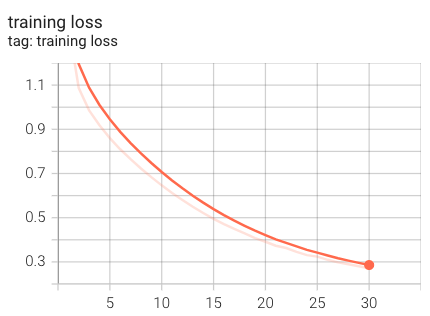

## Evaluation

For the evaluation, we will define a function that takes the image feature extractor and the trained encoder, decoder. It will transform the image and generate a caption starting with the `<sos>` spectial token. The caption generation stops when and `<eos>` token is generated by the decoder or the maximum length of caption tokens is reached.

In [ ]:
def evaluate(encoder, decoder, tokenizer, image_path, max_length, attention_shape):
    attention_plot = np.zeros((max_length, attention_shape))
    # initialize hidden state
    hidden = decoder.reset_state(batch_size=1)
    image, _ = load_image_fn(image_path)
    # extarct image feature vector
    features = feature_extractor(tf.expand_dims(image, 0))
    features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
    # encode the features
    encoder_out = encoder(features)
    start_token_idx = tokenizer.word_index['<sos>']
    decoder_input = tf.expand_dims([start_token_idx], 0)
    result = []

    # generate the caption
    for i in range(max_length):
        (preds, hidden, attention_w) = decoder(decoder_input, encoder_out, hidden)
        attention_plot[i] = tf.reshape(attention_w, (-1,)).numpy()
        pred_id = tf.random.categorical(preds, 1)[0][0].numpy()
        result.append(tokenizer.index_word[pred_id])

        if tokenizer.index_word[pred_id] == '<eos>':
            return result, attention_plot
        decoder_input = tf.expand_dims([pred_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

> Note: see how for each token we generate an attention plot and added to the final `attention_plot`.

In [ ]:
attention_features_shape = 64

Pick a random image from the evaluation dataset that we saved earlier

In [ ]:
random_id = np.random.randint(0, len(images_val))
image_path = images_val[random_id]

Get and clean the actual image caption

In [ ]:
actual_caption = ' '.join([tokenizer.index_word[i] for i in caption_val[random_id] if i != 0])
actual_caption = (actual_caption.replace('<sos>', '').replace('<eos>', ''))

Generate a caption for the image and clean it from special tokens

In [ ]:
result, attention_plot = evaluate(trainer.encoder, trainer.decoder, tokenizer, image_path, max_length, attention_features_shape)
predicted_caption = (' '.join(result).replace('<sos>', '').replace('<eos>', ''))

Let's show side by side the image with its original caption, and next to it two images overlayed with some of the attention plots (there is one attention plot per output token in the caption) and the predicted caption

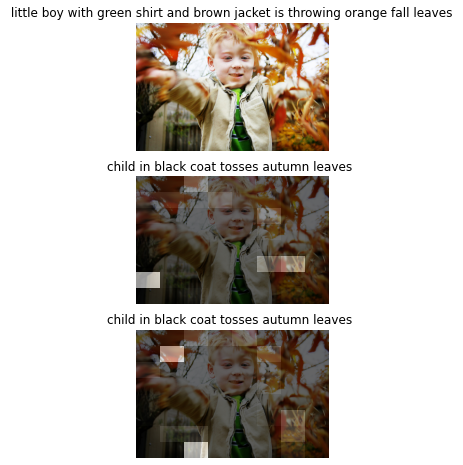

In [ ]:
figure, axis = plt.subplots(3,1, figsize=(15, 8))

axis[0].imshow(plt.imread(image_path))
axis[0].set_title(actual_caption)
axis[0].axis('off')

imageshow = axis[1].imshow(plt.imread(image_path))
axis[1].imshow(np.resize(attention_plot[0], (8, 8)), cmap='gray', alpha=0.6, extent=imageshow.get_extent())
axis[1].set_title(predicted_caption)
axis[1].axis('off')

imageshow = axis[2].imshow(plt.imread(image_path))
axis[2].imshow(np.resize(attention_plot[5], (8, 8)), cmap='gray', alpha=0.6, extent=imageshow.get_extent())
axis[2].set_title(predicted_caption)
axis[2].axis('off')

plt.show()

Notice how well the model performed and generated a caption that's close to the actual ground truth

We can display all attention plots and inspect what the model was looking into when it generated the corresponding token. For this, let's define a function that will receive an image, the caption as sequence of tokens, and the `attention_plot` returned by the previous evualtion function.

In [ ]:
def plot_attention(image_path, result, attention_plot, output_path):
    image_array = plt.imread(image_path)
    fig = plt.figure(figsize=(10, 10))
    # for each token create a sub-plot and display the corresponding attention
    for l in range(len(result)):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len(result) // 2, len(result) // 2, l + 1)
        ax.set_title(result[l])
        image = ax.imshow(image_array)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=image.get_extent())
    # save the attention plot
    plt.savefig(output_path, format='png')
    plt.tight_layout()
    plt.show()


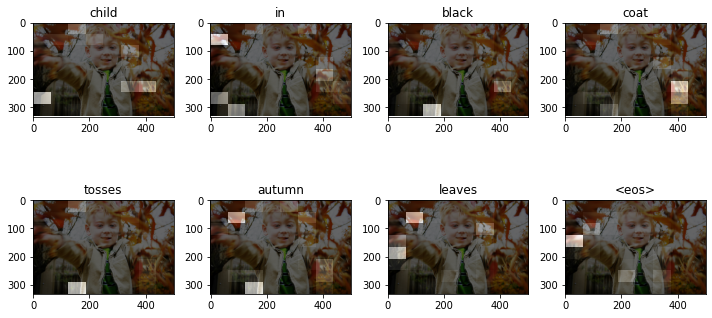

In [ ]:
plot_attention(image_path, result, attention_plot, './attention_plot.png')

> Note: the square areas in the plots represent the areas of the picture the model paid more attention to when generate the tokens. For instance, to produce the word women, the network looked at the head of women in the photo. Also, we can see that when the network generated the word `beside` as it looked at the chair.